In [1]:
import csv
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from patsy import dmatrices
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from msepm import helpers
from scipy import optimize
import scipy.stats as stats
#import scipy.stats.spearmanr as spearmanr
from msepm import MultistateEpigeneticPacemaker
from msepm.scaler import Scaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import pingouin as pg
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.cluster import hierarchy

In [2]:
from functions import pearson_correlation, partial_correlation_1, partial_correlation_2, \
                partial_correlation_single, matrix_of_coeff, filter_sites, filter_sites_partial, \
                filter_sites_partial_order2, filter_sites_partial_order2_locs, filter_sites_multi

In [16]:
# Read in data
df_meth = pd.read_csv(r'C:\Users\Chris\AppData\Local\Programs\Python\Python39\Scripts\Projects\MethMatrixCG-HumanBuccalFitness192_10-100.csv', index_col = 0)
df_meth

chr1_100424052  chr1_100424116  chr1_100718749  \
sampleID                                                          
P41019081703382           0.091           0.011           0.044   
P41019081703393           0.102           0.000           0.016   
P41019081703408           0.137           0.022           0.038   
P41019081703416           0.039           0.000           0.035   
P41019081703483           0.118           0.024           0.066   
...                         ...             ...             ...   
P41019081706767           0.171           0.027           0.034   
P41019081706768           0.010           0.007           0.040   
P41019081706777           0.068           0.009           0.041   
P41019081706804           0.067           0.014           0.054   
P41019081706813           0.091           0.010           0.028   

                 chr1_100718777  chr1_100718963  chr1_100719693  \
sampleID                                                          
P41019081703382           0.229           0.917           0.353   
P41019081703393           0.259           0.933           0.369   
P41019081703408           0.206           0.969           0.406   
P41019081703416           0.279           0.952           0.408   
P41019081703483           0.260           0.973           0.444   
...                         ...             ...             ...   
P41019081706767           0.316           0.976           0.496   
P41019081706768           0.318           0.958           0.392   
P41019081706777           0.266           0.979           0.410   
P41019081706804           0.254           1.000           0.417   
P41019081706813           0.281           1.000           0.429   

                 chr1_100719742  chr1_100719744  chr1_100719756  \
sampleID                                                          
P41019081703382           0.758           0.622           0.459   
P41019081703393           0.806           0.650           0.508   
P41019081703408           0.796           0.605           0.467   
P41019081703416           0.829           0.700           0.543   
P41019081703483           0.759           0.697           0.528   
...                         ...             ...             ...   
P41019081706767           0.830           0.699           0.579   
P41019081706768           0.803           0.708           0.453   
P41019081706777           0.763           0.584           0.462   
P41019081706804           0.785           0.663           0.485   
P41019081706813           0.737           0.623           0.469   

                 chr1_100719847  ...  chrX_97846949  chrX_97846978  \
sampleID                         ...                                 
P41019081703382           0.442  ...          0.903          0.949   
P41019081703393           0.487  ...          0.971          0.980   
P41019081703408           0.500  ...          0.762          0.914   
P41019081703416           0.447  ...          0.935          1.000   
P41019081703483           0.497  ...          0.912          0.951   
...                         ...  ...            ...            ...   
P41019081706767           0.545  ...          0.784          0.952   
P41019081706768           0.472  ...          0.865          0.935   
P41019081706777           0.459  ...          0.861          0.967   
P41019081706804           0.497  ...          0.878          0.962   
P41019081706813           0.459  ...          0.882          0.978   

                 chrX_97846980  chrX_97846990  chrX_97846998  chrX_97847000  \
sampleID                                                                      
P41019081703382          0.974          0.974          0.974          0.974   
P41019081703393          0.960          0.957          0.977          0.977   
P41019081703408          0.943          0.943          0.909          0.939   
P41019081703416          0.951          1.000          1.000          1.000   
P41019081703483 

In [17]:
df_traits_original = pd.read_csv(r'C:\Users\Chris\AppData\Local\Programs\Python\Python39\Scripts\Projects\Traits_BuccalFitness85x237_geneCell.csv', index_col = 0)
df_traits = df_traits_original
df_traits

group  sex  age  weight  height        bmi  bpm  \
sampleID                                                           
P41019081704087      0    0   34    70.1   166.0  25.439106   56   
P41019081704090      0    1   46    60.1   162.6  22.731777   58   
P41019081704100      0    1   47    57.1   152.9  24.402857   83   
P41019081704106      1    1   38   108.4   163.3  40.649660   59   
P41019081704108      0    1   47    67.5   178.9  21.074694   55   
...                ...  ...  ...     ...     ...        ...  ...   
P41019081704250      0    1   68    62.6   160.4  24.311882   60   
P41019081704251      0    1   33    46.1   153.0  19.671921   51   
P41019081704254      0    1   43    73.2   170.1  25.281667   71   
P41019081704257      1    1   38    76.2   158.9  30.179162   87   
P41019081704275      0    0   46    83.5   179.7  25.842242   53   

                 Metabolic_Synd  waist  sysBP  ...  genome_PC90  genome_PC91  \
sampleID                                       ...                             
P41019081704087               1   84.0    114  ...     0.495576    -1.350356   
P41019081704090               0   73.0    107  ...    -0.206746     1.023219   
P41019081704100               0   82.0    128  ...     0.281074     1.749781   
P41019081704106               2  117.0    112  ...    -0.219901     0.223532   
P41019081704108               0   86.3    107  ...     0.277957     0.575874   
...                         ...    ...    ...  ...          ...          ...   
P41019081704250               0   84.0    119  ...     2.462086     0.637521   
P41019081704251               0   74.0    107  ...     0.050844     0.282086   
P41019081704254               1   89.0    108  ...     0.501633    -0.009215   
P41019081704257               2  100.0    119  ...     0.957125    -1.112009   
P41019081704275               0   88.0    124  ...     1.867045     0.628732   

                 genome_PC92  Bcell  Epithelial  Granulocyte  Monocyte  \
sampleID                                                                 
P41019081704087     0.253316      0    0.834887     0.082630         0   
P41019081704090     0.142785      0    0.865519     0.071669         0   
P41019081704100     0.489374      0    0.300880     0.636689         0   
P41019081704106     0.262061      0    0.726279     0.186872         0   
P41019081704108     6.763826      0    0.890472     0.047781         0   
...                      ...    ...         ...          ...       ...   
P41019081704250     0.516194      0    0.868335     0.074864         0   
P41019081704251     0.396744      0    0.676397     0.275897         0   
P41019081704254     0.006611      0    0.631580     0.319970         0   
P41019081704257     1.181136      0    0.865027     0.081719         0   
P41019081704275     0.275325      0    0.722329     0.207791         0   

                 NKcell  NaiveT  Tcell  
sampleID                                
P41019081704087     0.0       0      0  
P41019081704090     0.0       0      0  
P41019081704100     0.0       0      0  
P41019081704106     0.0       0      0  
P41019081704108     0.0       0      0  
...                 ...     ...    ...  
P41019081704250     0.0       0      0  
P41019081704251     0.0       0      0  
P41019081704254     0.0       0      0  
P41019081704257     0.0       0      0  
P41019081704275     0.0       0      0  

[85 rows x 237 columns]

In [18]:
for i in df_traits.columns:
    print(i)

group
sex
age
weight
height
bmi
bpm
Metabolic_Synd
waist
sysBP
diaBP
HDL
LDL
trigly
glucose
SECA_fat
SECA_fatfree
SECA_fatPercent
abdomDiam
grip
legbackStrength
legbackStrengthPerKg
wbc
hemoglobin
hematocrit
platelets
neutrophils
lymphocytes
monocytes
eosinophils
basophils
BUN
creatinine
estGFR
sodium
potassium
chloride
C02
calcium
protein
albumin
globulin
bilirubin
alkaPhos
AST
ALT
chol
A1C
cortisol
TSH
calcitriol_vitD
CRP
B12
insulin
freeT3
vig_dayPerWeek
vig_none
vig_hourPerDay
vig_minPerDay
mod_dayPerWeek
mod_none
mod_hourPerDay
mod_minPerDay
walk_dayPerWeek
walk_none
walk_hourPerDay
walk_minPerDay
sit_hourPerDay
vigorous
moderate
walking
METS_minPerWeek
PAfitness
PAfrequency
PAwork
PAyears
edu
marital
race
job
chronicDisRisk01
chronicDisRisk04
chronicDisRisk07
chronicDisRisk08
chronicDisRisk09
chronicDisRisk11
medhist3
medhist27
medhist42
meds13
fruit
veg
fruitplusveg
cereal
fiber
redmeat
leanmeat
dairy
dairyfat
fatandoils
mostweight
idealweight
weightloss
spirit
stress
sthlth
sle

In [20]:
# data cleaning
# index = [0]
# for i in range(1, len(df_meth)):
#     if df_meth.index[i] in df_traits.index:
#         index.append(i)
        
# df_meth = df_meth.iloc[index] 

# index = [0]
# for i in range(1, len(df_traits)):
#     if df_traits.index[i] in df_meth.index:
#         index.append(i)

# df_traits = df_traits.iloc[index]

cleaned_index = []
count = 0
for sample in df_meth.index:
    if sample not in list(df_traits.T):
        count+=1
    else:
        cleaned_index.append(sample)
df_traits = df_traits.T[cleaned_index]
df_traits = df_traits.T
df_meth = df_meth.astype(float)
df_meth = df_meth.T[cleaned_index]
df_meth = df_meth.T
df_traits.reindex(df_meth.index)

drop = ['Monocyte', 'NaiveT', 'Tcell', 'Bcell']
for i in drop:
    df_traits.drop(i, inplace=True, axis=1)

In [21]:
df_traits_normal = df_traits

for col in df_traits.columns:
    if col != 'group':
        df_traits_normal[col] = (df_traits[col] - np.mean(df_traits[col])) / np.std(df_traits[col])
        #print(col, np.mean(df_traits[col]), np.std(df_traits[col]))

#drop = ['Monocyte', 'NaiveT', 'Tcell', 'Bcell', 'group']
#drop = ['Monocyte', 'NaiveT', 'Tcell', 'Bcell']
#for i in drop:
#    df_traits_normal.drop(i, inplace=True, axis=1)
#df_traits_normal

In [22]:
traits_pcorrs = np.zeros((len(df_traits_normal.columns ),len(df_traits_normal.columns)))
count1 = 0
for i in df_traits_normal:
    a = df_traits_normal[i]
    count2 = 0
    for j in df_traits_normal:
        b = df_traits_normal[j]
        traits_pcorrs[count1][count2] = pearsonr(a,b)[0]
        count2 += 1
    count1 +=1

<AxesSubplot:>

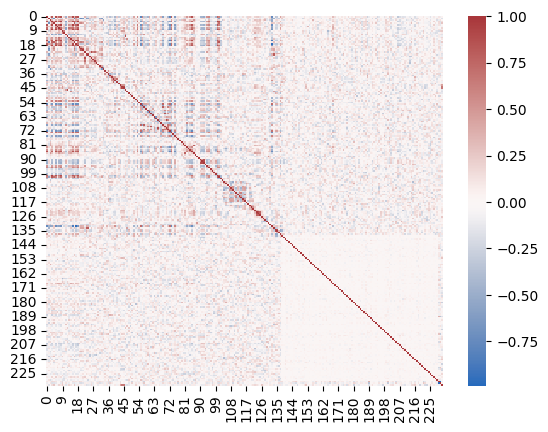

In [23]:
sns.heatmap(traits_pcorrs, center = 0, cmap='vlag')

In [24]:
traits_matter = ['age','sex','Epithelial','genome_PC1','SECA_fatPercent']

count1=0
arr = np.zeros((len(traits_matter),len(traits_matter)))
for i in traits_matter:
    count2=0
    for j in traits_matter:
        arr[count1][count2] = pearsonr(df_traits_normal[i],df_traits_normal[j])[0]
        count2+=1
    count1+=1

arr
df_corrs = pd.DataFrame(arr, columns = ['age','sex','Epithelial','genome_PC1','SECA_fatPercent'], index = ['age','sex','Epithelial','genome_PC1','SECA_fatPercent'])
df_corrs

age       sex  Epithelial  genome_PC1  SECA_fatPercent
age              1.000000 -0.052856   -0.109672   -0.147945         0.404481
sex             -0.052856  1.000000    0.049925    0.233247         0.433440
Epithelial      -0.109672  0.049925    1.000000    0.148583         0.125771
genome_PC1      -0.147945  0.233247    0.148583    1.000000         0.258095
SECA_fatPercent  0.404481  0.433440    0.125771    0.258095         1.000000

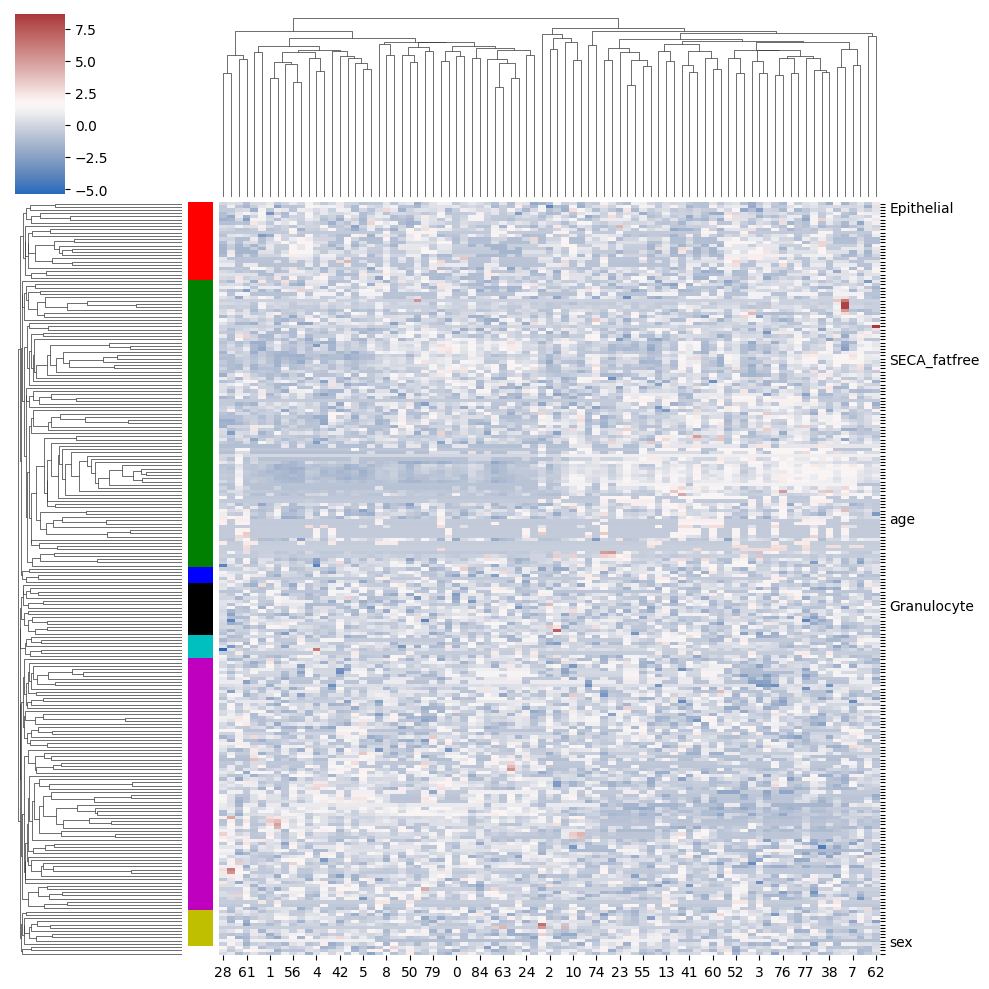

In [25]:
#NOT REALLY RELEVANT - CANNOT DRAW USEFUL CONCLUSIONS

rescaled_traits_arr = df_traits_normal.to_numpy()
#elim = [i for i in range(54,len(df_traits_normal.columns),1)]

#elim.append(0)
#rescaled_traits_arr = np.delete(rescaled_traits_arr, elim, axis=1)

#third_factor = list(df_traits.columns[3:54])
# to_remove = ['grip', 'legbackStrength', 'legbackStrengthPerKg', 'platelets', 'estGFR', 'A1C']
# to_remove_i = [third_factor.index(i) for i in to_remove]
# third_factor.remove('grip')
# third_factor.remove('legbackStrength')
# third_factor.remove('legbackStrengthPerKg')
# third_factor.remove('platelets')
# third_factor.remove('estGFR')
# third_factor.remove('A1C')
# third_factor.insert(0,'age')
# third_factor.insert(0,'sex')

#rescaled_traits_arr = np.delete(rescaled_traits_arr, to_remove_i, axis=1)
#rescaled_traits_arr[np.isnan(rescaled_traits_arr)] = 0
third_factor = list(df_traits.columns)

checks = ['sex','age','Granulocyte','Epithelial','SECA_fatfree']
for i in range(len(third_factor)):
    if third_factor[i] not in checks:
        third_factor[i] = ' '

row_linkage = hierarchy.linkage(distance.pdist(rescaled_traits_arr.T), method='average', optimal_ordering = True)
labels = hierarchy.fcluster(row_linkage, 8, criterion="maxclust")
colors = ['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8', '.9', '1']
colors = 'rgbkcmyw'
row_colors = [colors[i - 1] for i in labels]

sns.clustermap(rescaled_traits_arr.T, row_linkage = row_linkage, row_colors=row_colors, yticklabels = third_factor, \
               metric = 'correlation', cmap = 'vlag')
#sns.clustermap(coef_zscores, row_linkage = row_linkage, row_colors=row_colors, xticklabels = traits, cmap = 'vlag')

In [26]:
#select sites according to age and sex
df_traits_s = df_traits[~df_traits.index.duplicated(keep='first')]

traits = [#'age','sex', 
    'SECA_fatPercent', 'Epithelial', 'genome_PC1']
phenos_ctype = []

for num,(ind, row) in enumerate(df_meth.iterrows()):
    phenos_ctype.append(list(df_traits_s.loc[row.name][traits]))
    
phenos_ctype = np.array(phenos_ctype)
meth_multi_as = filter_sites_multi(df_meth, phenos_ctype, [ #.65, .985,
    .42, .94, .4], traits)
meth_multi_locs = filter_sites_multi(df_meth, phenos_ctype, [#.65, .985,
    .3, .94, .4], traits, 'locs')

all samples and sites (77826, 85)
training sites: 1495
all samples and sites (77826, 85)


In [27]:
# set up the third factor that we are interested in
# third_factor = list(df_traits.columns[3:54])
# # third_factor = list(df_traits.columns[98:])
# third_factor.remove('grip')
# third_factor.remove('legbackStrength')
# third_factor.remove('legbackStrengthPerKg')
# third_factor.remove('platelets')
# third_factor.remove('estGFR')
# third_factor.remove('A1C')

third_factor = list(df_traits.columns)
third_factor.remove('sex')
third_factor.remove('age')

#third_factor
#third_factor = ['weight','height','bmi','bpm', 'sysBP','diaBP','SECA_fat','SECA_fatfree','SECA_fatPercent','waist','abdomDiam','grip','wbc','hemoglobin','hematocrit','neutrophils','lymphocytes','monocytes','eosinophils','basophils','glucose','BUN','creatinine','sodium','potassium', 'chloride','C02','calcium']
#third_factor = ['weight','height','bmi','bpm', 'sysBP','diaBP','SECA_fat','SECA_fatfree','SECA_fatPercent','waist','abdomDiam','wbc','hemoglobin','hematocrit','neutrophils','lymphocytes','monocytes','eosinophils','basophils','glucose','BUN','creatinine','sodium','potassium', 'chloride','C02','calcium']

In [30]:
third_factor

['group',
 'weight',
 'height',
 'bmi',
 'bpm',
 'Metabolic_Synd',
 'waist',
 'sysBP',
 'diaBP',
 'HDL',
 'LDL',
 'trigly',
 'glucose',
 'SECA_fat',
 'SECA_fatfree',
 'SECA_fatPercent',
 'abdomDiam',
 'grip',
 'legbackStrength',
 'legbackStrengthPerKg',
 'wbc',
 'hemoglobin',
 'hematocrit',
 'platelets',
 'neutrophils',
 'lymphocytes',
 'monocytes',
 'eosinophils',
 'basophils',
 'BUN',
 'creatinine',
 'estGFR',
 'sodium',
 'potassium',
 'chloride',
 'C02',
 'calcium',
 'protein',
 'albumin',
 'globulin',
 'bilirubin',
 'alkaPhos',
 'AST',
 'ALT',
 'chol',
 'A1C',
 'cortisol',
 'TSH',
 'calcitriol_vitD',
 'CRP',
 'B12',
 'insulin',
 'freeT3',
 'vig_dayPerWeek',
 'vig_none',
 'vig_hourPerDay',
 'vig_minPerDay',
 'mod_dayPerWeek',
 'mod_none',
 'mod_hourPerDay',
 'mod_minPerDay',
 'walk_dayPerWeek',
 'walk_none',
 'walk_hourPerDay',
 'walk_minPerDay',
 'sit_hourPerDay',
 'vigorous',
 'moderate',
 'walking',
 'METS_minPerWeek',
 'PAfitness',
 'PAfrequency',
 'PAwork',
 'PAyears',
 'edu',


all samples and sites (77826, 85)
training sites: 159
all samples and sites (77826, 85)


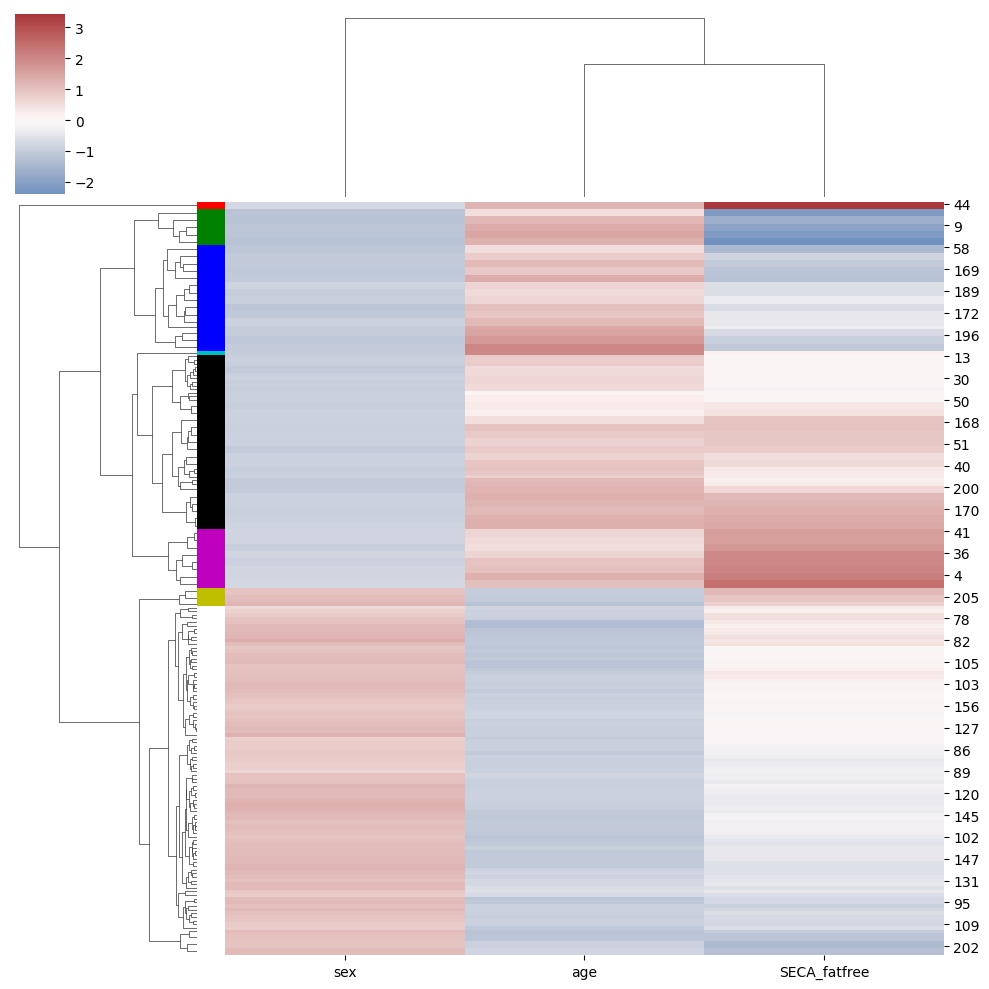

In [28]:
#normalized version of above 
#select sites according to age and sex
df_traits_s = df_traits_normal[~df_traits.index.duplicated(keep='first')]

traits = ['age','sex']
phenos_ctype = []

for num,(ind, row) in enumerate(df_meth.iterrows()):
    phenos_ctype.append(list(df_traits_s.loc[row.name][traits]))
    
phenos_ctype = np.array(phenos_ctype)
meth_multi_as = filter_sites_multi(df_meth, phenos_ctype, [.65, .985], traits)
meth_multi_locs = filter_sites_multi(df_meth, phenos_ctype, [.65, .985], traits, 'locs')

#This block simply extracts phenotype data selected traits from all individuals (96 individuals, 3 traits)
df_traits_s = df_traits_normal[~df_traits.index.duplicated(keep='first')]
traits = ['age','sex', 'SECA_fatfree'] # manully input base factors, change to AGE and SEX
phenos_ctype = []
for num,(ind, row) in enumerate(df_meth.iterrows()):
    phenos_ctype.append(list(df_traits_s.loc[row.name][traits]))
phenos_ctype = np.array(phenos_ctype)

#print(traits[0:2])

X = phenos_ctype
Y = meth_multi_as
third_site = filter_sites_partial_order2(Y.T, X[:,2], X[:,0], X[:,1], 70)

#meth_multi_locs = filter_sites_multi(df_meth, phenos_ctype, [.65, .985], traits[0:2], 'locs')
third_site_locs = filter_sites_partial_order2_locs(Y.T, X[:,2], X[:,0], X[:,1], 70, meth_multi_locs)

#print(Y.shape, third_site.shape)
Y = np.vstack((Y, third_site))
model = MultistateEpigeneticPacemaker(verbose = False, iter_limit = 80)       
#print(X.shape, Y.shape)
model.fit(X, Y)

coef_zscores = np.zeros(model._coefs.shape)
for i in range(model._coefs.shape[1]):
    a = stats.zscore(model._coefs[:,i])
    coef_zscores[:,i] = a
    
#print(coef_zscores)
#fig, ax = plt.subplots(figsize = (10,15))
#sns.heatmap(coef_zscores, xticklabels = traits, cmap = 'vlag')

#create bed file - will overwrite the previous one
all_locs = np.append(meth_multi_locs, third_site_locs)
with open('bednormal.txt', 'w') as f:
    for i in all_locs:
        f.write(i.split('_')[0] + '\t' + i.split('_')[1] + '\t' + str(int(i.split('_')[1]) + 1) + '\n')
        
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
from scipy.spatial import distance
from scipy.cluster import hierarchy

#correlations_array = np.asarray(df.corr())

row_linkage = hierarchy.linkage(distance.pdist(coef_zscores), method='average', optimal_ordering = True)
labels = hierarchy.fcluster(row_linkage, 8, criterion="maxclust")
colors = ['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8', '.9', '1']
colors = 'rgbkcmyw'
row_colors = [colors[i - 1] for i in labels]

sns.clustermap(coef_zscores, row_linkage = row_linkage, row_colors=row_colors, xticklabels = traits, cmap = 'vlag', center=0)

all samples and sites (77826, 85)
training sites: 159
all samples and sites (77826, 85)
all samples and sites (77826, 85)
training sites: 1148
all samples and sites (77826, 85)


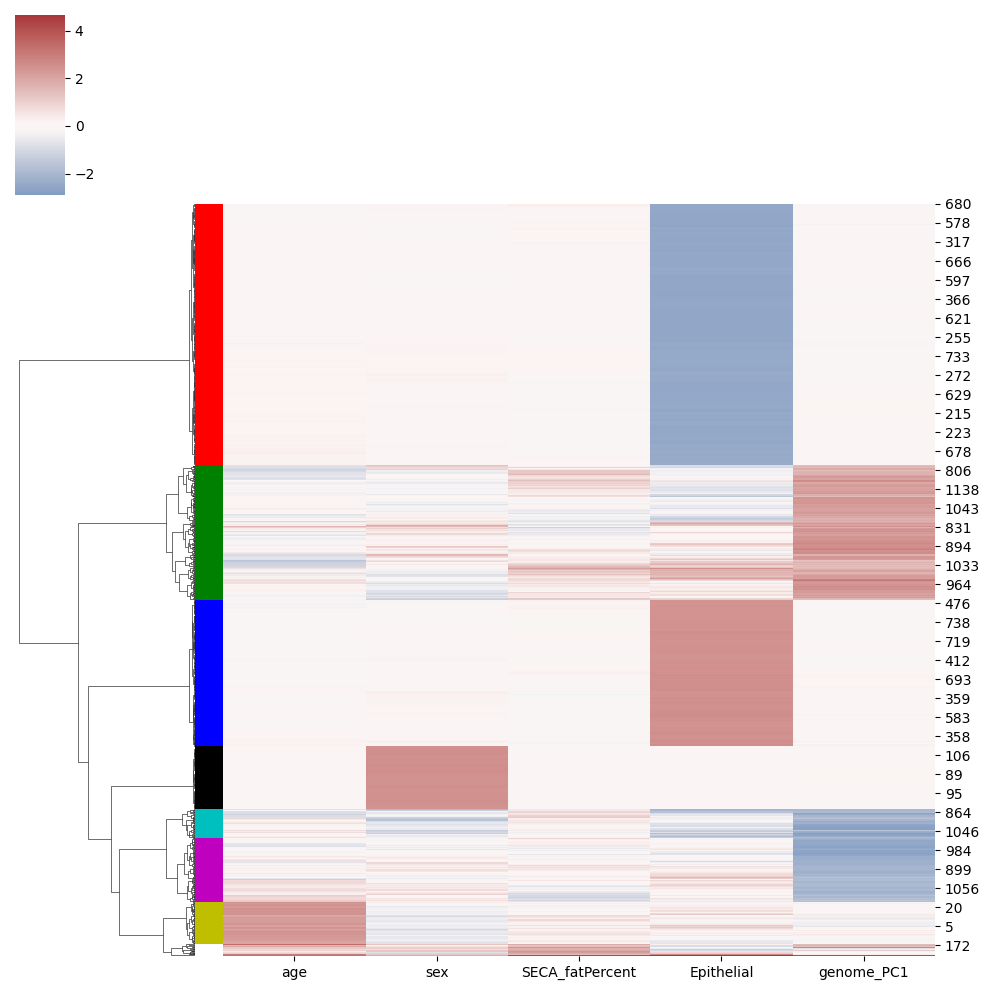

In [26]:
#normalized version of above 
#select sites according to age and sex
df_traits_s = df_traits[~df_traits.index.duplicated(keep='first')]
traits = ['age','sex', 
    'SECA_fatPercent', 'Epithelial', 'genome_PC1']
phenos_ctype = []

for num,(ind, row) in enumerate(df_meth.iterrows()):
    phenos_ctype.append(list(df_traits_s.loc[row.name][traits]))
    
phenos_ctype = np.array(phenos_ctype)
meth_multi_as = filter_sites_multi(df_meth, phenos_ctype, [ .65, .985,
    .42, .94, .4], traits)
meth_multi_locs = filter_sites_multi(df_meth, phenos_ctype, [.65, .985,
    .42, .94, .4], traits, 'locs')

X = phenos_ctype
Y = meth_multi_as

# third_site = filter_sites_partial_order2(Y.T, X[:,2], X[:,0], X[:,1], 70)
# #meth_multi_locs = filter_sites_multi(df_meth, phenos_ctype, [.65, .985], traits[0:2], 'locs')
# third_site_locs = filter_sites_partial_order2_locs(Y.T, X[:,2], X[:,0], X[:,1], 70, meth_multi_locs)
# #print(Y.shape, third_site.shape)

# third_site2 = filter_sites_partial_order2(Y.T, X[:,3], X[:,0], X[:,1], 70)
# third_site_locs2 = filter_sites_partial_order2_locs(Y.T, X[:,3], X[:,0], X[:,1], 70, meth_multi_locs)

# third_site3 = filter_sites_partial_order2(Y.T, X[:,4], X[:,0], X[:,1], 70)
# third_site_locs3 = filter_sites_partial_order2_locs(Y.T, X[:,4], X[:,0], X[:,1], 70, meth_multi_locs)

# Y = np.vstack((Y, third_site))
# Y = np.vstack((Y, third_site2))
# Y = np.vstack((Y, third_site3))
model = MultistateEpigeneticPacemaker(verbose = False, iter_limit = 80)       
#print(X.shape, Y.shape)
model.fit(X, Y)
coef_zscores = np.zeros(model._coefs.shape)
for i in range(model._coefs.shape[1]):
    a = stats.zscore(model._coefs[:,i])
    coef_zscores[:,i] = a
    
import statistics    

#create bed file - will overwrite the previous one
# all_locs = np.append(meth_multi_locs, third_site_locs)
# all_locs = np.append(all_locs, third_site_locs2)
# all_locs = np.append(all_locs, third_site_locs3)

coef_div_var = np.zeros(model._coefs.shape)
for i in range(model._coefs.shape[0]):
    a = model._coefs[:][i] / statistics.pstdev(model._coefs[:][i])
    coef_div_var[:][i] = a

    
#print('var.shape', coef_div_var)

#print(all_locs)
# with open('bednormal.txt', 'w') as f:
#     for i in all_locs:
#         f.write(i.split('_')[0] + '\t' + i.split('_')[1] + '\t' + str(int(i.split('_')[1]) + 1) + '\n')
# f.close()
        
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
from scipy.spatial import distance
from scipy.cluster import hierarchy

#correlations_array = np.asarray(df.corr())

#use method average, complete, ward
row_linkage = hierarchy.linkage(distance.pdist(coef_div_var), method='ward', \
                                optimal_ordering = True, metric = "correlation")
labels = hierarchy.fcluster(row_linkage, 8, criterion="maxclust")
colors = 'rgbkcmyw'
colors = ['r','g','b','k','c','m','y','w']
colors2 = ['0', '.2', '.4', '.6', '.8', '.1']
#colors2 = ['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8', '.9', '1']
colors.extend(colors2)
#colors = 'rgbkcmyw'
row_colors = [colors[i - 1] for i in labels]

sns.clustermap(coef_div_var, row_linkage = row_linkage, row_colors=row_colors, col_cluster=False, \
               xticklabels = traits, cmap = 'vlag', center=0, metric = "correlation")

In [35]:
all_locs = meth_multi_locs

In [36]:
len(meth_multi_locs)

1148

In [39]:
def sortClusters(labels: np.array, locs: np.array, count) -> np.array:
    result = []
    init = 0
    while init < count:
        array = []
        init += 1
        for i in range(len(locs)):
            if labels[i] == init:
                array.append(locs[i])
        result.append(array)
    
    return result

def createBedFile(locs: np.array, filename):
    with open(filename + '.txt', 'w') as f:
        for i in locs:
            f.write(i.split('_')[0] + '\t' + i.split('_')[1] + '\t' + str(int(i.split('_')[1]) + 1) + '\n')
    f.close()
            
clusters = sortClusters(labels, all_locs, 8)
#print(clusters)
bed1 = createBedFile(clusters[0], 'bed1')
bed2 = createBedFile(clusters[1], 'bed2')
bed3 = createBedFile(clusters[2], 'bed3')
bed4 = createBedFile(clusters[3], 'bed4')
bed5 = createBedFile(clusters[4], 'bed5')
bed6 = createBedFile(clusters[5], 'bed6')
bed7 = createBedFile(clusters[6], 'bed7')
bed8 = createBedFile(clusters[7], 'bed8')
# bed9 = createBedFile(clusters[7], 'bed9')
# bed10 = createBedFile(clusters[7], 'bed10')
# bed11 = createBedFile(clusters[7], 'bed11')
# bed12 = createBedFile(clusters[7], 'bed12')
# bed13 = createBedFile(clusters[7], 'bed13')
# bed14 = createBedFile(clusters[7], 'bed14')

In [41]:
def createPeaksFile(locs: np.array, filename):
    count = 1
    with open(filename + 'peaks.txt', 'w') as f:
        for i in locs:
            f.write(i.split('_')[0] + '\t' + i.split('_')[1] + '\t' + str(int(i.split('_')[1]) + 1) + \
                    '\t' + 'peak' + str(count) + '\t' + '10.0' + '\n')
    f.close()
    
clusters = sortClusters(labels, all_locs, 8)
#print(clusters)
bed1 = createPeaksFile(clusters[0], 'bed1')
bed2 = createPeaksFile(clusters[1], 'bed2')
bed3 = createPeaksFile(clusters[2], 'bed3')
bed4 = createPeaksFile(clusters[3], 'bed4')
bed5 = createPeaksFile(clusters[4], 'bed5')
bed6 = createPeaksFile(clusters[5], 'bed6')
bed7 = createPeaksFile(clusters[6], 'bed7')
bed8 = createPeaksFile(clusters[7], 'bed8')
# bed9 = createPeaksFile(clusters[7], 'bed9')
# bed10 = createPeaksFile(clusters[7], 'bed10')
# bed11 = createPeaksFile(clusters[7], 'bed11')
# bed12 = createPeaksFile(clusters[7], 'bed12')
# bed13 = createPeaksFile(clusters[7], 'bed13')
# bed14 = createPeaksFile(clusters[7], 'bed14')

In [2]:
maps = []
with open(r'C:\Users\Chris\Desktop\cistrome bed docs\PP5\Giggle\bed6.bed_result.csv','r') as file:
    lines = file.readlines()
lines
factor_to_score = {}
for line in lines[1:]:
    split = line.split(',')
    factor = split[1]
    score = float(split[-1][:-1])
    factor_to_score[factor] = score
maps.append(factor_to_score)

In [20]:
def createGiggleMap(cluster_count):
    maps = []
    count = 1
    while count <= cluster_count:
        with open(r'C:\Users\Chris\Desktop\cistrome bed docs\PP5\Giggle\bed' \
                  + str(count) + '.bed_result.csv','r') as file:
            lines = file.readlines()
        file.close()
        factor_to_score = {}
        for line in lines[1:11]:
            split = line.split(',')
            factor = split[1]
            score = float(split[-1][:-1])
            factor_to_score[factor] = score
        maps.append(factor_to_score)
        count+=1
    return maps

maps = createGiggleMap(8)

In [21]:
import numpy as np
maxx = 0
factors = set()
for map in maps:
    lent = len(map)
    if lent > maxx:
        maxx = lent
    [factors.add(i) for i in map.keys()]

giggle_map = np.zeros( (maxx, len(maps)) )

In [12]:
final_map = {}
for factor in factors:
    factor_list = []
    for map1 in maps:
        try:
            factor_list.append(float(map1[factor]))
        except:
            factor_list.append(0)
    final_map[factor] = factor_list
final_map

{'GABPA': [0, 0, 0, 1167.425536081295, 0, 0, 0, 0],
 'RBPJ': [157.8851741516876, 0, 0, 0, 0, 0, 0, 0],
 'AR': [0, 561.625836544608, 0, 0, 0, 0, 0, 0],
 'TP53': [186.85188087405254, 0, 0, 0, 0, 0, 0, 0],
 'H2AFZ': [0, 434.1702970057116, 0, 0, 0, 0, 0, 0],
 'EGR2': [0, 0, 0, 0, 85.07385232004371, 0, 0, 0],
 'RNF2': [0, 0, 0, 0, 23.3407826515713, 0, 0, 88.18244646433143],
 'HIF1A': [0, 0, 0, 0, 0, 0, 0, 93.37819631757343],
 'CDCA2': [0, 0, 0, 0, 286.46050153473186, 0, 0, 0],
 'PRPF4': [191.26415020057397,
  0,
  0,
  0,
  23.437499836012673,
  306.09551530794005,
  0,
  0],
 'ERG': [0, 0, 225.74507326154458, 0, 0, 0, 0, 0],
 'EHMT2': [0, 0, 0, 0, 0, 0, 336.8801049171084, 0],
 'NELFA': [0, 405.84690744608713, 0, 0, 0, 0, 0, 0],
 'MBD2': [0, 0, 0, 0, 344.2856430307869, 0, 0, 59.756336352113095],
 'IKZF1': [0, 0, 278.71857092971374, 0, 0, 0, 0, 0],
 'HIRA': [237.11044517461087, 0, 0, 0, 0, 0, 0, 0],
 'RUNX1': [0, 0, 192.25315008086713, 0, 0, 0, 0, 0],
 'KDM1A': [0, 0, 197.94075575356868, 0, 

In [13]:
print(len(final_map))
for key in list(final_map.keys()):
    if max(final_map[key]) < 50:
        del final_map[key]
print(len(final_map))

50
49


In [14]:
matrix = np.zeros( (len(final_map),8))
keys = list(final_map.keys())
for i in range(matrix.shape[0]):
    matrix[i] = final_map[keys[i]]

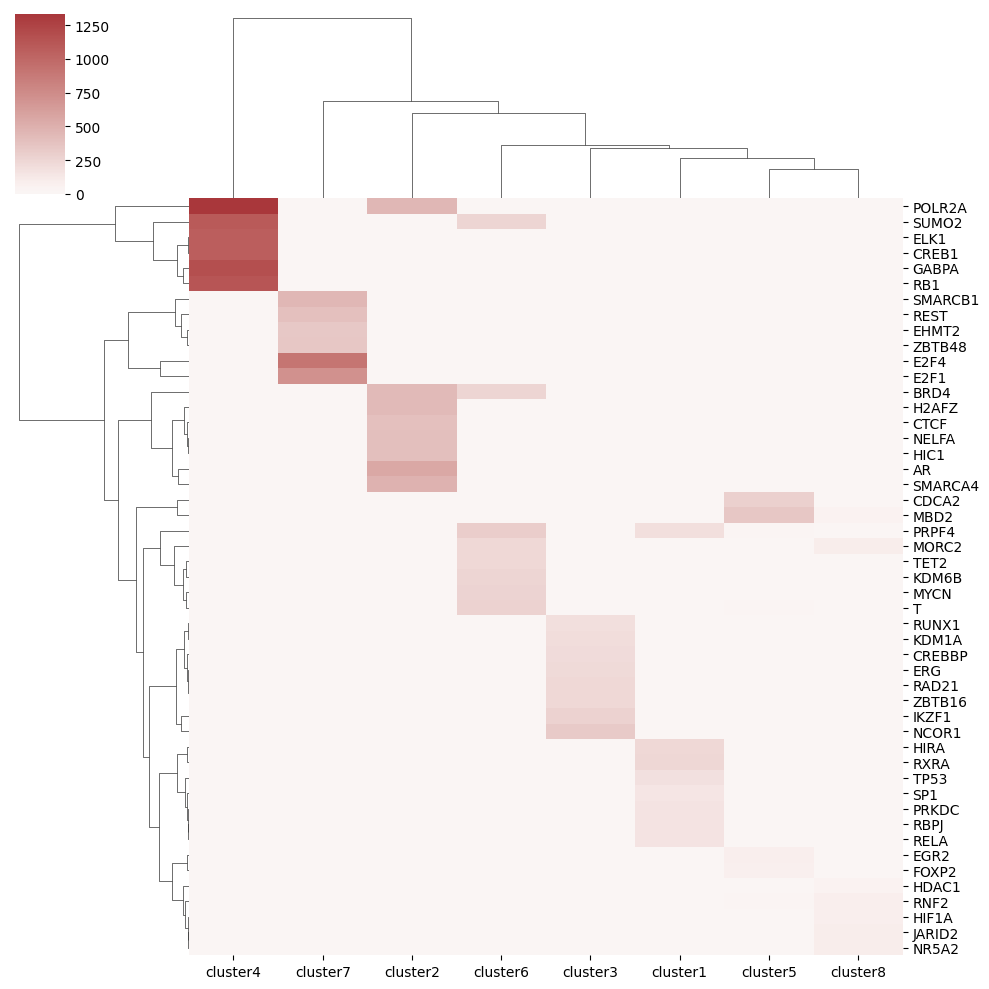

In [15]:
sns.clustermap(matrix, col_cluster=True, \
               xticklabels = \
               ['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6','cluster7','cluster8',], \
               yticklabels = keys,
               cmap = 'vlag', center=0, metric = "euclidean")

This is factor 0
group
group
MSE: 0.030
MAE: 0.047
SpearmanrResult(correlation=0.4066387278013311, pvalue=0.00011255969242438879) [[1.         0.43426728]
 [0.43426728 1.        ]]


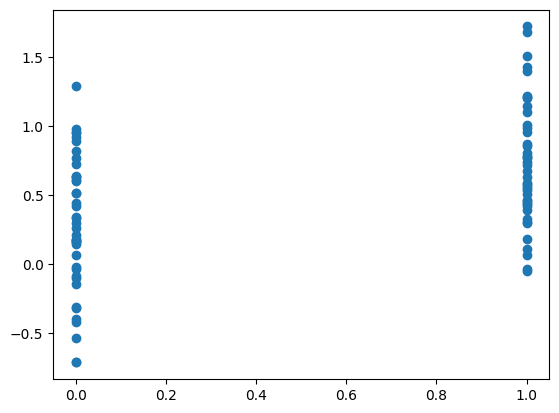

This is factor 1
weight
weight
MSE: 0.138
MAE: 0.098
SpearmanrResult(correlation=0.41402829925310924, pvalue=8.184636197269359e-05) [[1.         0.44237139]
 [0.44237139 1.        ]]


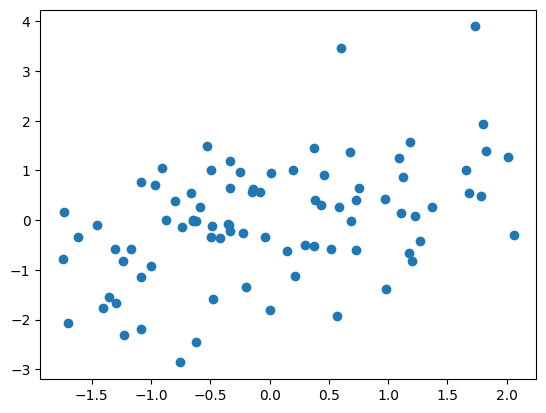

This is factor 2
height
height
MSE: 0.093
MAE: 0.080
SpearmanrResult(correlation=0.6029658238166637, pvalue=1.0185451265713339e-09) [[1.        0.5996975]
 [0.5996975 1.       ]]


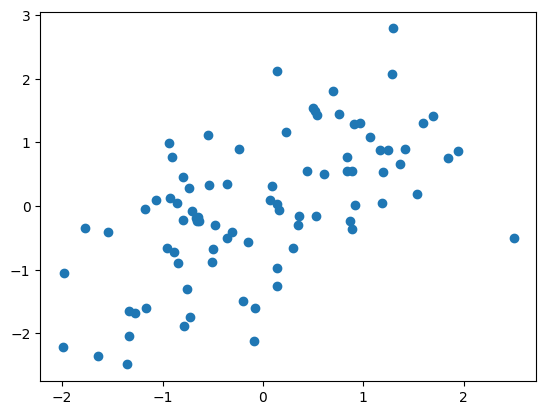

This is factor 3
bmi
bmi
MSE: 0.146
MAE: 0.099
SpearmanrResult(correlation=0.3381668946648427, pvalue=0.0015487510374628964) [[1.         0.34319696]
 [0.34319696 1.        ]]


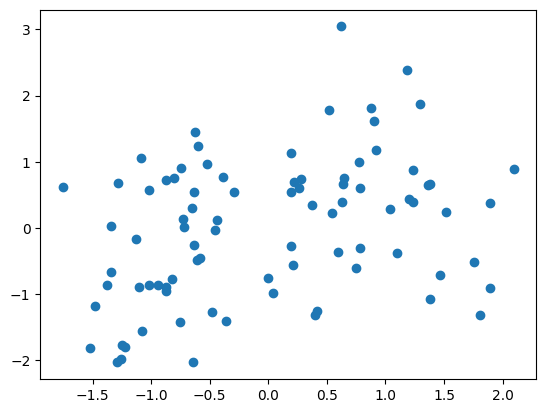

This is factor 4
bpm
bpm
MSE: 0.188
MAE: 0.105
SpearmanrResult(correlation=0.221703967547312, pvalue=0.041430329861575195) [[1.         0.15280091]
 [0.15280091 1.        ]]


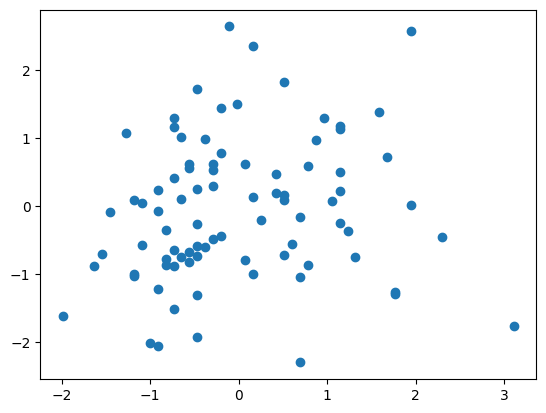

This is factor 5
Metabolic_Synd
Metabolic_Synd
MSE: 0.211
MAE: 0.119
SpearmanrResult(correlation=0.09753909519298214, pvalue=0.3745024304594321) [[1.         0.06573348]
 [0.06573348 1.        ]]


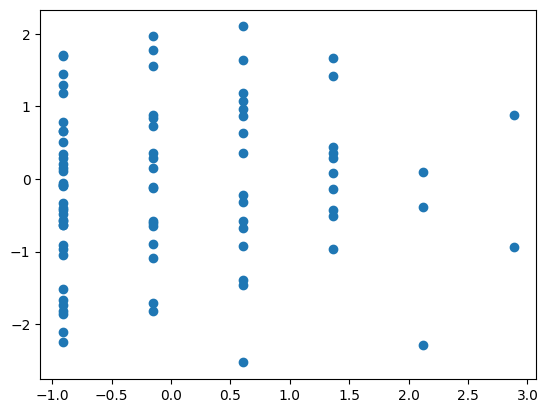

This is factor 6
waist
waist
MSE: 0.143
MAE: 0.100
SpearmanrResult(correlation=0.3951633671763954, pvalue=0.00018196182091997372) [[1.         0.40788449]
 [0.40788449 1.        ]]


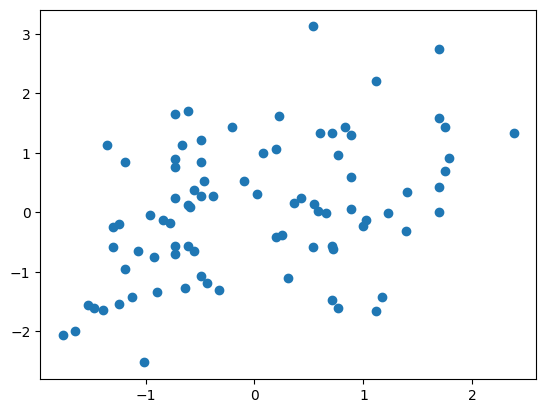

This is factor 7
sysBP
sysBP
MSE: 0.180
MAE: 0.101
SpearmanrResult(correlation=0.16898381708310045, pvalue=0.122097968590119) [[1.         0.15986062]
 [0.15986062 1.        ]]


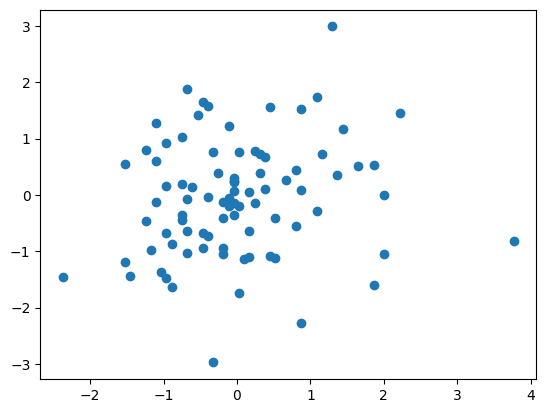

This is factor 8
diaBP
diaBP
MSE: 0.140
MAE: 0.093
SpearmanrResult(correlation=0.3762492325559872, pvalue=0.00038694313329312003) [[1.         0.37379174]
 [0.37379174 1.        ]]


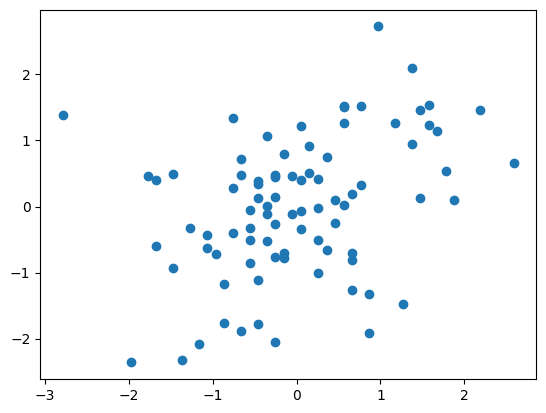

This is factor 9
HDL
HDL
MSE: 0.262
MAE: 0.132
SpearmanrResult(correlation=0.06034685683747471, pvalue=0.583257257429772) [[1.        0.0612857]
 [0.0612857 1.       ]]


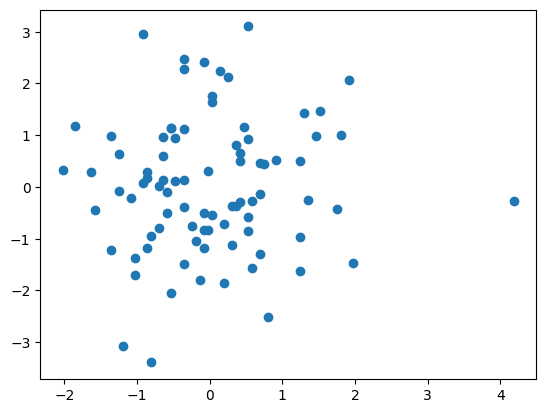

This is factor 10
LDL
LDL
MSE: 0.154
MAE: 0.105
SpearmanrResult(correlation=0.2872767923566032, pvalue=0.0076808098287983) [[1.         0.34987097]
 [0.34987097 1.        ]]


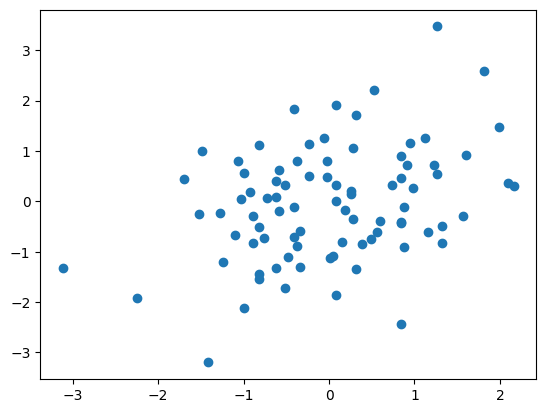

This is factor 11
trigly
trigly
MSE: 0.199
MAE: 0.114
SpearmanrResult(correlation=0.17358457739109162, pvalue=0.1121141861195281) [[1.         0.16289577]
 [0.16289577 1.        ]]


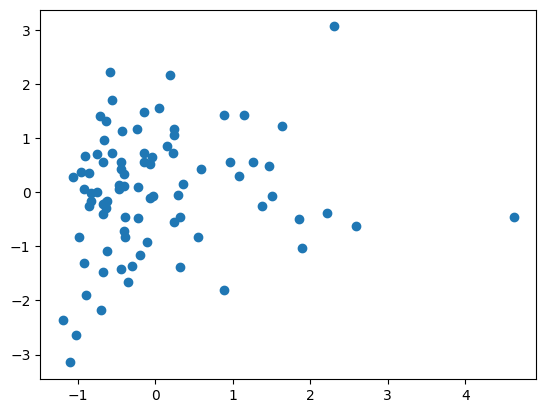

This is factor 12
glucose
glucose
MSE: 0.161
MAE: 0.096
SpearmanrResult(correlation=0.32668671479044725, pvalue=0.0022770205522919577) [[1.        0.2744885]
 [0.2744885 1.       ]]


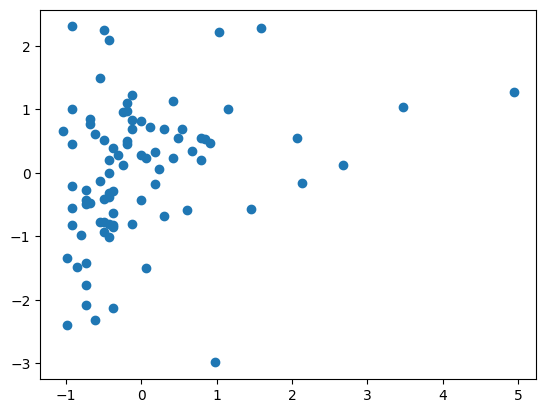

This is factor 13
SECA_fat
SECA_fat
MSE: 0.149
MAE: 0.102
SpearmanrResult(correlation=0.3459159445284769, pvalue=0.0011840612570096455) [[1.         0.35545873]
 [0.35545873 1.        ]]


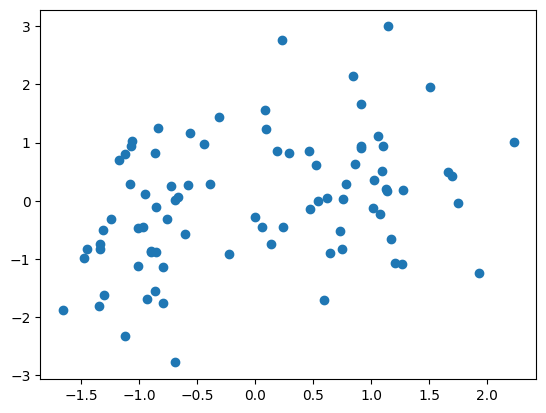

This is factor 14
SECA_fatfree
SECA_fatfree
MSE: 0.075
MAE: 0.068
SpearmanrResult(correlation=0.7082229939562018, pvalue=3.4371716296094305e-14) [[1.         0.67024841]
 [0.67024841 1.        ]]


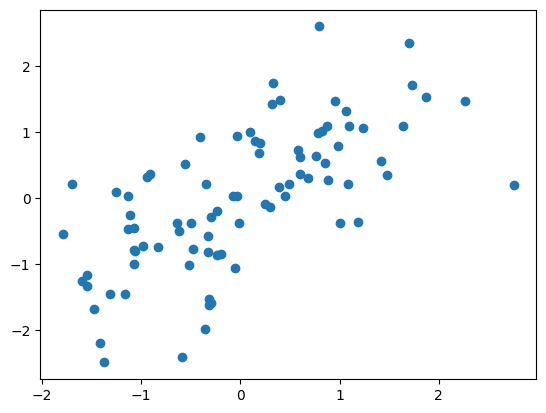

This is factor 15
SECA_fatPercent
SECA_fatPercent
MSE: 0.108
MAE: 0.086
SpearmanrResult(correlation=0.5369495439327056, pvalue=1.1729633923211135e-07) [[1.         0.54448099]
 [0.54448099 1.        ]]


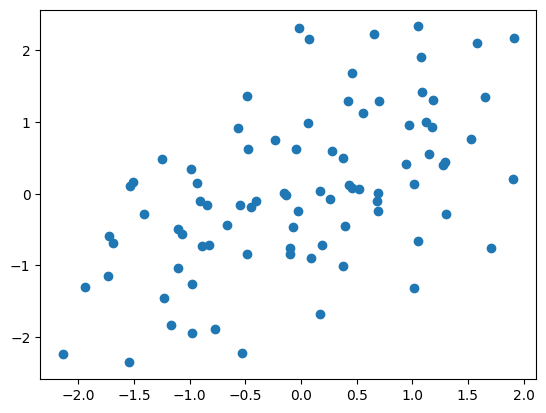

This is factor 16
abdomDiam
abdomDiam
MSE: 0.127
MAE: 0.094
SpearmanrResult(correlation=0.43654718461382236, pvalue=2.957265189622228e-05) [[1.         0.42924351]
 [0.42924351 1.        ]]


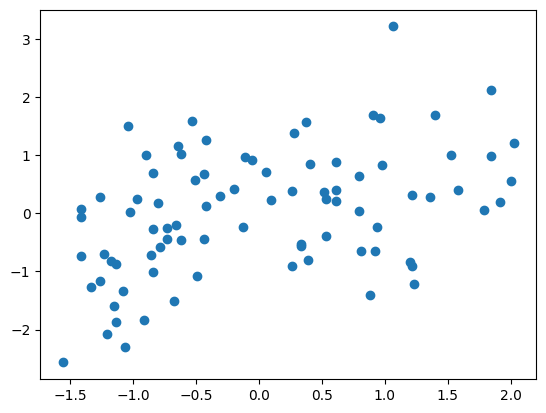

This is factor 17
grip
grip
MSE: 0.231
MAE: 0.124
SpearmanrResult(correlation=0.17929120738411658, pvalue=0.10062276814201052) [[1.         0.16255398]
 [0.16255398 1.        ]]


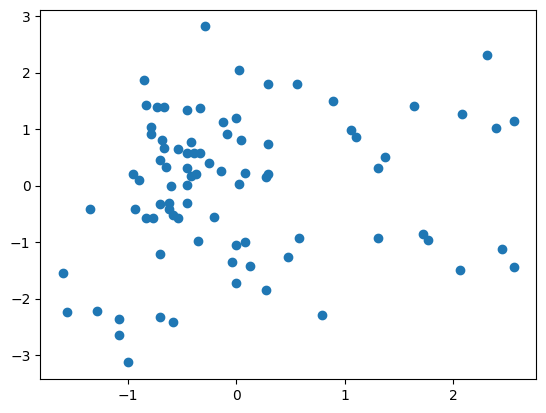

This is factor 18
legbackStrength
legbackStrength
MSE: 0.147
MAE: 0.105
SpearmanrResult(correlation=0.5277737874918345, pvalue=2.0987177333209826e-07) [[1.        0.5398066]
 [0.5398066 1.       ]]


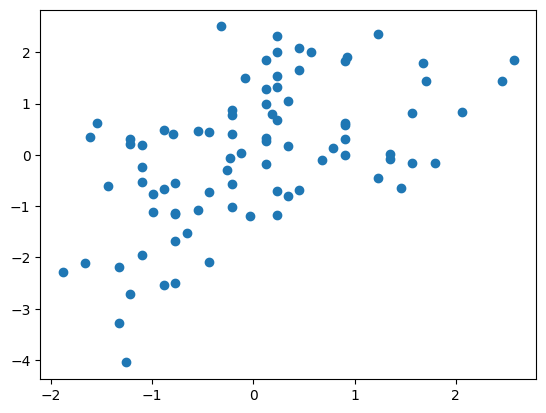

This is factor 19
legbackStrengthPerKg
legbackStrengthPerKg
MSE: 0.240
MAE: 0.131
SpearmanrResult(correlation=0.3539723479288289, pvalue=0.0008891507718897027) [[1.         0.35112172]
 [0.35112172 1.        ]]


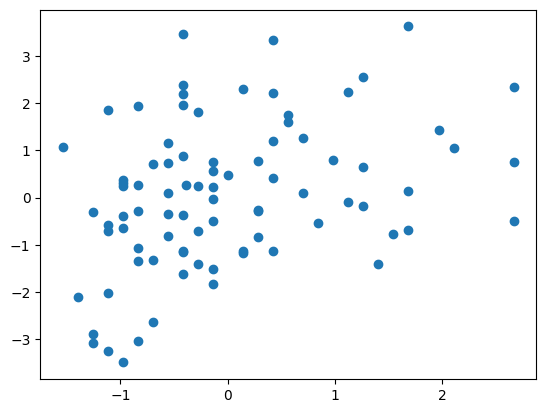

This is factor 20
wbc
wbc
MSE: 0.147
MAE: 0.098
SpearmanrResult(correlation=0.2594338063750047, pvalue=0.016500461767426113) [[1.         0.33390237]
 [0.33390237 1.        ]]


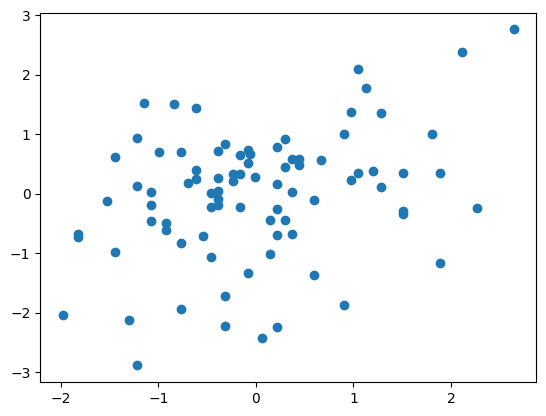

This is factor 21
hemoglobin
hemoglobin
MSE: 0.145
MAE: 0.096
SpearmanrResult(correlation=0.3974424177298856, pvalue=0.00016563515325410596) [[1.         0.36235799]
 [0.36235799 1.        ]]


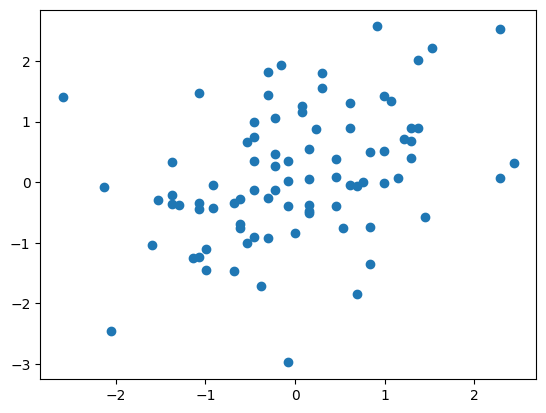

This is factor 22
hematocrit
hematocrit
MSE: 0.140
MAE: 0.090
SpearmanrResult(correlation=0.40555477184462885, pvalue=0.00011787238246578395) [[1.         0.36603742]
 [0.36603742 1.        ]]


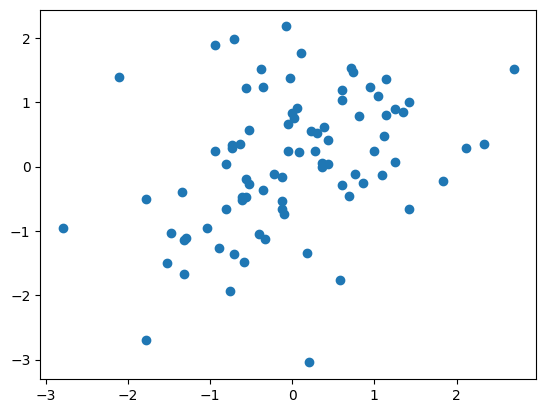

This is factor 23
platelets
platelets
MSE: 0.154
MAE: 0.101
SpearmanrResult(correlation=0.10017932880742403, pvalue=0.36164759602680463) [[1.         0.21991019]
 [0.21991019 1.        ]]


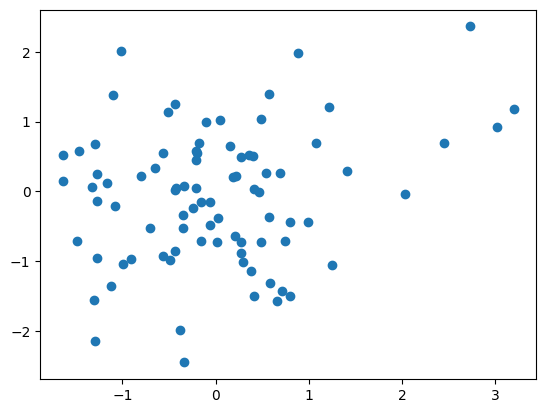

This is factor 24
neutrophils
neutrophils
MSE: 0.163
MAE: 0.098
SpearmanrResult(correlation=0.3053813983311768, pvalue=0.004482915583869631) [[1.         0.32266511]
 [0.32266511 1.        ]]


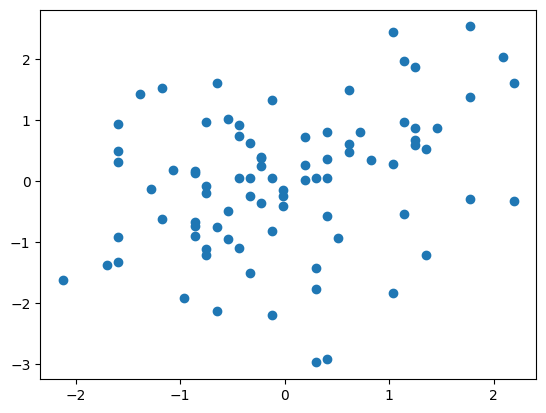

This is factor 25
lymphocytes
lymphocytes
MSE: 0.135
MAE: 0.094
SpearmanrResult(correlation=0.2942174384975386, pvalue=0.006272921204224519) [[1.         0.32923683]
 [0.32923683 1.        ]]


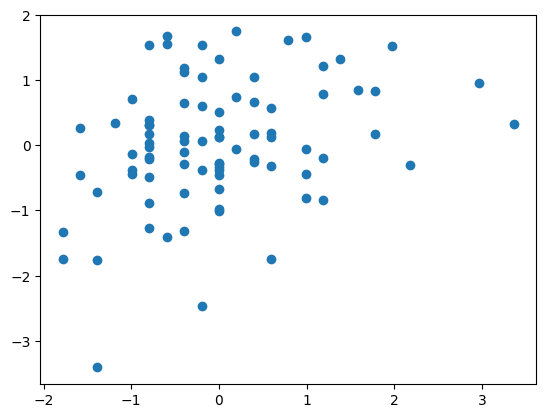

This is factor 26
monocytes
monocytes
MSE: 0.157
MAE: 0.106
SpearmanrResult(correlation=0.2601355051576775, pvalue=0.016200318566270876) [[1.         0.25822857]
 [0.25822857 1.        ]]


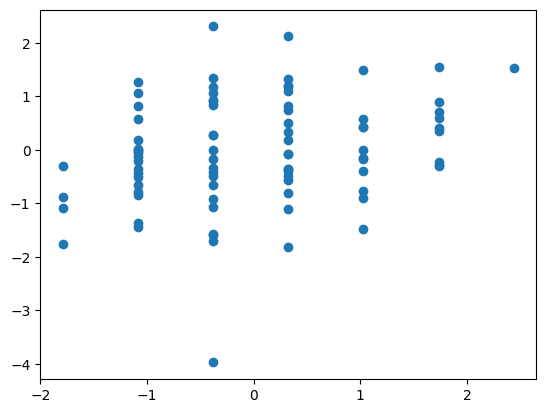

This is factor 27
eosinophils
eosinophils
MSE: 0.185
MAE: 0.111
SpearmanrResult(correlation=0.1171223933479541, pvalue=0.28574335093765535) [[1.         0.12990374]
 [0.12990374 1.        ]]


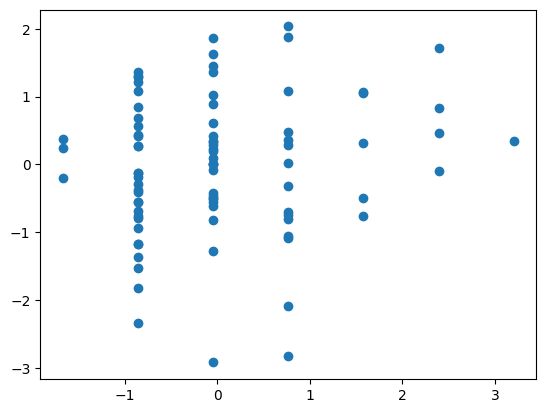

This is factor 28
basophils
basophils
MSE: 0.200
MAE: 0.116
SpearmanrResult(correlation=0.26589223599758877, pvalue=0.013910863326468978) [[1.         0.25379757]
 [0.25379757 1.        ]]


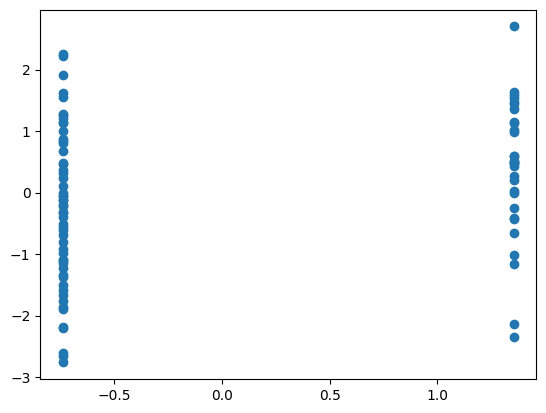

This is factor 29
BUN
BUN
MSE: 0.138
MAE: 0.096
SpearmanrResult(correlation=0.4326921711100596, pvalue=3.538433118835252e-05) [[1.         0.39634242]
 [0.39634242 1.        ]]


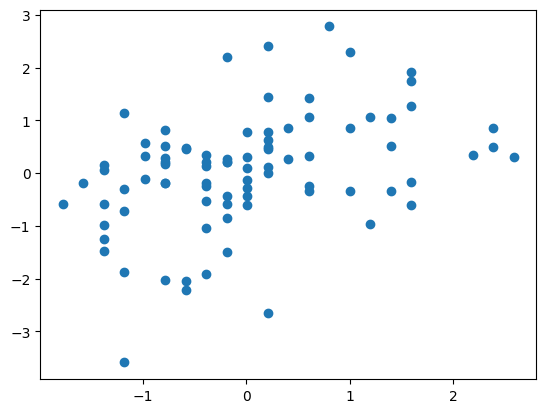

This is factor 30
creatinine
creatinine
MSE: 0.153
MAE: 0.108
SpearmanrResult(correlation=0.3896120838942987, pvalue=0.00022814040234114558) [[1.         0.40247394]
 [0.40247394 1.        ]]


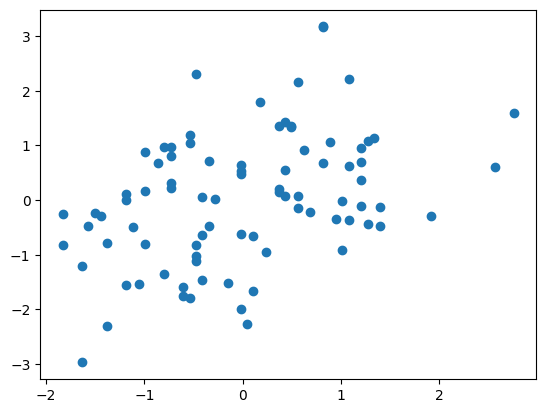

This is factor 31
estGFR
estGFR
MSE: 0.152
MAE: 0.101
SpearmanrResult(correlation=0.3510921859803369, pvalue=0.000985876757614282) [[1.         0.39025833]
 [0.39025833 1.        ]]


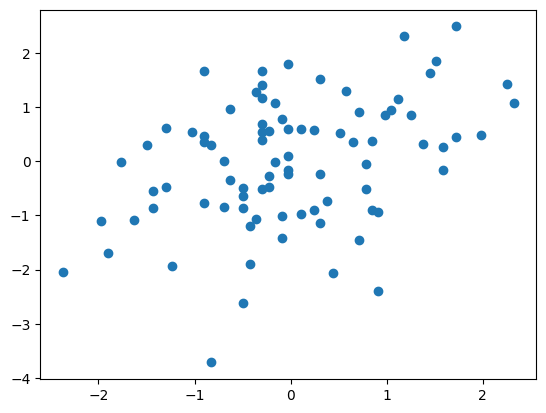

This is factor 32
sodium
sodium
MSE: 0.229
MAE: 0.120
SpearmanrResult(correlation=-0.036627008608582985, pvalue=0.7392881626934169) [[ 1.         -0.04479417]
 [-0.04479417  1.        ]]


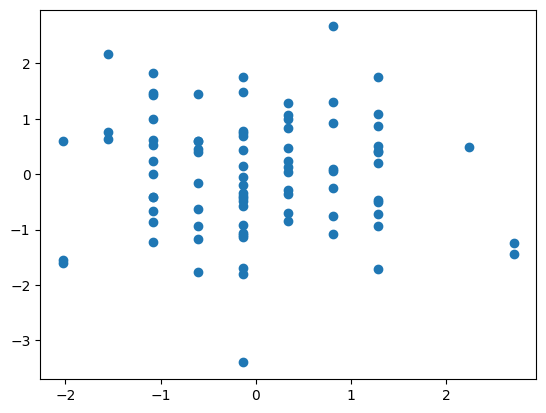

This is factor 33
potassium
potassium
MSE: 0.153
MAE: 0.100
SpearmanrResult(correlation=0.21079951642377967, pvalue=0.05280405561322111) [[1.         0.24598734]
 [0.24598734 1.        ]]


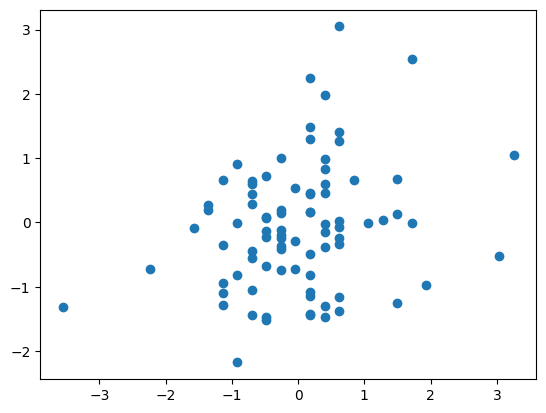

This is factor 34
chloride
chloride
MSE: 0.215
MAE: 0.120
SpearmanrResult(correlation=0.13132798233617143, pvalue=0.2308960817093387) [[1.         0.12214883]
 [0.12214883 1.        ]]


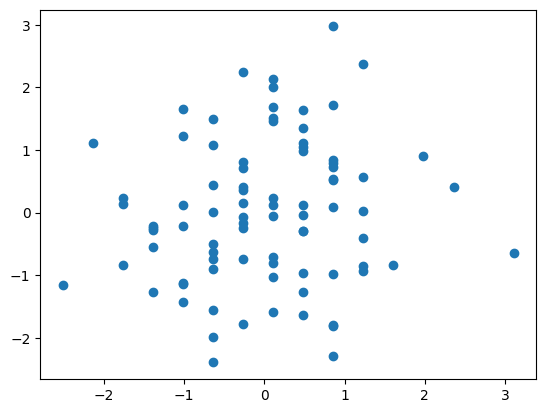

This is factor 35
C02
C02
MSE: 0.151
MAE: 0.099
SpearmanrResult(correlation=0.3512258467389602, pvalue=0.0009811844430088962) [[1.         0.31255524]
 [0.31255524 1.        ]]


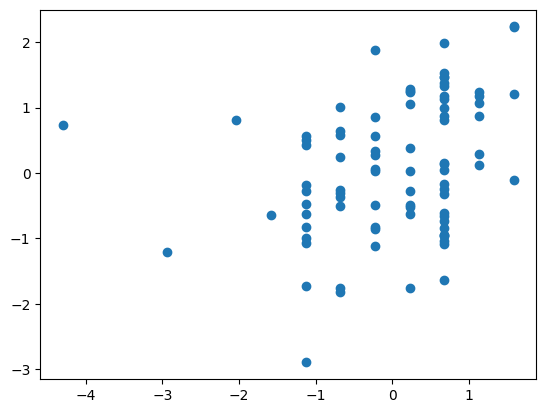

This is factor 36
calcium
calcium
MSE: 0.221
MAE: 0.123
SpearmanrResult(correlation=0.17102846749610146, pvalue=0.11757991966238228) [[1.         0.16720431]
 [0.16720431 1.        ]]


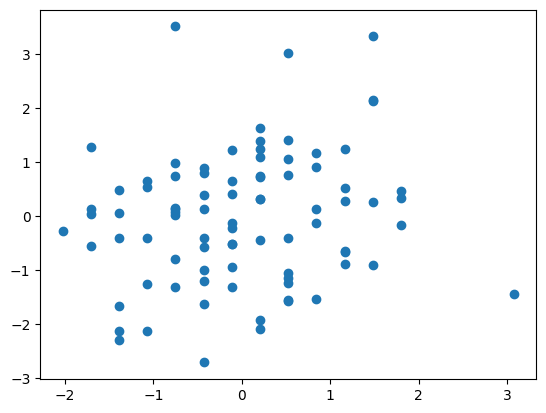

This is factor 37
protein
protein
MSE: 0.137
MAE: 0.096
SpearmanrResult(correlation=0.39876723576610257, pvalue=0.00015677739533053394) [[1.         0.38901849]
 [0.38901849 1.        ]]


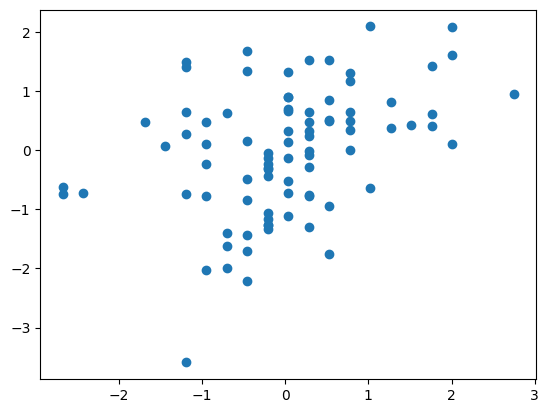

This is factor 38
albumin
albumin
MSE: 0.152
MAE: 0.101
SpearmanrResult(correlation=0.2909714641719952, pvalue=0.00690014058945138) [[1.        0.2986397]
 [0.2986397 1.       ]]


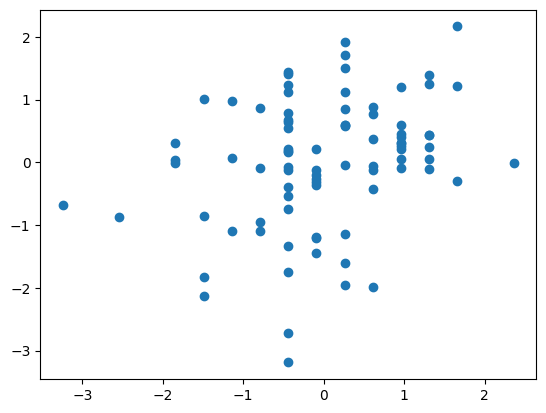

This is factor 39
globulin
globulin
MSE: 0.177
MAE: 0.106
SpearmanrResult(correlation=0.17534717836833846, pvalue=0.10846129274911336) [[1.         0.18566983]
 [0.18566983 1.        ]]


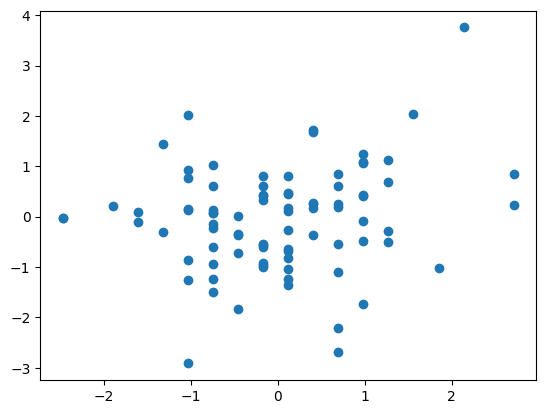

This is factor 40
bilirubin
bilirubin
MSE: 0.307
MAE: 0.138
SpearmanrResult(correlation=0.00013835423015168445, pvalue=0.998997317689011) [[1.        0.0426532]
 [0.0426532 1.       ]]


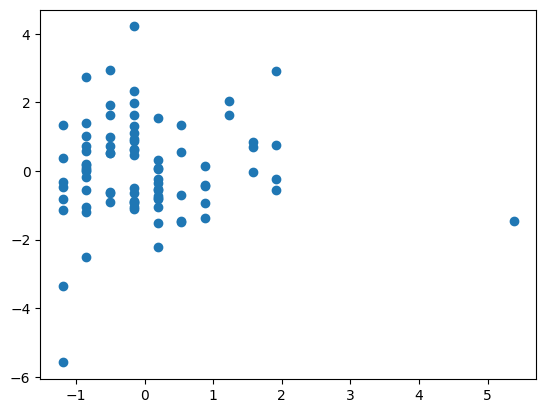

This is factor 41
alkaPhos
alkaPhos
MSE: 0.128
MAE: 0.088
SpearmanrResult(correlation=0.33631652217369373, pvalue=0.0016496456111364743) [[1.        0.3436323]
 [0.3436323 1.       ]]


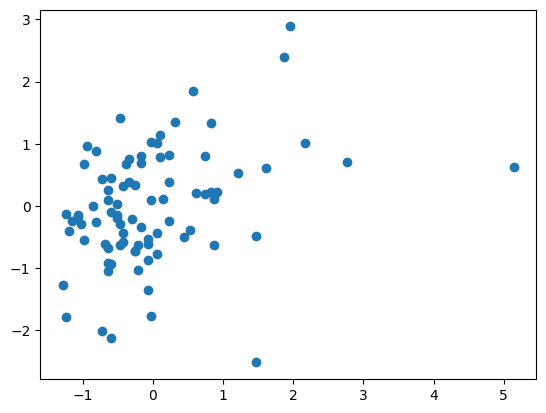

This is factor 42
AST
AST
MSE: 0.195
MAE: 0.086
SpearmanrResult(correlation=0.010402974676182408, pvalue=0.9247174341694032) [[ 1.         -0.07682067]
 [-0.07682067  1.        ]]


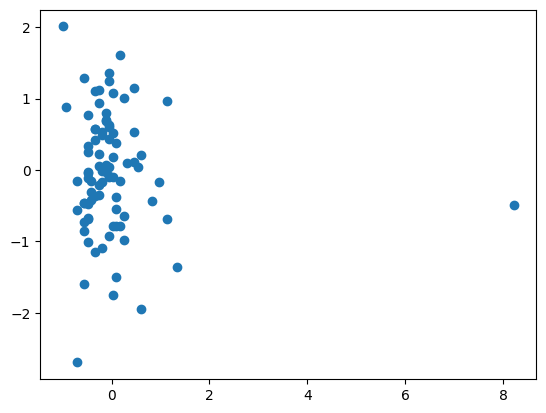

This is factor 43
ALT
ALT
MSE: 0.153
MAE: 0.076
SpearmanrResult(correlation=0.16686768631690382, pvalue=0.12691304893031194) [[1.        0.1051188]
 [0.1051188 1.       ]]


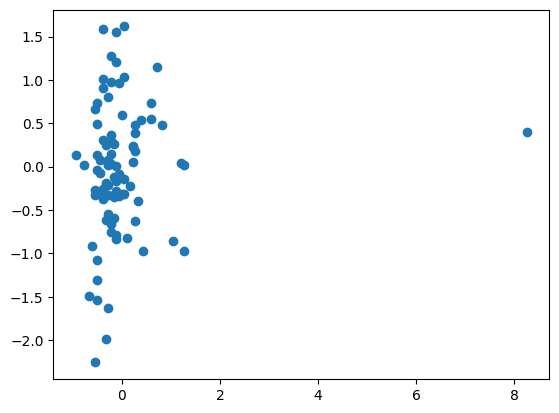

This is factor 44
chol
chol
MSE: 0.193
MAE: 0.117
SpearmanrResult(correlation=0.16399787140447453, pvalue=0.13367320067720886) [[1.         0.13726554]
 [0.13726554 1.        ]]


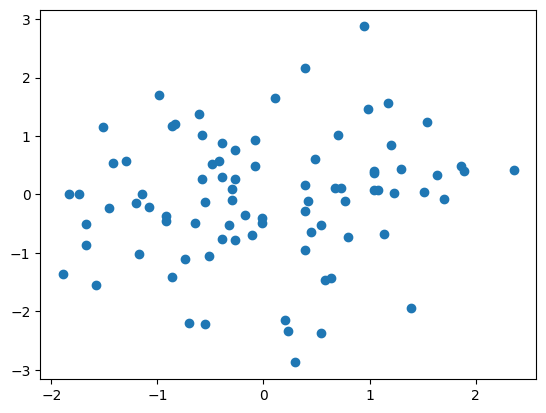

This is factor 45
A1C
A1C
MSE: 0.261
MAE: 0.132
SpearmanrResult(correlation=-0.12609723724831565, pvalue=0.25016745640800114) [[ 1.         -0.11694564]
 [-0.11694564  1.        ]]


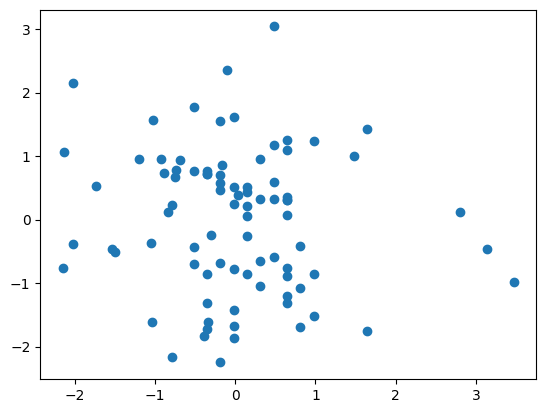

This is factor 46
cortisol
cortisol
MSE: 0.178
MAE: 0.107
SpearmanrResult(correlation=0.38001329320796706, pvalue=0.00033419710845481506) [[1.        0.3206168]
 [0.3206168 1.       ]]


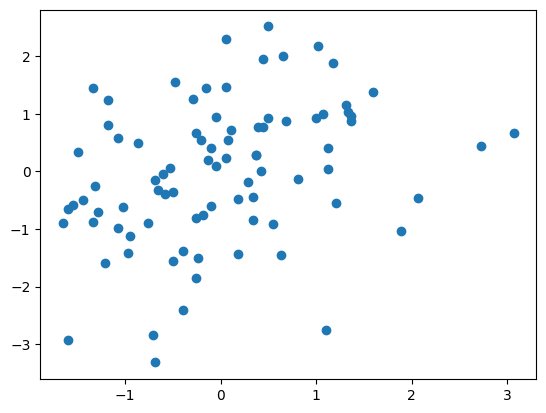

This is factor 47
TSH
TSH
MSE: 0.258
MAE: 0.107
SpearmanrResult(correlation=0.1282937007460098, pvalue=0.24194494779005787) [[1.         0.03514473]
 [0.03514473 1.        ]]


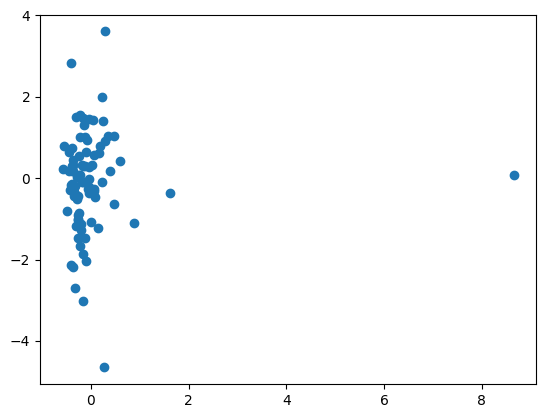

This is factor 48
calcitriol_vitD
calcitriol_vitD
MSE: 0.169
MAE: 0.098
SpearmanrResult(correlation=0.18613832410190448, pvalue=0.0880747455008345) [[1.         0.30940269]
 [0.30940269 1.        ]]


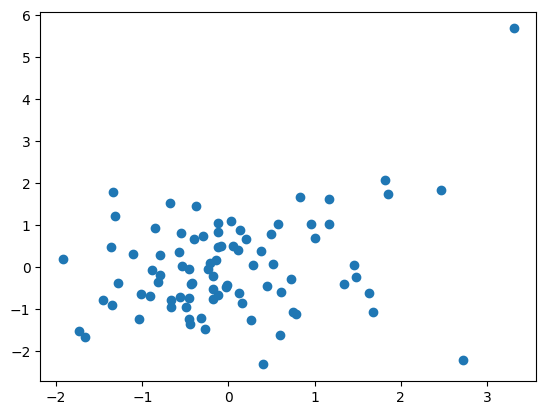

This is factor 49
CRP
CRP
MSE: 0.161
MAE: 0.090
SpearmanrResult(correlation=0.32691809749711354, pvalue=0.0022597252050940166) [[1.         0.26308321]
 [0.26308321 1.        ]]


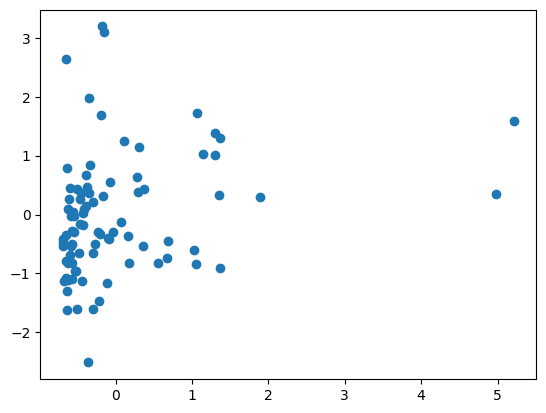

This is factor 50
B12
B12
MSE: 0.210
MAE: 0.115
SpearmanrResult(correlation=0.10703903305669486, pvalue=0.32953828465622215) [[1.         0.05351735]
 [0.05351735 1.        ]]


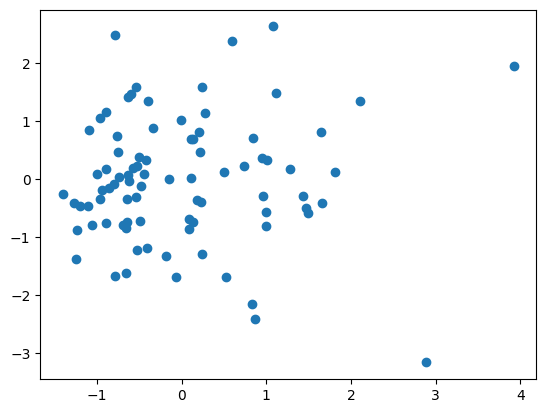

This is factor 51
insulin
insulin
MSE: 0.144
MAE: 0.091
SpearmanrResult(correlation=0.16844214551647566, pvalue=0.12331693500766819) [[1.         0.20944022]
 [0.20944022 1.        ]]


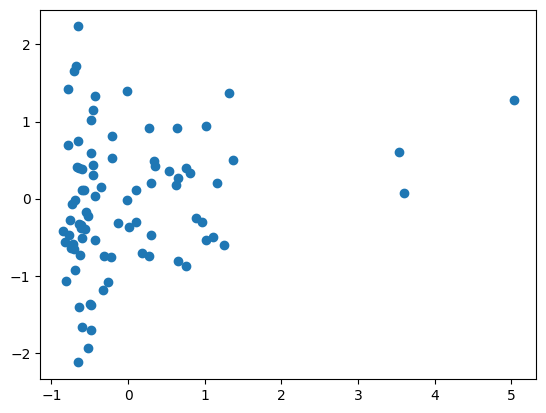

This is factor 52
freeT3
freeT3
MSE: 0.158
MAE: 0.091
SpearmanrResult(correlation=0.14538942605047062, pvalue=0.18429573954189976) [[1.         0.15356312]
 [0.15356312 1.        ]]


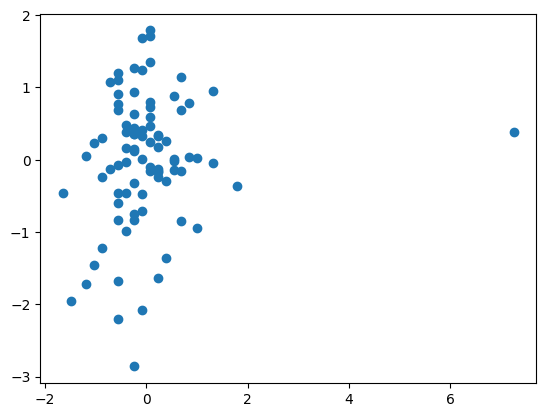

This is factor 53
vig_dayPerWeek
vig_dayPerWeek
MSE: 0.144
MAE: 0.103
SpearmanrResult(correlation=0.34770385556473166, pvalue=0.001111854501977663) [[1.         0.38907941]
 [0.38907941 1.        ]]


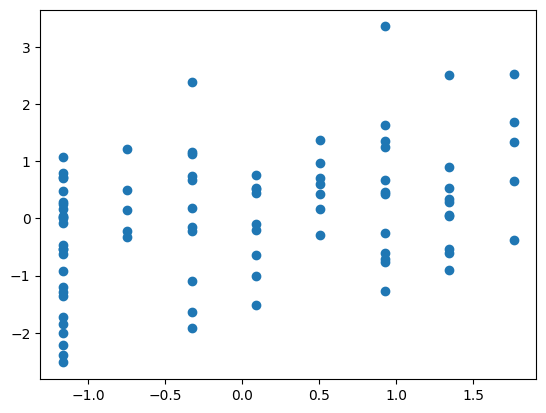

This is factor 54
vig_none
vig_none
MSE: 0.162
MAE: 0.106
SpearmanrResult(correlation=0.1799501592126677, pvalue=0.09935748548170258) [[1.        0.2439715]
 [0.2439715 1.       ]]


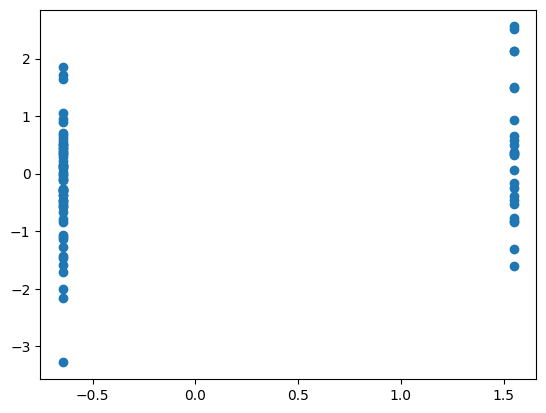

This is factor 55
vig_hourPerDay
vig_hourPerDay
MSE: 0.138
MAE: 0.096
SpearmanrResult(correlation=0.25300457515752833, pvalue=0.01948100846667251) [[1.         0.28474472]
 [0.28474472 1.        ]]


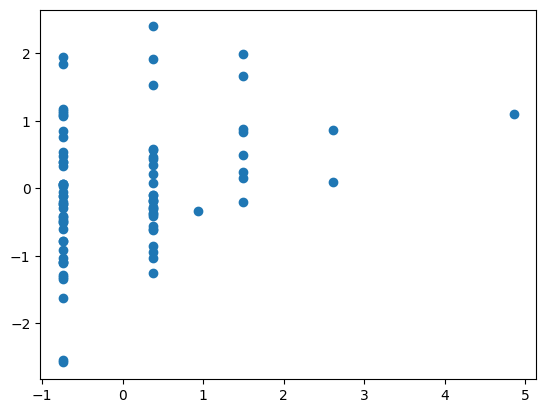

This is factor 56
vig_minPerDay
vig_minPerDay
MSE: 0.198
MAE: 0.114
SpearmanrResult(correlation=0.005836055417976879, pvalue=0.9577243031471181) [[ 1.         -0.01533831]
 [-0.01533831  1.        ]]


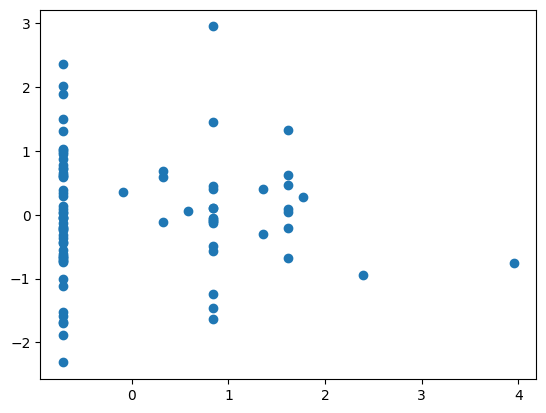

This is factor 57
mod_dayPerWeek
mod_dayPerWeek
MSE: 0.241
MAE: 0.133
SpearmanrResult(correlation=0.1345665951161438, pvalue=0.21949693223761205) [[1.         0.17847307]
 [0.17847307 1.        ]]


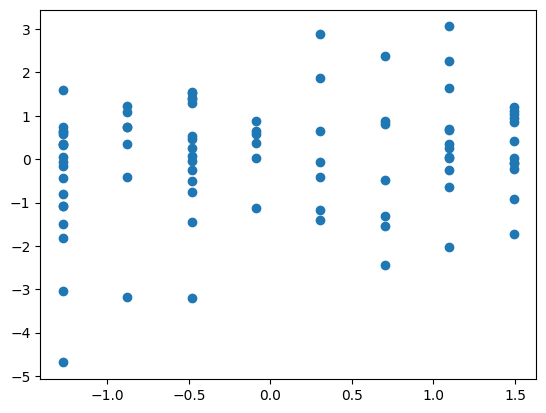

This is factor 58
mod_none
mod_none
MSE: 0.197
MAE: 0.116
SpearmanrResult(correlation=0.11850591761916722, pvalue=0.28005075230919496) [[1.         0.14682559]
 [0.14682559 1.        ]]


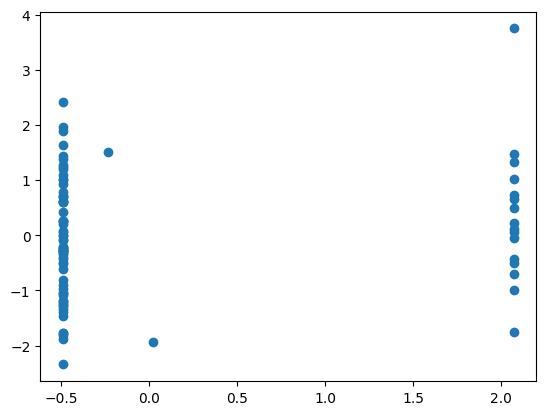

This is factor 59
mod_hourPerDay
mod_hourPerDay
MSE: 0.193
MAE: 0.109
SpearmanrResult(correlation=0.06753157450327055, pvalue=0.5391536058373052) [[1.         0.03762984]
 [0.03762984 1.        ]]


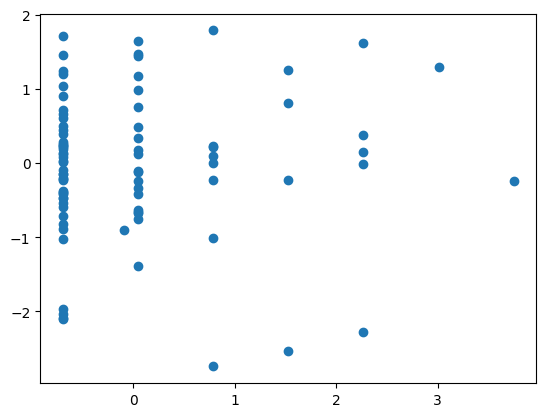

This is factor 60
mod_minPerDay
mod_minPerDay
MSE: 0.150
MAE: 0.097
SpearmanrResult(correlation=0.23021907373211403, pvalue=0.03403563499748513) [[1.         0.29549927]
 [0.29549927 1.        ]]


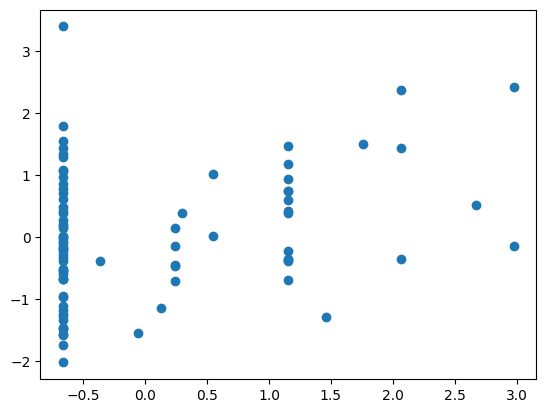

This is factor 61
walk_dayPerWeek
walk_dayPerWeek
MSE: 0.227
MAE: 0.125
SpearmanrResult(correlation=-0.08032835524527066, pvalue=0.4648967123027038) [[ 1.        -0.0191191]
 [-0.0191191  1.       ]]


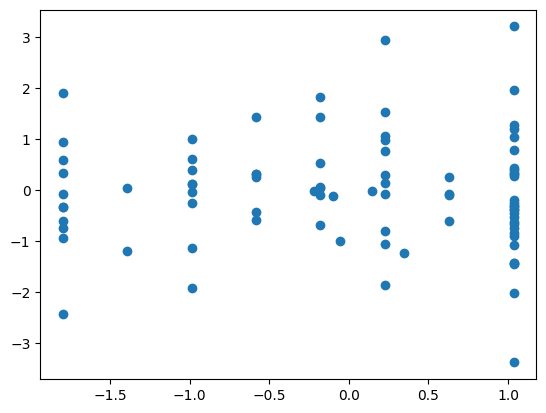

This is factor 62
walk_none
walk_none
MSE: 0.231
MAE: 0.122
SpearmanrResult(correlation=0.025713551051893543, pvalue=0.8152988434954966) [[1.        0.0283227]
 [0.0283227 1.       ]]


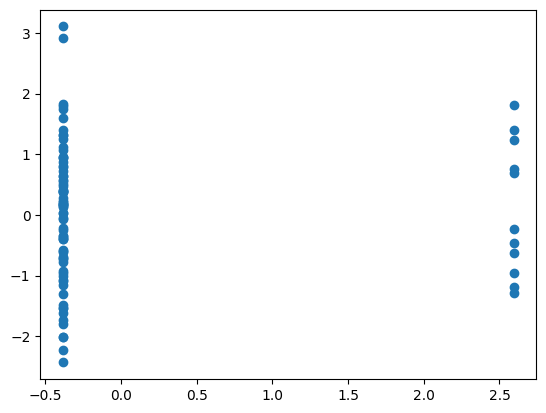

This is factor 63
walk_hourPerDay
walk_hourPerDay
MSE: 0.158
MAE: 0.104
SpearmanrResult(correlation=0.2671198777918164, pvalue=0.01346066000277614) [[1.         0.27239454]
 [0.27239454 1.        ]]


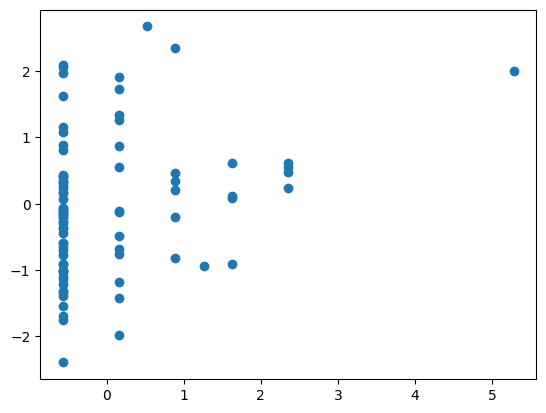

This is factor 64
walk_minPerDay
walk_minPerDay
MSE: 0.218
MAE: 0.127
SpearmanrResult(correlation=-0.017869052277297195, pvalue=0.8710552917937768) [[1.        0.0708497]
 [0.0708497 1.       ]]


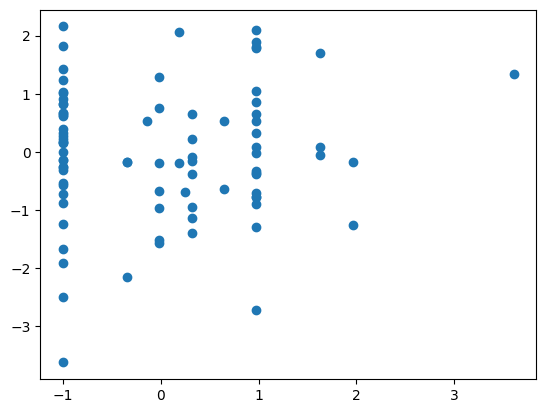

This is factor 65
sit_hourPerDay
sit_hourPerDay
MSE: 0.210
MAE: 0.120
SpearmanrResult(correlation=0.23488410248586075, pvalue=0.03047733174865443) [[1.         0.24797769]
 [0.24797769 1.        ]]


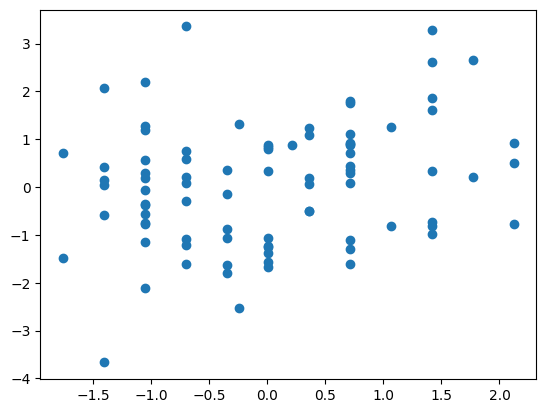

This is factor 66
vigorous
vigorous
MSE: 0.137
MAE: 0.093
SpearmanrResult(correlation=0.27241929195135317, pvalue=0.011659237253855943) [[1.         0.29781536]
 [0.29781536 1.        ]]


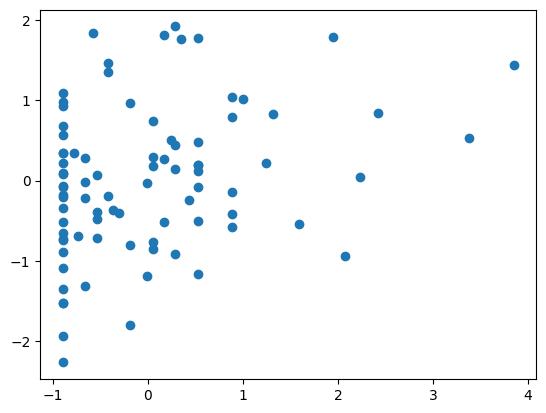

This is factor 67
moderate
moderate
MSE: 0.155
MAE: 0.101
SpearmanrResult(correlation=0.12172284121195057, pvalue=0.267108728705236) [[1.        0.2617104]
 [0.2617104 1.       ]]


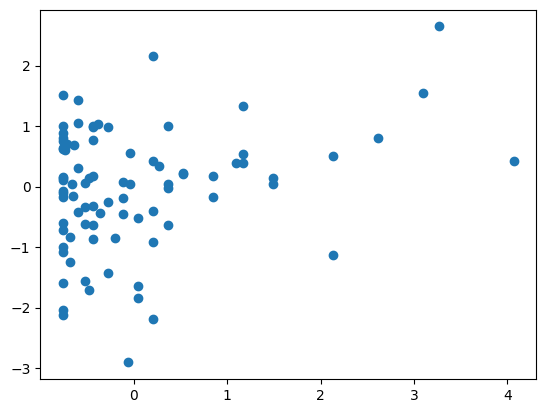

This is factor 68
walking
walking
MSE: 0.184
MAE: 0.106
SpearmanrResult(correlation=0.10366273316109859, pvalue=0.34510878535936795) [[1.         0.14789845]
 [0.14789845 1.        ]]


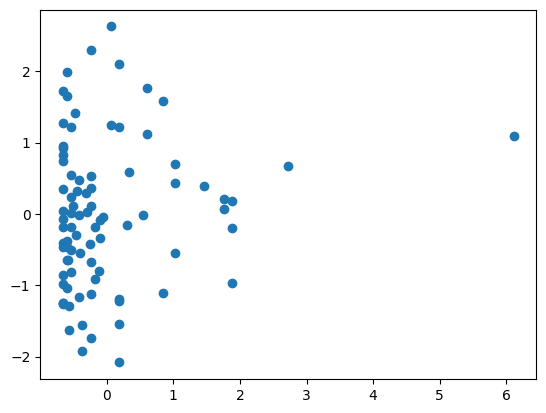

This is factor 69
METS_minPerWeek
METS_minPerWeek
MSE: 0.166
MAE: 0.101
SpearmanrResult(correlation=0.12480395565091353, pvalue=0.25509750854836033) [[1.         0.11548299]
 [0.11548299 1.        ]]


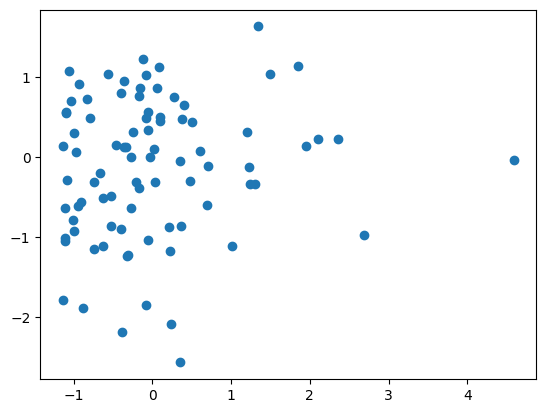

This is factor 70
PAfitness
PAfitness
MSE: 0.139
MAE: 0.098
SpearmanrResult(correlation=0.3123273806057752, pvalue=0.0036136681506953637) [[1.         0.30959758]
 [0.30959758 1.        ]]


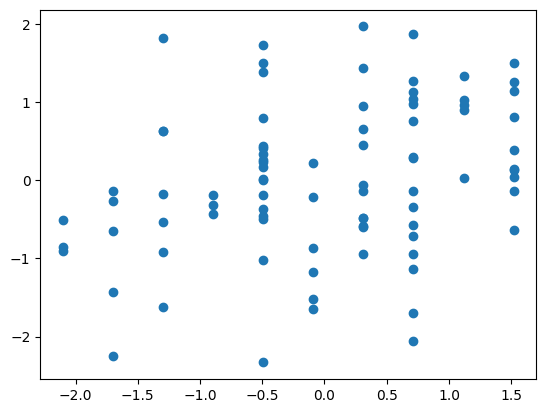

This is factor 71
PAfrequency
PAfrequency
MSE: 0.135
MAE: 0.096
SpearmanrResult(correlation=0.3932301735904571, pvalue=0.00019696171654980801) [[1.         0.43023044]
 [0.43023044 1.        ]]


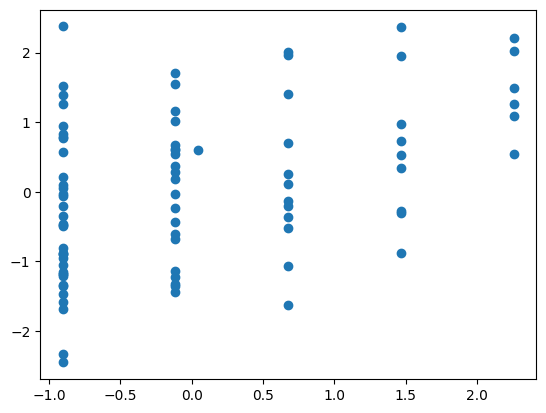

This is factor 72
PAwork
PAwork
MSE: 0.168
MAE: 0.103
SpearmanrResult(correlation=0.15713829424338482, pvalue=0.15093625516990616) [[1.         0.19377577]
 [0.19377577 1.        ]]


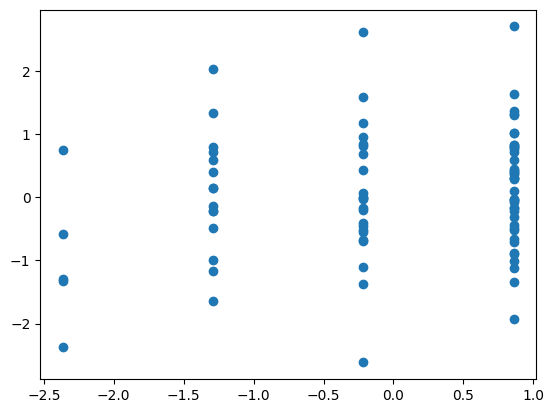

This is factor 73
PAyears
PAyears
MSE: 0.172
MAE: 0.108
SpearmanrResult(correlation=0.2668086431494153, pvalue=0.013573583683755901) [[1.         0.30101747]
 [0.30101747 1.        ]]


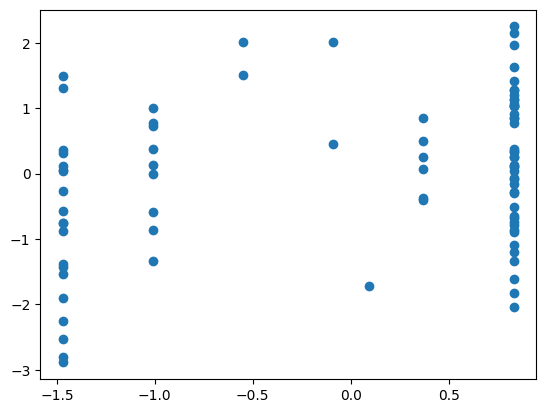

This is factor 74
edu
edu
MSE: 0.162
MAE: 0.101
SpearmanrResult(correlation=0.35855166875478944, pvalue=0.0007530135280554828) [[1.         0.35658702]
 [0.35658702 1.        ]]


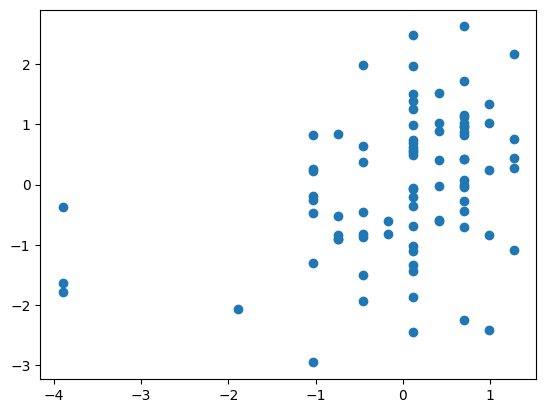

This is factor 75
marital
marital
MSE: 0.150
MAE: 0.098
SpearmanrResult(correlation=0.4890368730611899, pvalue=2.0441316495454612e-06) [[1.         0.45532546]
 [0.45532546 1.        ]]


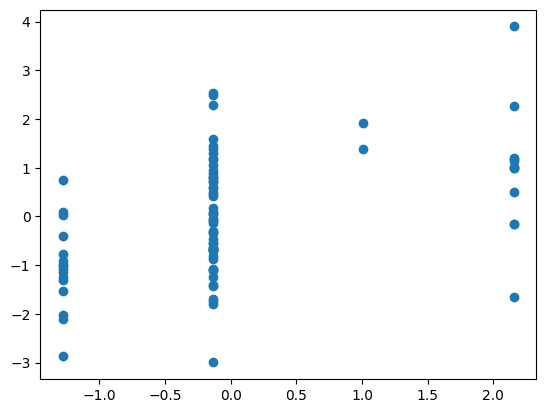

This is factor 76
race
race
MSE: 0.164
MAE: 0.100
SpearmanrResult(correlation=0.3022070901458292, pvalue=0.004938715888351006) [[1.         0.32379615]
 [0.32379615 1.        ]]


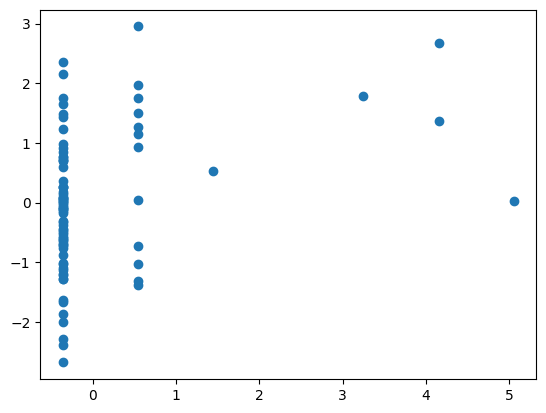

This is factor 77
job
job
MSE: 0.225
MAE: 0.123
SpearmanrResult(correlation=0.15387585500178286, pvalue=0.15970945573782344) [[1.         0.13142817]
 [0.13142817 1.        ]]


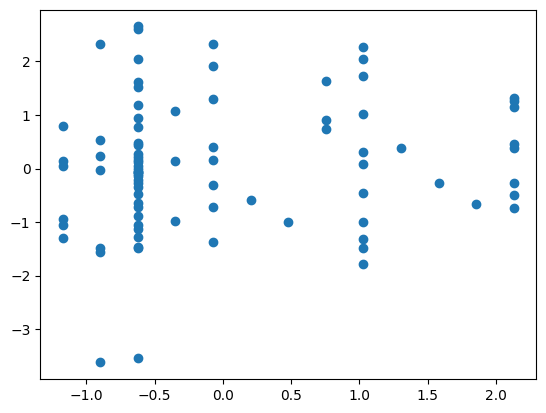

This is factor 78
chronicDisRisk01
chronicDisRisk01
MSE: 0.195
MAE: 0.117
SpearmanrResult(correlation=0.2553307628344309, pvalue=0.018353228899796847) [[1.         0.26225191]
 [0.26225191 1.        ]]


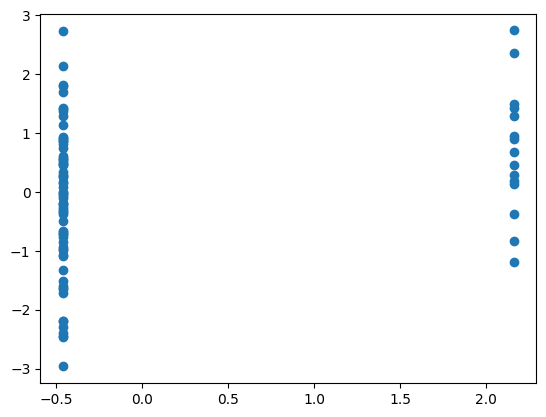

This is factor 79
chronicDisRisk04
chronicDisRisk04
MSE: 0.227
MAE: 0.122
SpearmanrResult(correlation=0.2804955666351798, pvalue=0.009317667213206343) [[1.         0.26741511]
 [0.26741511 1.        ]]


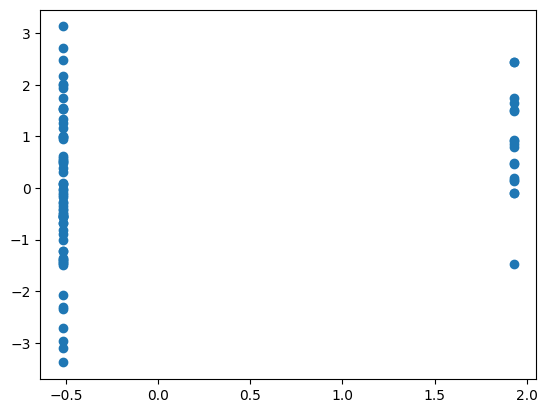

This is factor 80
chronicDisRisk07
chronicDisRisk07
MSE: 0.133
MAE: 0.095
SpearmanrResult(correlation=0.3032797116509166, pvalue=0.004780293399924161) [[1.         0.33758334]
 [0.33758334 1.        ]]


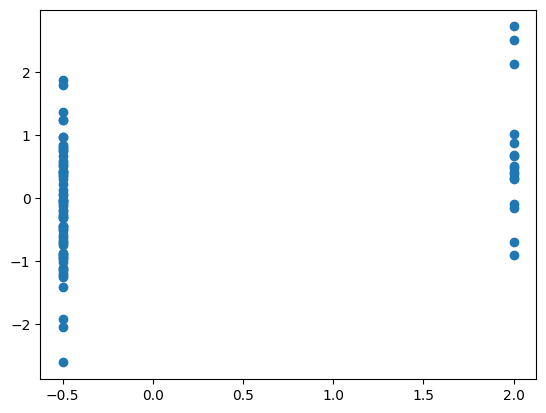

This is factor 81
chronicDisRisk08
chronicDisRisk08
MSE: 0.297
MAE: 0.139
SpearmanrResult(correlation=0.11012929077498058, pvalue=0.315685086521944) [[1.         0.09606431]
 [0.09606431 1.        ]]


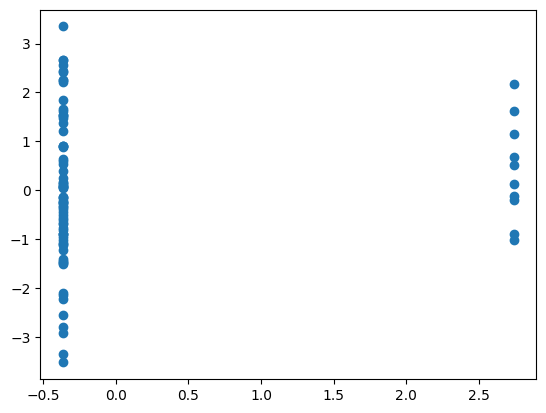

This is factor 82
chronicDisRisk09
chronicDisRisk09
MSE: 0.198
MAE: 0.111
SpearmanrResult(correlation=0.3233966550321104, pvalue=0.0025361612240851457) [[1.         0.30259122]
 [0.30259122 1.        ]]


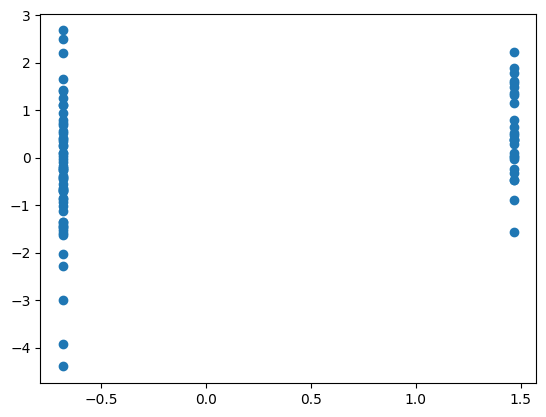

This is factor 83
chronicDisRisk11
chronicDisRisk11
MSE: 0.161
MAE: 0.100
SpearmanrResult(correlation=0.2891688194596297, pvalue=0.007271828745590901) [[1.         0.24693195]
 [0.24693195 1.        ]]


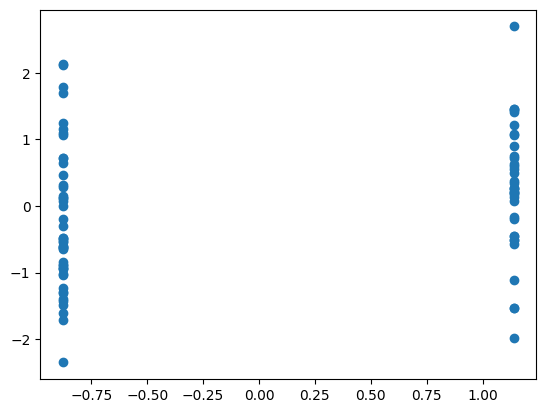

This is factor 84
medhist3
medhist3
MSE: 0.183
MAE: 0.105
SpearmanrResult(correlation=0.3054334268175894, pvalue=0.004475767344205858) [[1.         0.24906418]
 [0.24906418 1.        ]]


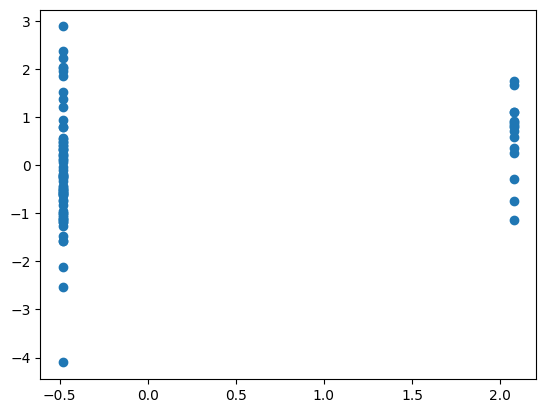

This is factor 85
medhist27
medhist27
MSE: 0.277
MAE: 0.135
SpearmanrResult(correlation=0.27147375925728084, pvalue=0.011964347249695537) [[1.        0.2127142]
 [0.2127142 1.       ]]


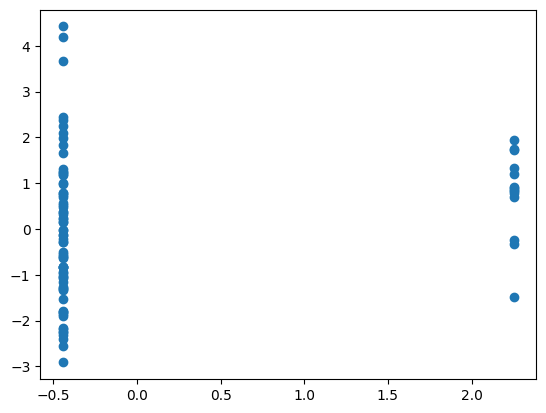

This is factor 86
medhist42
medhist42
MSE: 0.162
MAE: 0.102
SpearmanrResult(correlation=0.22247453163783798, pvalue=0.04071037236749736) [[1.         0.29665625]
 [0.29665625 1.        ]]


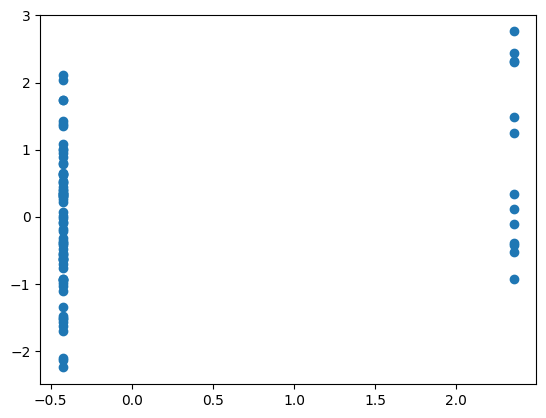

This is factor 87
meds13
meds13
MSE: 0.180
MAE: 0.112
SpearmanrResult(correlation=0.18873889929315715, pvalue=0.08364695242130032) [[1.         0.20484213]
 [0.20484213 1.        ]]


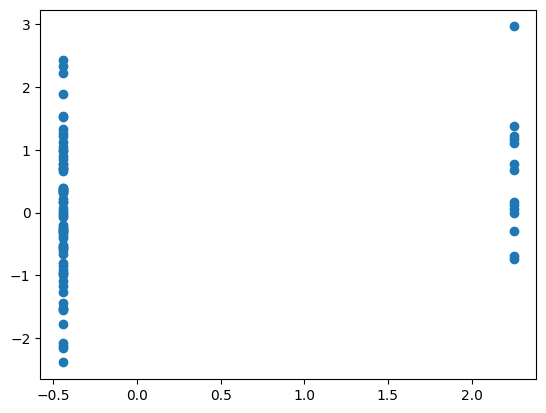

This is factor 88
fruit
fruit
MSE: 0.191
MAE: 0.113
SpearmanrResult(correlation=0.17407853425004713, pvalue=0.11108101298333165) [[1.         0.27302939]
 [0.27302939 1.        ]]


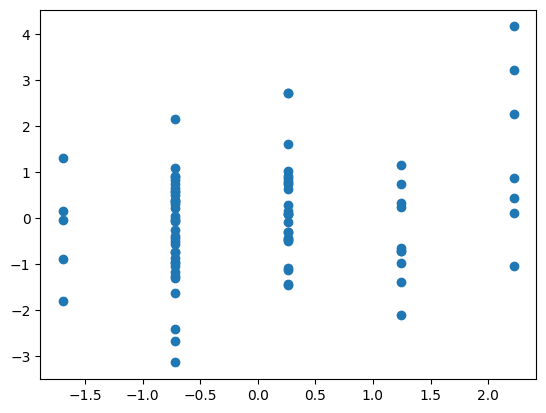

This is factor 89
veg
veg
MSE: 0.123
MAE: 0.094
SpearmanrResult(correlation=0.23259732927286508, pvalue=0.03218030856098002) [[1.         0.36879242]
 [0.36879242 1.        ]]


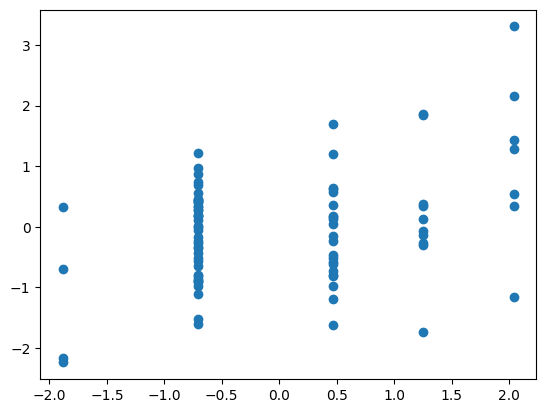

This is factor 90
fruitplusveg
fruitplusveg
MSE: 0.132
MAE: 0.092
SpearmanrResult(correlation=0.2008581261639095, pvalue=0.06529474673911725) [[1.         0.29866037]
 [0.29866037 1.        ]]


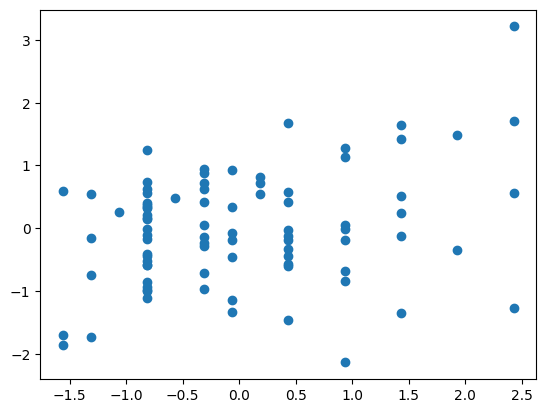

This is factor 91
cereal
cereal
MSE: 0.226
MAE: 0.123
SpearmanrResult(correlation=0.19962571472092416, pvalue=0.06699746537333723) [[1.         0.18204309]
 [0.18204309 1.        ]]


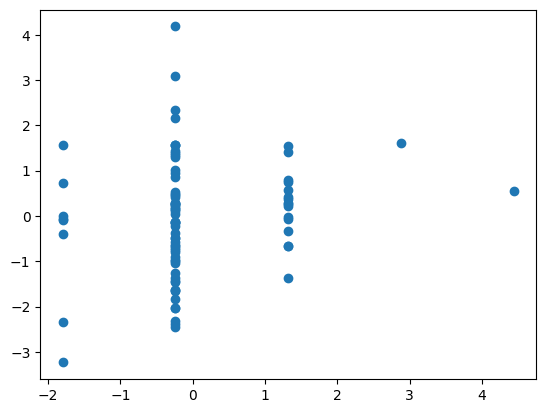

This is factor 92
fiber
fiber
MSE: 0.263
MAE: 0.131
SpearmanrResult(correlation=0.029305595751821074, pvalue=0.7900536307871935) [[1.         0.02760441]
 [0.02760441 1.        ]]


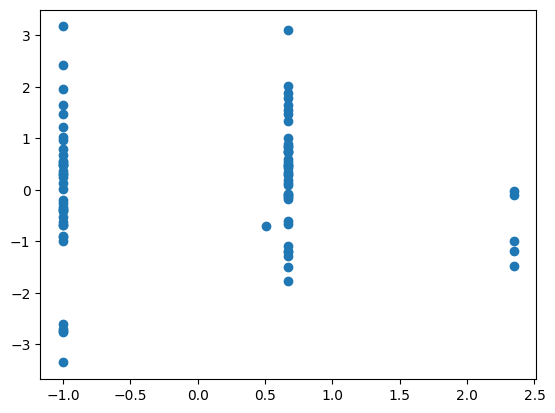

This is factor 93
redmeat
redmeat
MSE: 0.192
MAE: 0.107
SpearmanrResult(correlation=0.33146777155237084, pvalue=0.001942795572560106) [[1.         0.27189825]
 [0.27189825 1.        ]]


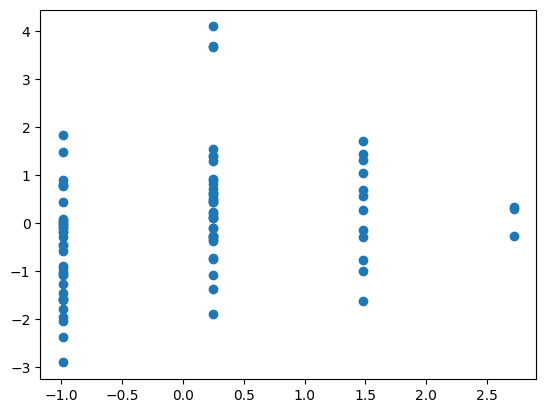

This is factor 94
leanmeat
leanmeat
MSE: 0.202
MAE: 0.115
SpearmanrResult(correlation=0.1626572997352079, pvalue=0.13692326549798092) [[1.         0.19233462]
 [0.19233462 1.        ]]


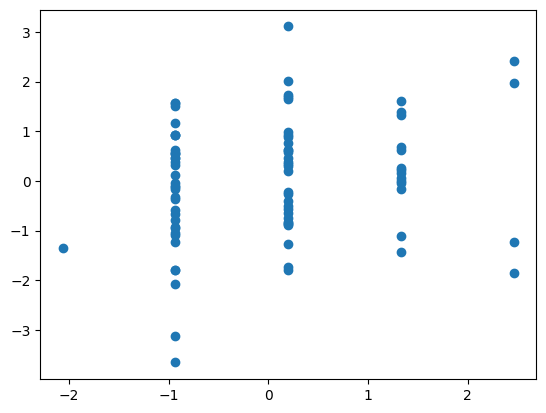

This is factor 95
dairy
dairy
MSE: 0.154
MAE: 0.101
SpearmanrResult(correlation=0.1974647634163306, pvalue=0.07006957330783964) [[1.        0.3513748]
 [0.3513748 1.       ]]


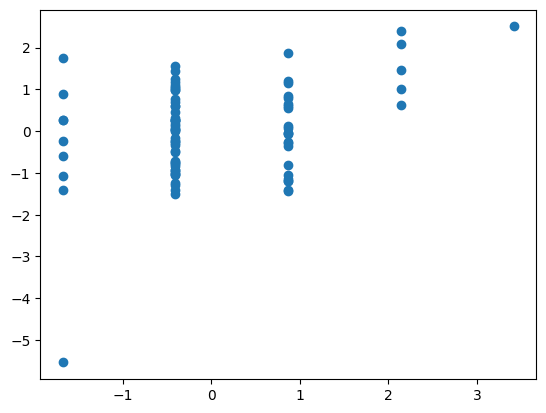

This is factor 96
dairyfat
dairyfat
MSE: 0.171
MAE: 0.106
SpearmanrResult(correlation=0.22066032429529994, pvalue=0.0424222808468218) [[1.         0.23328386]
 [0.23328386 1.        ]]


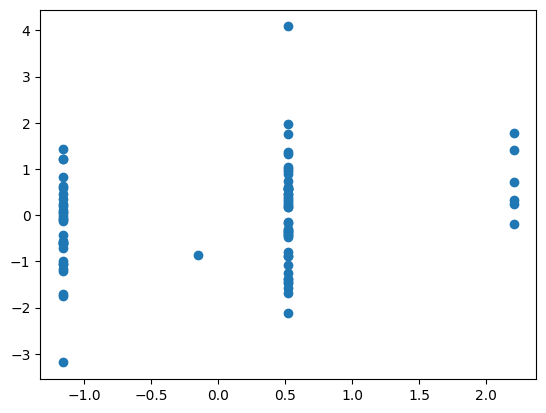

This is factor 97
fatandoils
fatandoils
MSE: 0.151
MAE: 0.100
SpearmanrResult(correlation=0.3732170225046254, pvalue=0.0004348735899753494) [[1.         0.35072403]
 [0.35072403 1.        ]]


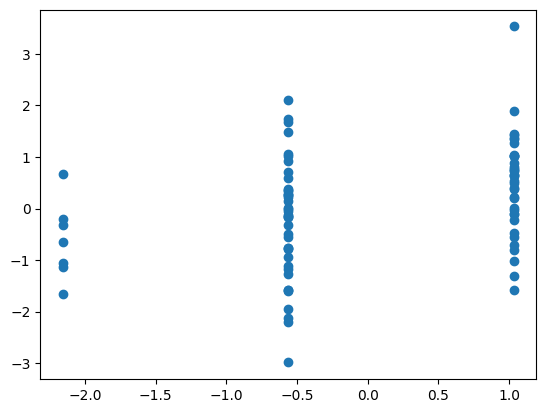

This is factor 98
mostweight
mostweight
MSE: 0.143
MAE: 0.096
SpearmanrResult(correlation=0.3839443447467819, pvalue=0.0002862289220601335) [[1.         0.41292883]
 [0.41292883 1.        ]]


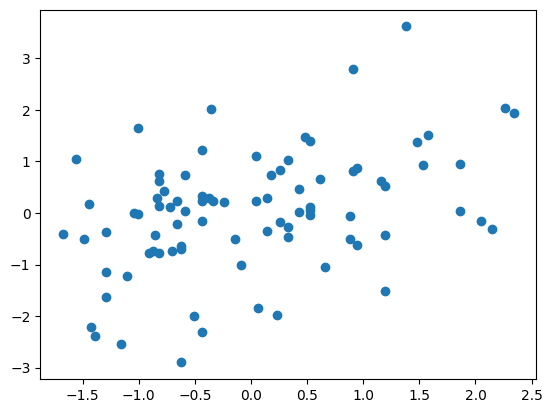

This is factor 99
idealweight
idealweight
MSE: 0.108
MAE: 0.087
SpearmanrResult(correlation=0.539226976994748, pvalue=1.012516683892115e-07) [[1.         0.55353975]
 [0.55353975 1.        ]]


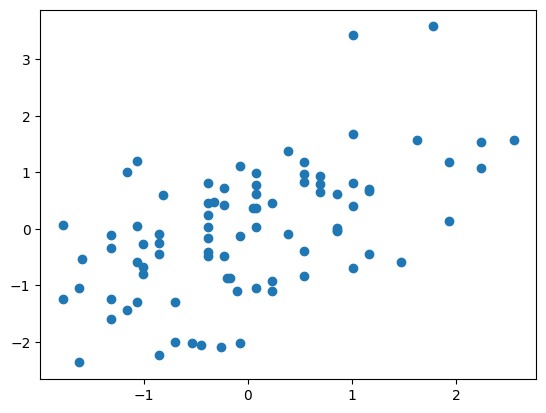

This is factor 100
weightloss
weightloss
MSE: 0.144
MAE: 0.094
SpearmanrResult(correlation=0.3067319224121056, pvalue=0.004300618925728495) [[1.         0.29966652]
 [0.29966652 1.        ]]


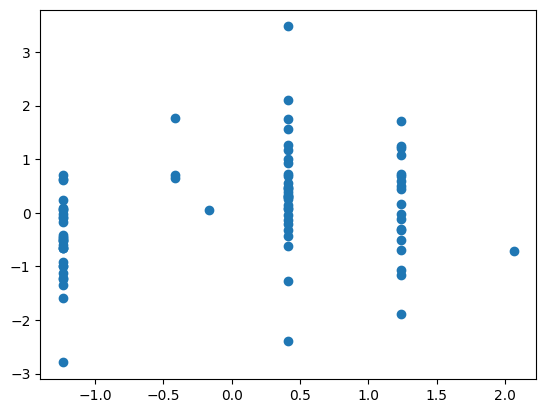

This is factor 101
spirit
spirit
MSE: 0.177
MAE: 0.107
SpearmanrResult(correlation=0.15706949218399005, pvalue=0.15111747335581707) [[1.         0.17993493]
 [0.17993493 1.        ]]


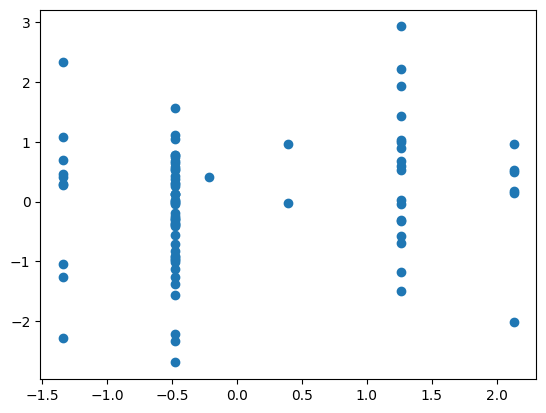

This is factor 102
stress
stress
MSE: 0.197
MAE: 0.119
SpearmanrResult(correlation=-0.05134333729327081, pvalue=0.6407421535946041) [[ 1.         -0.03693641]
 [-0.03693641  1.        ]]


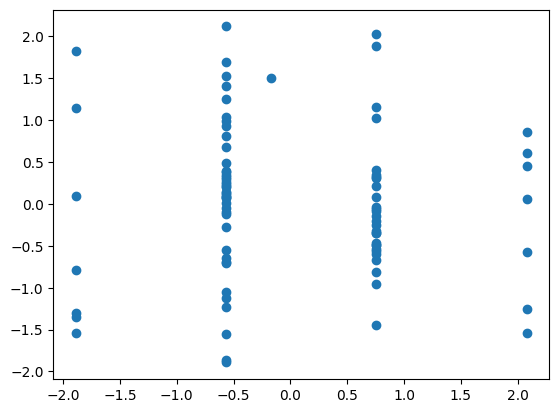

This is factor 103
sthlth
sthlth
MSE: 0.355
MAE: 0.147
SpearmanrResult(correlation=-0.32454659542772296, pvalue=0.002442721800896234) [[ 1.         -0.35792074]
 [-0.35792074  1.        ]]


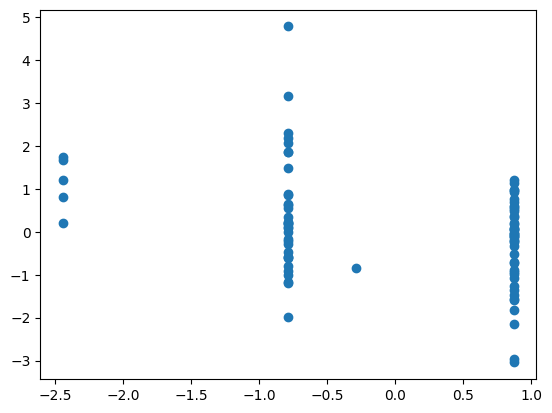

This is factor 104
sleep
sleep
MSE: 0.175
MAE: 0.107
SpearmanrResult(correlation=0.2922019944841475, pvalue=0.006656138050688787) [[1.        0.2609171]
 [0.2609171 1.       ]]


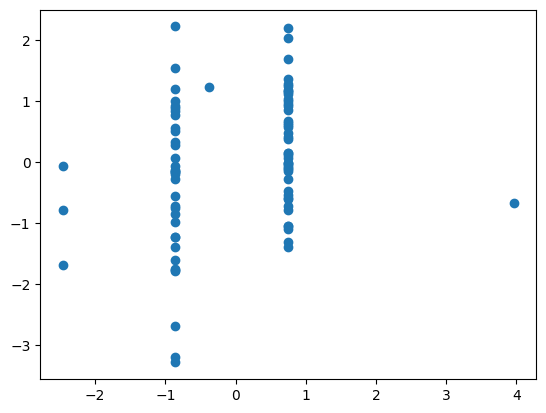

This is factor 105
upset
upset
MSE: 0.224
MAE: 0.127
SpearmanrResult(correlation=0.13541943078903404, pvalue=0.21656228821142928) [[1.         0.12565777]
 [0.12565777 1.        ]]


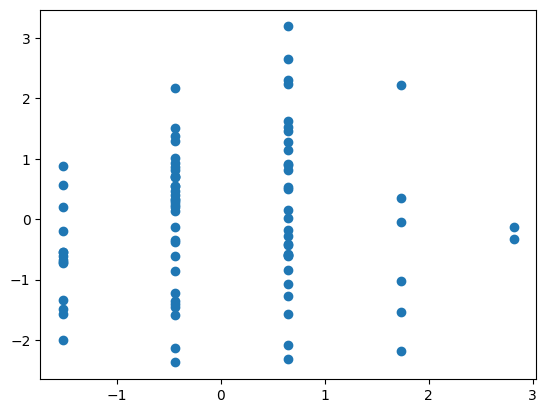

This is factor 106
control
control
MSE: 0.257
MAE: 0.127
SpearmanrResult(correlation=0.016673982125977333, pvalue=0.8796121576811353) [[ 1.         -0.03066363]
 [-0.03066363  1.        ]]


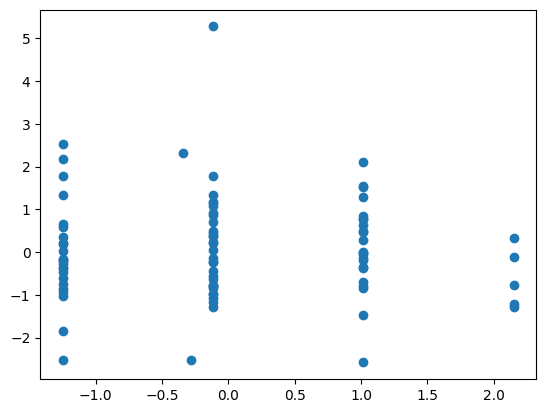

This is factor 107
nerve
nerve
MSE: 0.197
MAE: 0.116
SpearmanrResult(correlation=0.07166214399959642, pvalue=0.5145633750877638) [[1.        0.0866395]
 [0.0866395 1.       ]]


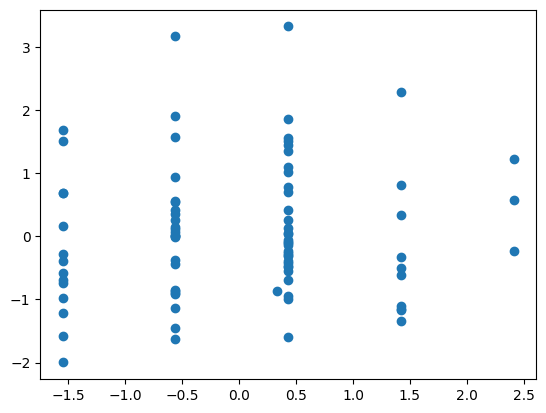

This is factor 108
confid
confid
MSE: 0.283
MAE: 0.138
SpearmanrResult(correlation=-0.06615154071400131, pvalue=0.547496162473991) [[ 1.         -0.00205172]
 [-0.00205172  1.        ]]


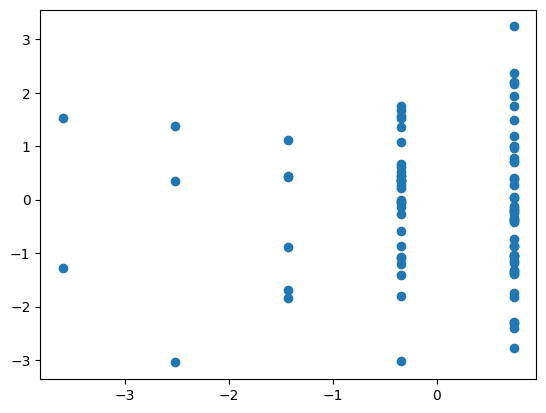

This is factor 109
feel
feel
MSE: 0.215
MAE: 0.122
SpearmanrResult(correlation=0.07803477195758998, pvalue=0.47778089414526204) [[1.         0.09961935]
 [0.09961935 1.        ]]


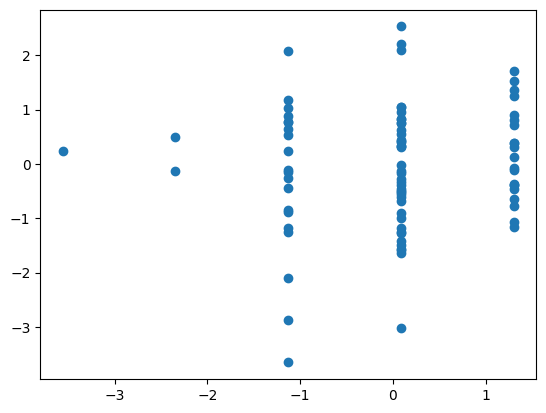

This is factor 110
cope
cope
MSE: 0.211
MAE: 0.118
SpearmanrResult(correlation=0.07430925218323854, pvalue=0.49911112780302413) [[1.         0.08565643]
 [0.08565643 1.        ]]


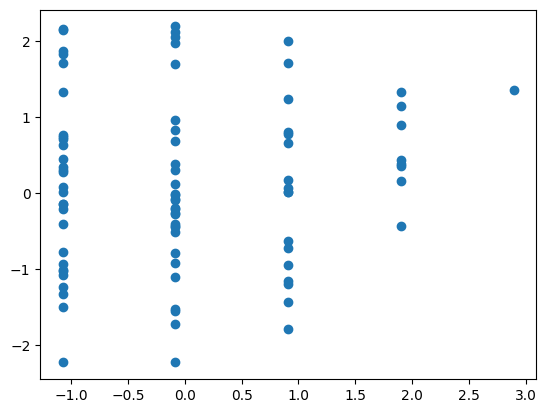

This is factor 111
irrit
irrit
MSE: 0.171
MAE: 0.103
SpearmanrResult(correlation=0.21023526359651798, pvalue=0.05345620472673358) [[1.        0.2480495]
 [0.2480495 1.       ]]


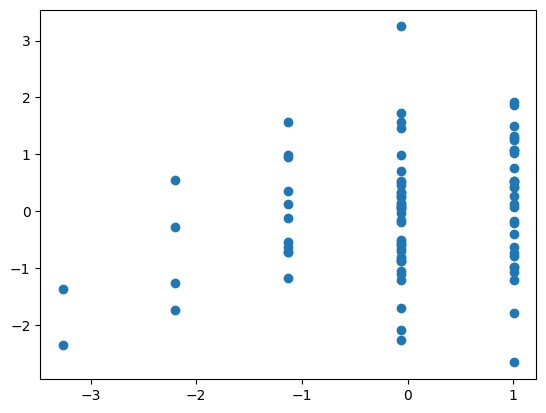

This is factor 112
top
top
MSE: 0.196
MAE: 0.120
SpearmanrResult(correlation=0.24095382223969483, pvalue=0.02632171762625839) [[1.         0.27920002]
 [0.27920002 1.        ]]


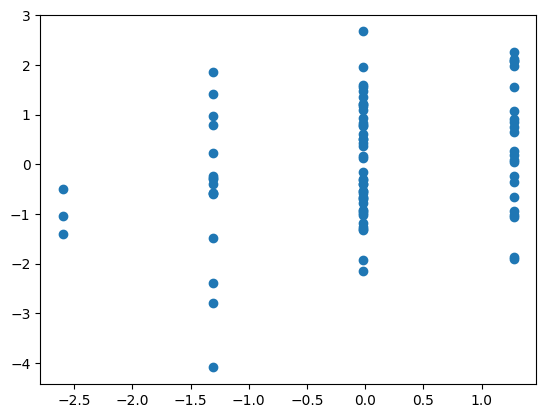

This is factor 113
angry
angry
MSE: 0.159
MAE: 0.109
SpearmanrResult(correlation=0.17630734547133753, pvalue=0.1065106773247599) [[1.         0.18832518]
 [0.18832518 1.        ]]


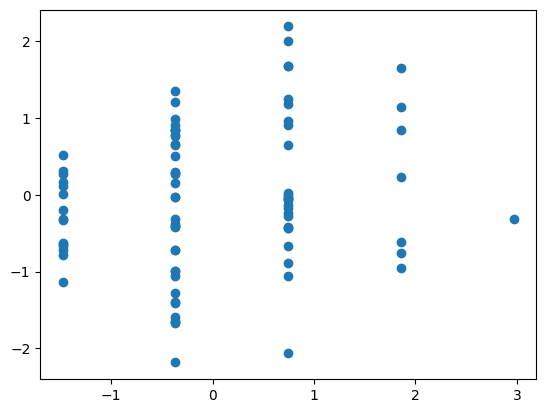

This is factor 114
piling
piling
MSE: 0.222
MAE: 0.125
SpearmanrResult(correlation=0.04285204214647549, pvalue=0.6969761166778718) [[1.         0.06854673]
 [0.06854673 1.        ]]


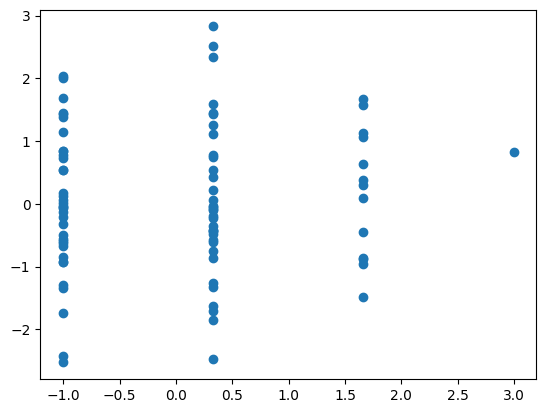

This is factor 115
night
night
MSE: 0.251
MAE: 0.127
SpearmanrResult(correlation=-0.2440423749878777, pvalue=0.02439861418360666) [[ 1.         -0.01328703]
 [-0.01328703  1.        ]]


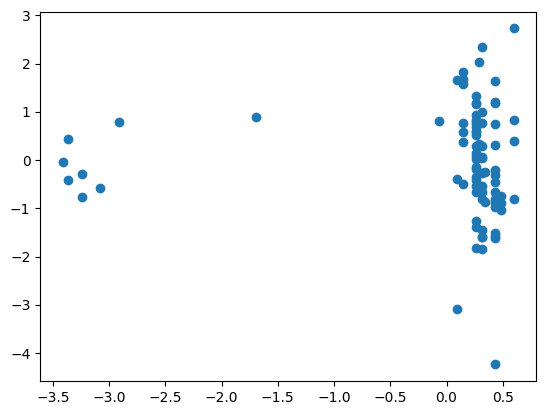

This is factor 116
morn
morn
MSE: 0.160
MAE: 0.094
SpearmanrResult(correlation=0.17525769730391982, pvalue=0.10864448127465837) [[1.        0.2651927]
 [0.2651927 1.       ]]


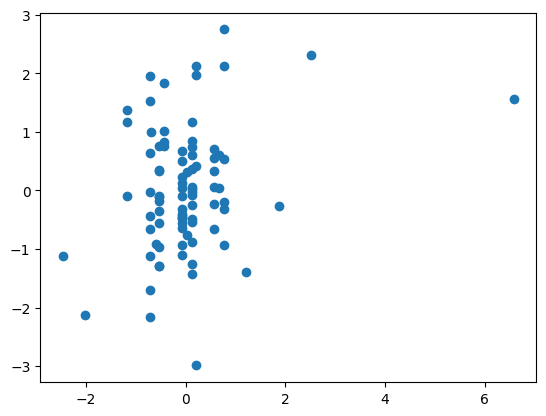

This is factor 117
fall
fall
MSE: 0.239
MAE: 0.119
SpearmanrResult(correlation=0.20336400922158973, pvalue=0.06194061980584244) [[1.         0.14564513]
 [0.14564513 1.        ]]


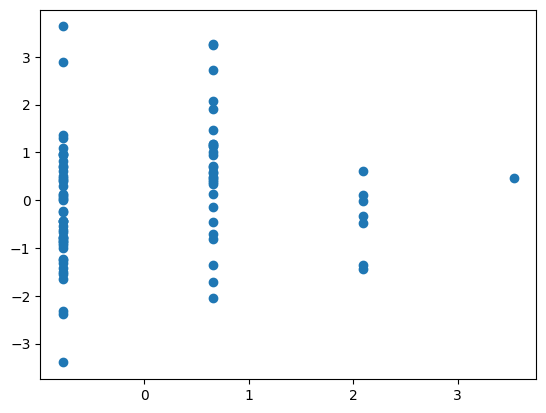

This is factor 118
back
back
MSE: 0.256
MAE: 0.130
SpearmanrResult(correlation=0.0482505102749461, pvalue=0.661011761093222) [[1.         0.10321666]
 [0.10321666 1.        ]]


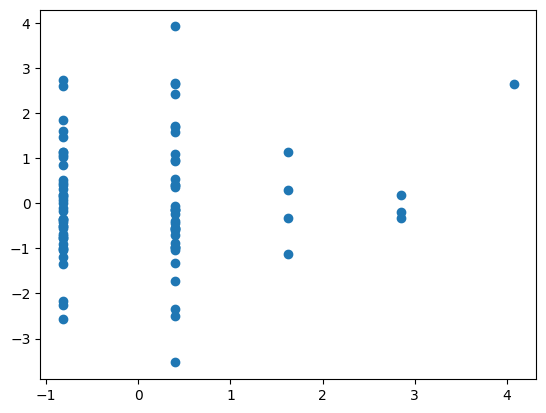

This is factor 119
unable
unable
MSE: 0.224
MAE: 0.118
SpearmanrResult(correlation=0.21077924460209935, pvalue=0.052827371691780554) [[1.         0.18581287]
 [0.18581287 1.        ]]


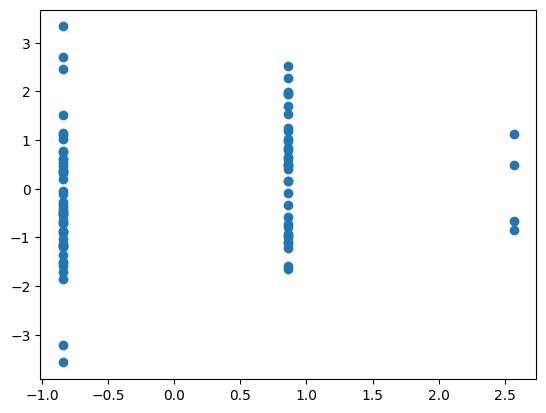

This is factor 120
sleeppil
sleeppil
MSE: 0.191
MAE: 0.107
SpearmanrResult(correlation=0.29729064779283293, pvalue=0.005726076858020741) [[1.         0.26879866]
 [0.26879866 1.        ]]


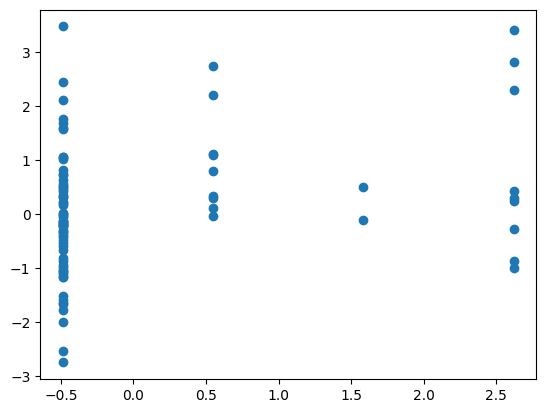

This is factor 121
cigs
cigs
MSE: 0.172
MAE: 0.107
SpearmanrResult(correlation=0.17369599942262182, pvalue=0.11188048543250359) [[1.         0.16736882]
 [0.16736882 1.        ]]


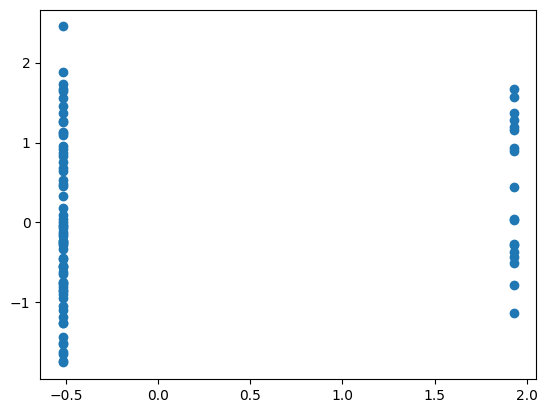

This is factor 122
cigsHabit
cigsHabit
MSE: 0.191
MAE: 0.108
SpearmanrResult(correlation=0.11683684856337355, pvalue=0.2869277343222162) [[1.         0.11806997]
 [0.11806997 1.        ]]


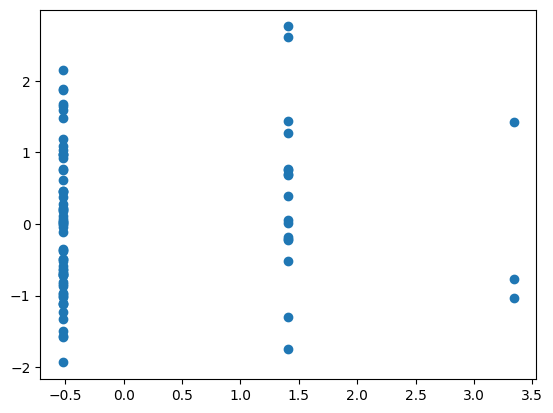

This is factor 123
cigYears
cigYears
MSE: 0.176
MAE: 0.106
SpearmanrResult(correlation=0.2508122533063174, pvalue=0.020597781393420184) [[1.        0.2421714]
 [0.2421714 1.       ]]


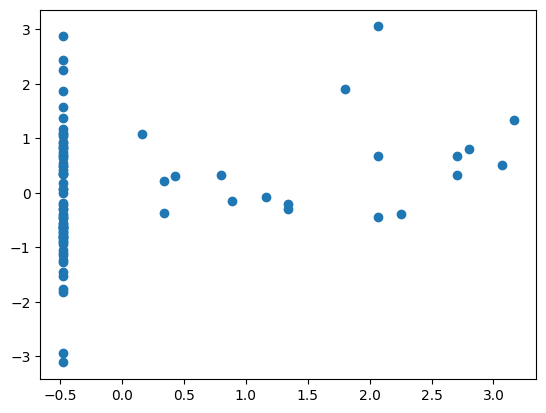

This is factor 124
alc
alc
MSE: 0.232
MAE: 0.126
SpearmanrResult(correlation=0.010929227325069402, pvalue=0.9209211056686358) [[1.         0.00303933]
 [0.00303933 1.        ]]


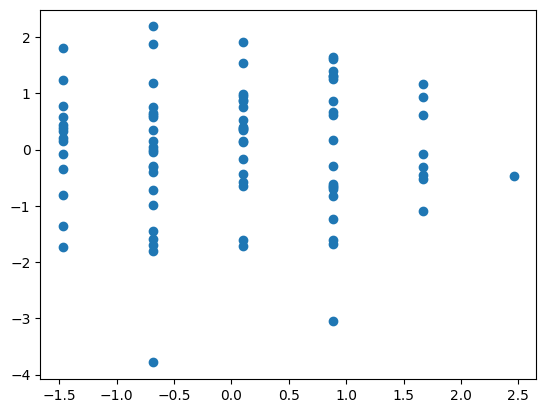

This is factor 125
supp01
supp01
MSE: 0.147
MAE: 0.103
SpearmanrResult(correlation=0.2379114701908659, pvalue=0.028340269851857947) [[1.         0.25687685]
 [0.25687685 1.        ]]


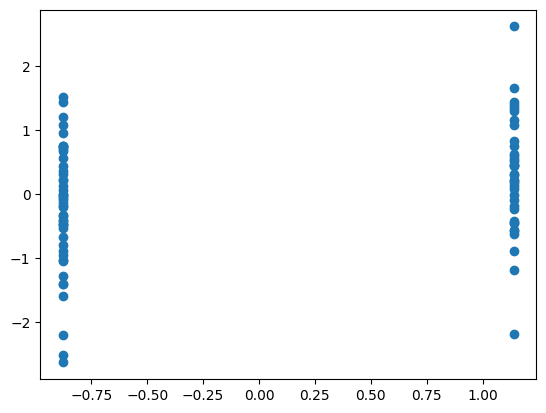

This is factor 126
supp02
supp02
MSE: 0.151
MAE: 0.099
SpearmanrResult(correlation=0.2859595745634445, pvalue=0.007977361313404388) [[1.         0.28397843]
 [0.28397843 1.        ]]


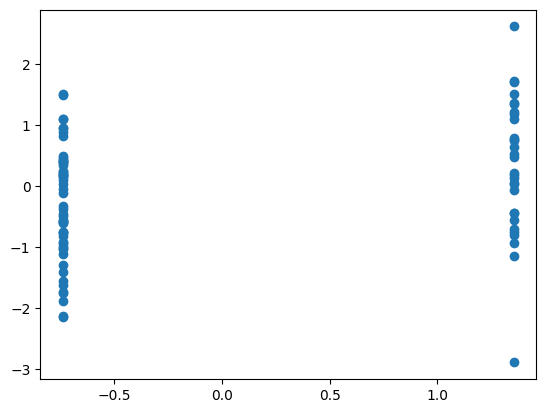

This is factor 127
supp14
supp14
MSE: 0.162
MAE: 0.100
SpearmanrResult(correlation=0.2793219450174594, pvalue=0.009630028013055705) [[1.         0.28029341]
 [0.28029341 1.        ]]


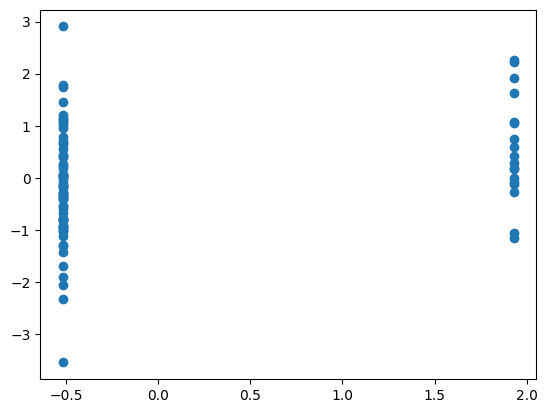

This is factor 128
allergy05
allergy05
MSE: 0.179
MAE: 0.110
SpearmanrResult(correlation=0.17516209137969632, pvalue=0.10884047427206249) [[1.        0.2284116]
 [0.2284116 1.       ]]


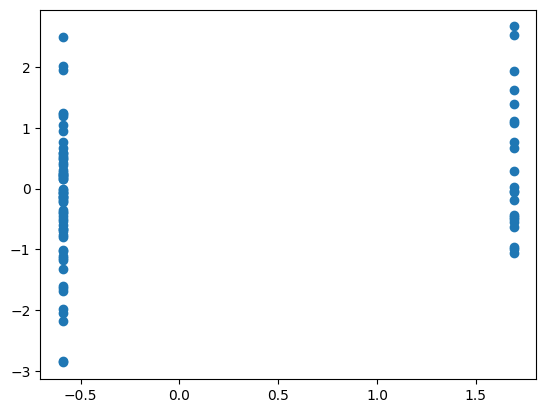

This is factor 129
TMD
TMD
MSE: 0.138
MAE: 0.093
SpearmanrResult(correlation=0.3548551018230732, pvalue=0.0008612829903109832) [[1.         0.33393028]
 [0.33393028 1.        ]]


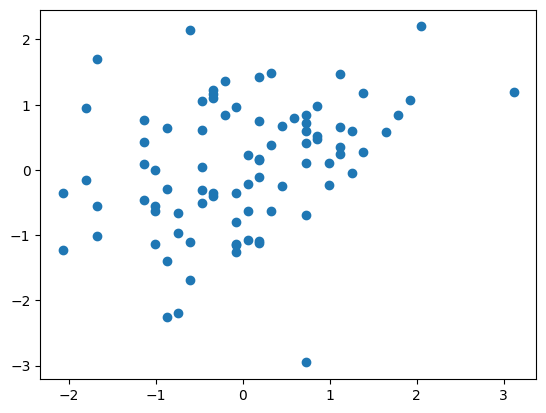

This is factor 130
VO2max
VO2max
MSE: 0.086
MAE: 0.076
SpearmanrResult(correlation=0.5983974985342975, pvalue=1.465015821969192e-09) [[1.         0.63129282]
 [0.63129282 1.        ]]


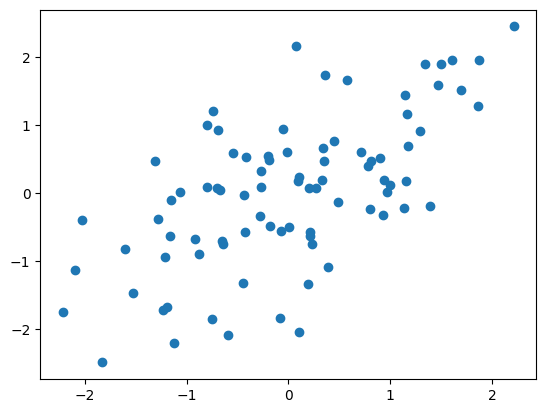

This is factor 131
RBCCount
RBCCount
MSE: 0.186
MAE: 0.108
SpearmanrResult(correlation=0.2362220165273737, pvalue=0.029516685228198496) [[1.         0.21755311]
 [0.21755311 1.        ]]


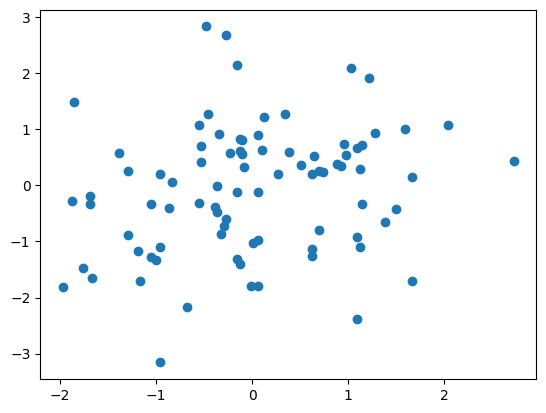

This is factor 132
MCV
MCV
MSE: 0.160
MAE: 0.104
SpearmanrResult(correlation=0.10768717644216172, pvalue=0.32660117722897153) [[1.         0.16389977]
 [0.16389977 1.        ]]


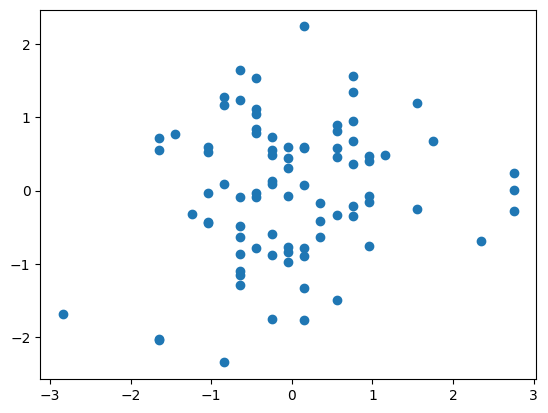

This is factor 133
MCH
MCH
MSE: 0.139
MAE: 0.094
SpearmanrResult(correlation=0.1955032204414738, pvalue=0.07295552689163794) [[1.         0.22564863]
 [0.22564863 1.        ]]


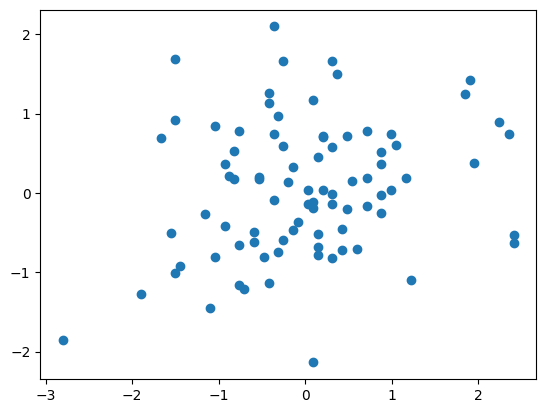

This is factor 134
MCHC
MCHC
MSE: 0.217
MAE: 0.124
SpearmanrResult(correlation=0.06698269602240291, pvalue=0.5424641740745757) [[1.        0.1492679]
 [0.1492679 1.       ]]


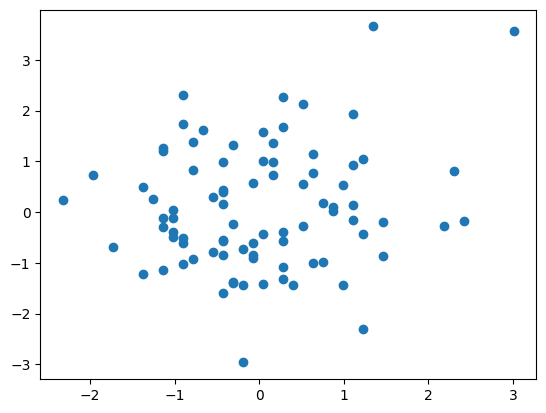

This is factor 135
RDW
RDW
MSE: 0.172
MAE: 0.110
SpearmanrResult(correlation=-0.05205238912480422, pvalue=0.6361313554258475) [[1.         0.00880144]
 [0.00880144 1.        ]]


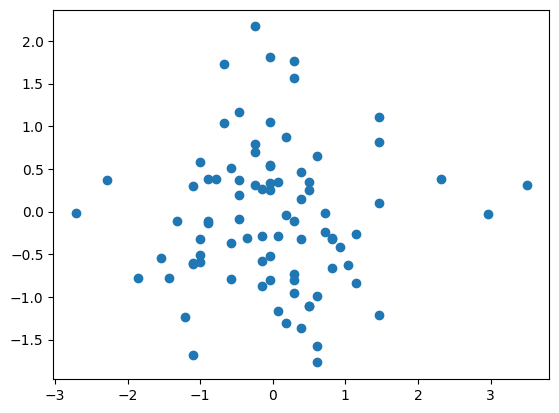

This is factor 136
genome_PC1
genome_PC1
MSE: 0.127
MAE: 0.087
SpearmanrResult(correlation=0.2230213015438734, pvalue=0.04020585103495188) [[1.         0.36748885]
 [0.36748885 1.        ]]


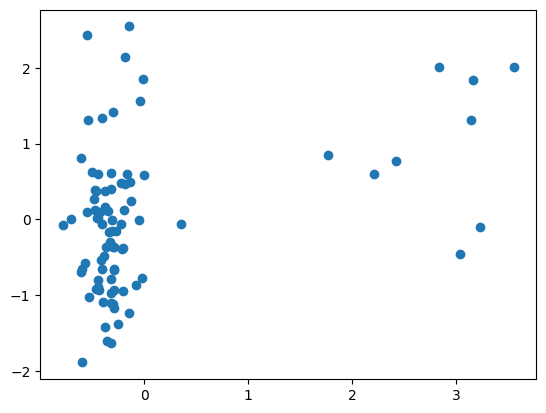

This is factor 137
genome_PC2
genome_PC2
MSE: 0.198
MAE: 0.108
SpearmanrResult(correlation=0.2759624780144616, pvalue=0.010575365776669366) [[1.         0.20211823]
 [0.20211823 1.        ]]


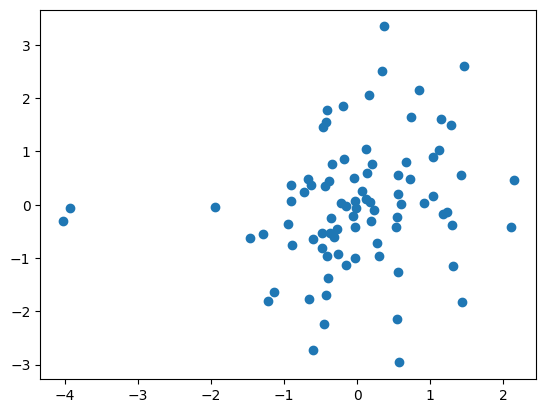

This is factor 138
genome_PC3
genome_PC3
MSE: 0.184
MAE: 0.108
SpearmanrResult(correlation=0.2142075434825093, pvalue=0.04900256654139651) [[1.         0.21820221]
 [0.21820221 1.        ]]


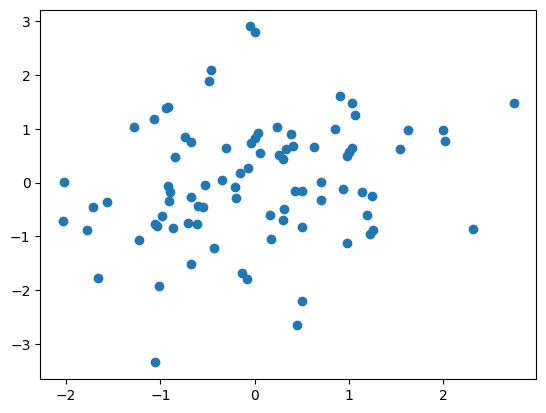

This is factor 139
genome_PC4
genome_PC4
MSE: 0.209
MAE: 0.120
SpearmanrResult(correlation=0.03502051983584131, pvalue=0.7503406037843933) [[1.        0.0481298]
 [0.0481298 1.       ]]


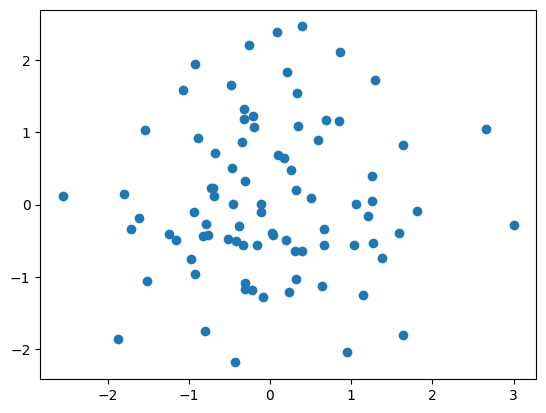

This is factor 140
genome_PC5
genome_PC5
MSE: 0.182
MAE: 0.109
SpearmanrResult(correlation=0.15425053742427203, pvalue=0.1586830507669355) [[1.         0.18784683]
 [0.18784683 1.        ]]


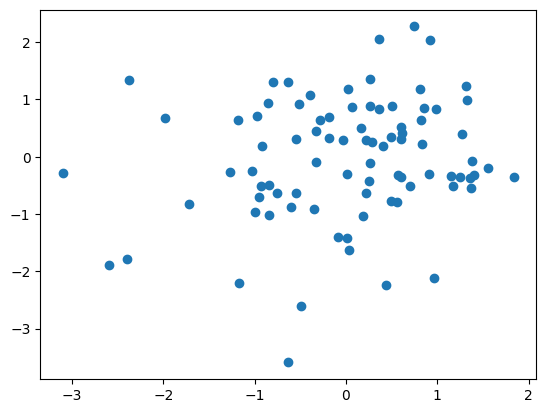

This is factor 141
genome_PC6
genome_PC6
MSE: 0.171
MAE: 0.101
SpearmanrResult(correlation=0.22802423294899354, pvalue=0.03582672838228928) [[1.         0.20501879]
 [0.20501879 1.        ]]


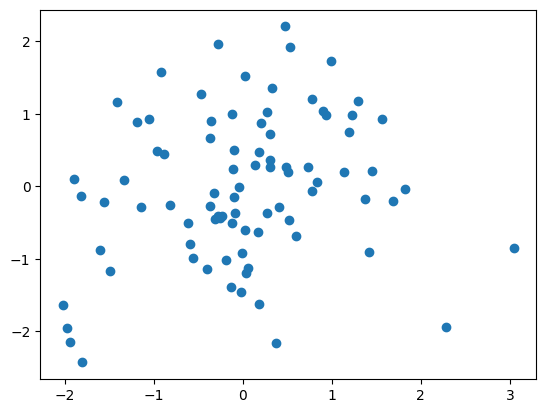

This is factor 142
genome_PC7
genome_PC7
MSE: 0.182
MAE: 0.104
SpearmanrResult(correlation=0.25698651553644714, pvalue=0.017585087848177538) [[1.         0.26235402]
 [0.26235402 1.        ]]


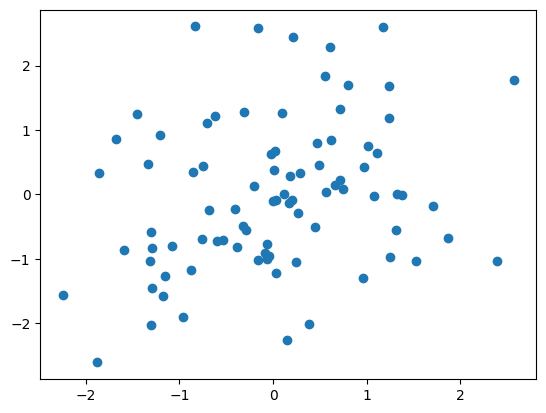

This is factor 143
genome_PC8
genome_PC8
MSE: 0.214
MAE: 0.119
SpearmanrResult(correlation=0.07981239007230799, pvalue=0.46777849291125295) [[1.         0.14930945]
 [0.14930945 1.        ]]


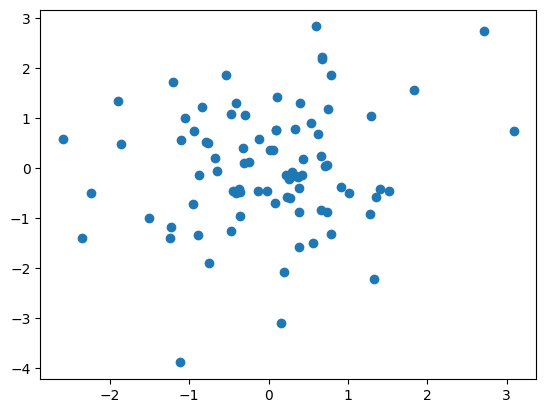

This is factor 144
genome_PC9
genome_PC9
MSE: 0.184
MAE: 0.115
SpearmanrResult(correlation=0.07940199335548172, pvalue=0.4700775708220192) [[1.         0.27214276]
 [0.27214276 1.        ]]


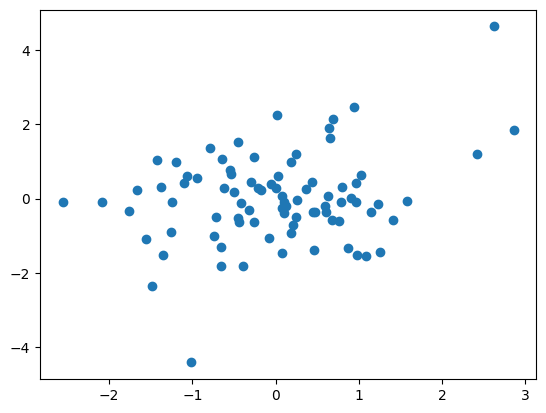

This is factor 145
genome_PC10
genome_PC10
MSE: 0.188
MAE: 0.110
SpearmanrResult(correlation=0.15782685167090094, pvalue=0.1491316061960178) [[1.         0.15996678]
 [0.15996678 1.        ]]


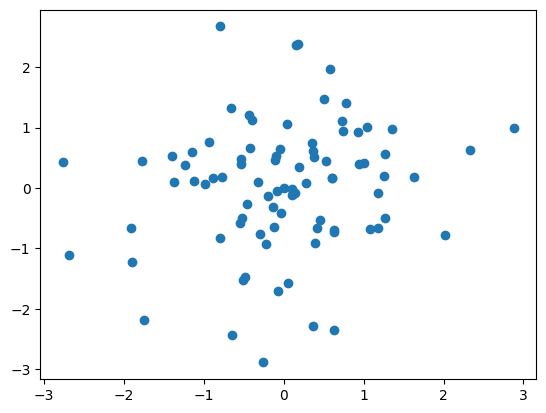

This is factor 146
genome_PC11
genome_PC11
MSE: 0.188
MAE: 0.116
SpearmanrResult(correlation=0.31962087160445574, pvalue=0.0028659575154793867) [[1.         0.32186811]
 [0.32186811 1.        ]]


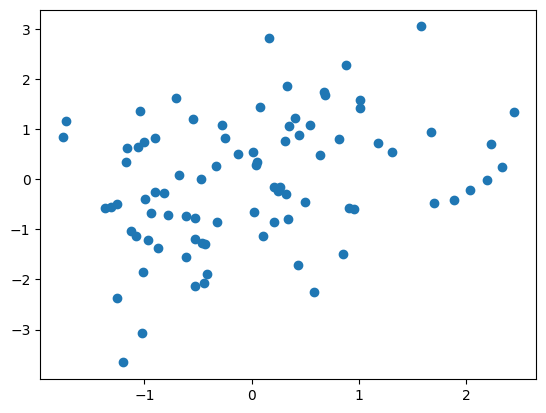

This is factor 147
genome_PC12
genome_PC12
MSE: 0.246
MAE: 0.131
SpearmanrResult(correlation=-0.013054524135235489, pvalue=0.9056083092531935) [[1.         0.01515734]
 [0.01515734 1.        ]]


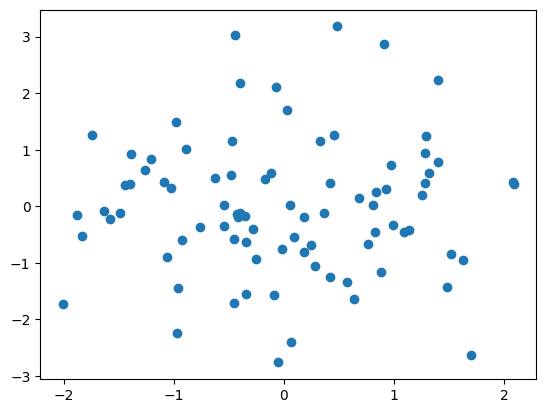

This is factor 148
genome_PC13
genome_PC13
MSE: 0.140
MAE: 0.094
SpearmanrResult(correlation=0.3082470197381278, pvalue=0.004103987002675231) [[1.         0.31541187]
 [0.31541187 1.        ]]


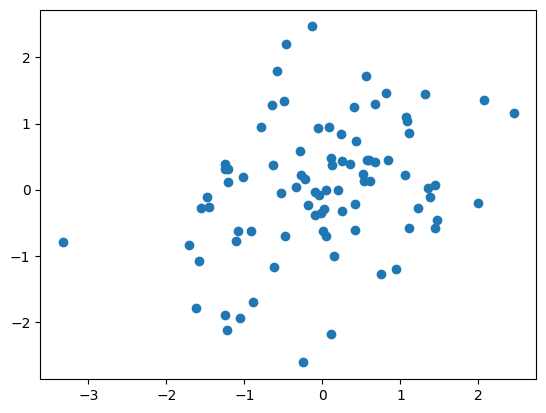

This is factor 149
genome_PC14
genome_PC14
MSE: 0.192
MAE: 0.114
SpearmanrResult(correlation=0.26535079147938245, pvalue=0.014113534023756286) [[1.         0.28453004]
 [0.28453004 1.        ]]


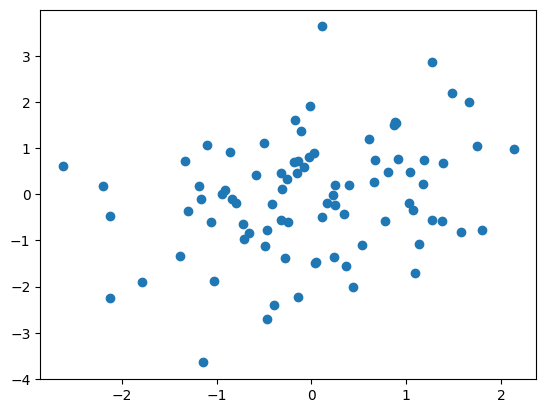

This is factor 150
genome_PC15
genome_PC15
MSE: 0.244
MAE: 0.122
SpearmanrResult(correlation=0.1291967949970686, pvalue=0.23861897383660102) [[1.         0.10652692]
 [0.10652692 1.        ]]


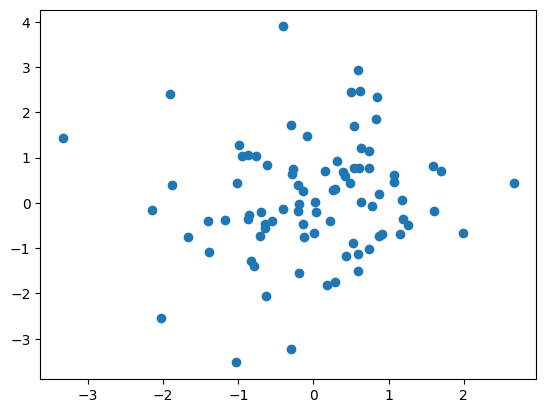

This is factor 151
genome_PC16
genome_PC16
MSE: 0.164
MAE: 0.103
SpearmanrResult(correlation=0.11356263435606803, pvalue=0.3007409277987029) [[1.         0.13788296]
 [0.13788296 1.        ]]


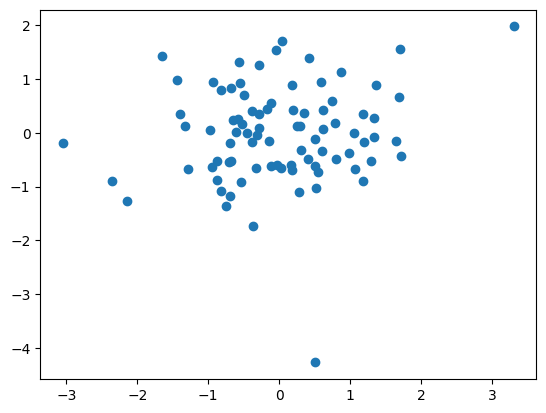

This is factor 152
genome_PC17
genome_PC17
MSE: 0.213
MAE: 0.116
SpearmanrResult(correlation=0.012214188000781709, pvalue=0.911659142005187) [[1.         0.04991536]
 [0.04991536 1.        ]]


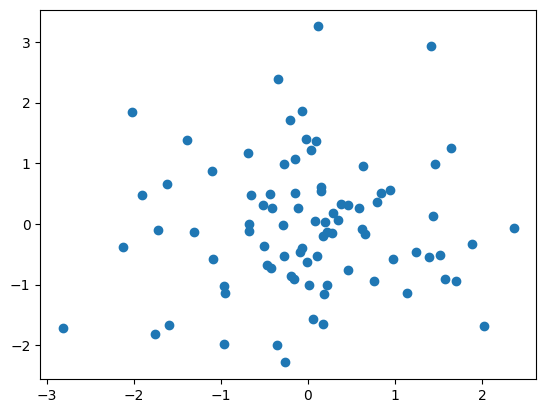

This is factor 153
genome_PC18
genome_PC18
MSE: 0.165
MAE: 0.111
SpearmanrResult(correlation=-0.0478014461598593, pvalue=0.6639756608520179) [[1.         0.11572356]
 [0.11572356 1.        ]]


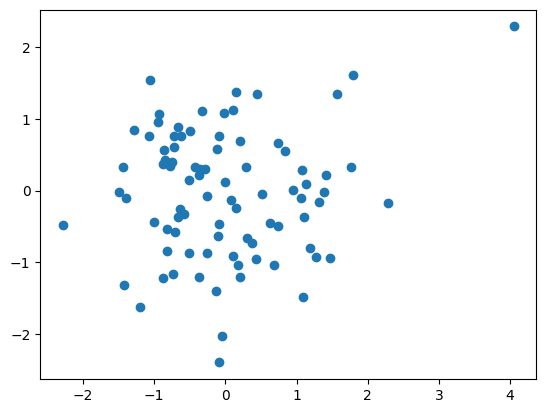

This is factor 154
genome_PC19
genome_PC19
MSE: 0.203
MAE: 0.113
SpearmanrResult(correlation=0.2532734023842095, pvalue=0.019347709888600146) [[1.         0.23881056]
 [0.23881056 1.        ]]


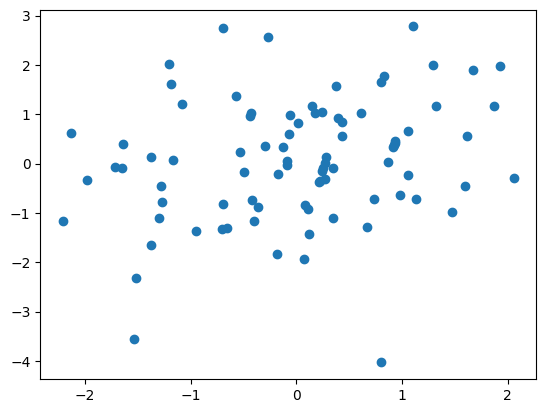

This is factor 155
genome_PC20
genome_PC20
MSE: 0.168
MAE: 0.106
SpearmanrResult(correlation=0.18303693570451438, pvalue=0.0935955841203204) [[1.         0.17775311]
 [0.17775311 1.        ]]


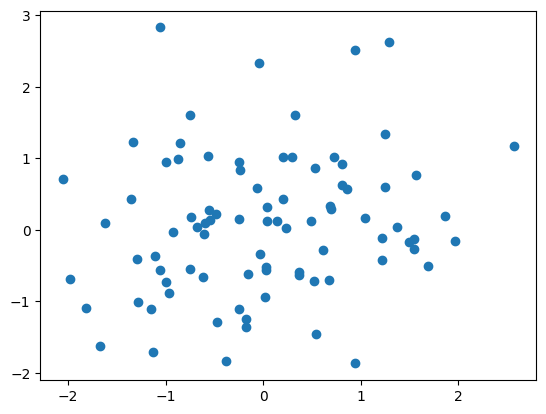

This is factor 156
genome_PC21
genome_PC21
MSE: 0.175
MAE: 0.110
SpearmanrResult(correlation=0.3303498143443424, pvalue=0.0020167178971696458) [[1.        0.3570133]
 [0.3570133 1.       ]]


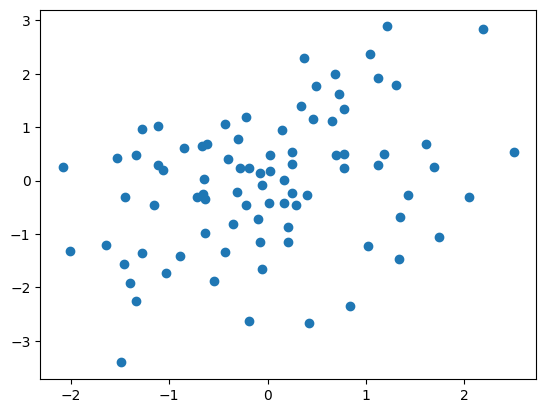

This is factor 157
genome_PC22
genome_PC22
MSE: 0.219
MAE: 0.119
SpearmanrResult(correlation=0.0664451827242525, pvalue=0.5457158055757492) [[1.         0.10290003]
 [0.10290003 1.        ]]


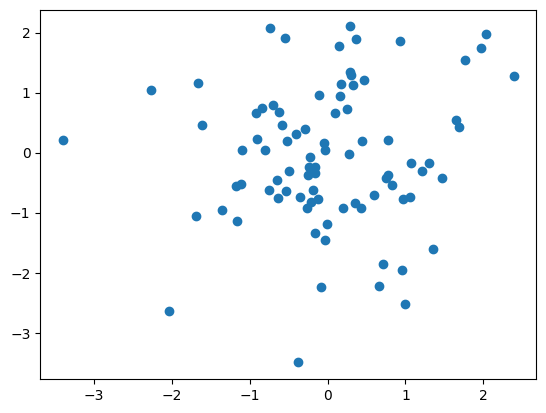

This is factor 158
genome_PC23
genome_PC23
MSE: 0.130
MAE: 0.093
SpearmanrResult(correlation=0.3516318155169044, pvalue=0.0009670566406413991) [[1.         0.37126261]
 [0.37126261 1.        ]]


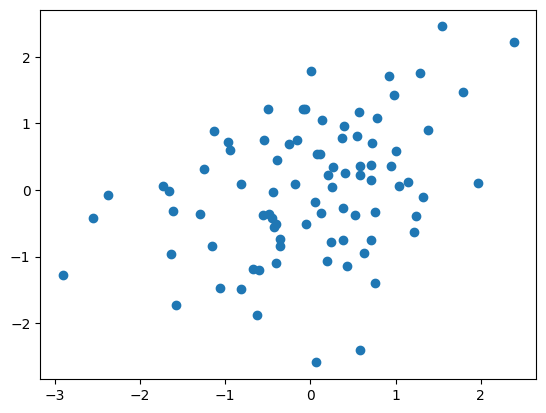

This is factor 159
genome_PC24
genome_PC24
MSE: 0.202
MAE: 0.116
SpearmanrResult(correlation=0.22413523548954464, pvalue=0.039194088193109114) [[1.         0.28990139]
 [0.28990139 1.        ]]


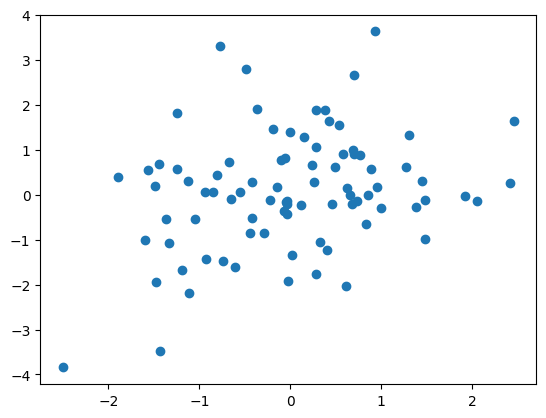

This is factor 160
genome_PC25
genome_PC25
MSE: 0.228
MAE: 0.122
SpearmanrResult(correlation=0.09999999999999999, pvalue=0.3625120217928751) [[1.         0.05078984]
 [0.05078984 1.        ]]


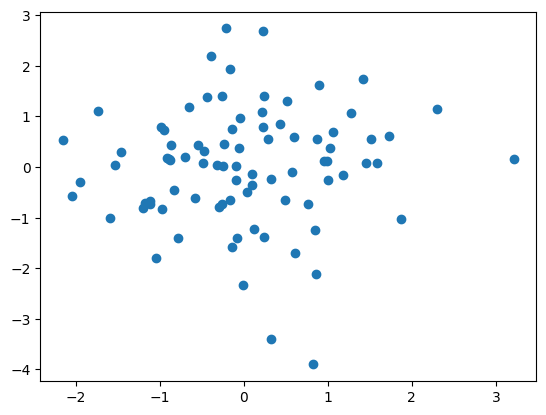

This is factor 161
genome_PC26
genome_PC26
MSE: 0.187
MAE: 0.112
SpearmanrResult(correlation=0.05096736368966191, pvalue=0.6431925703409762) [[1.         0.16259955]
 [0.16259955 1.        ]]


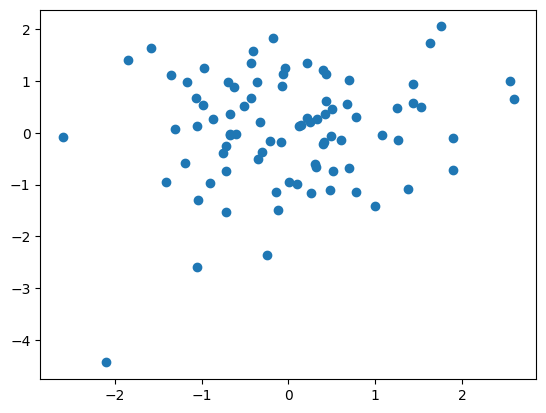

This is factor 162
genome_PC27
genome_PC27
MSE: 0.168
MAE: 0.104
SpearmanrResult(correlation=0.2547391049443033, pvalue=0.018634619057979036) [[1.         0.21186979]
 [0.21186979 1.        ]]


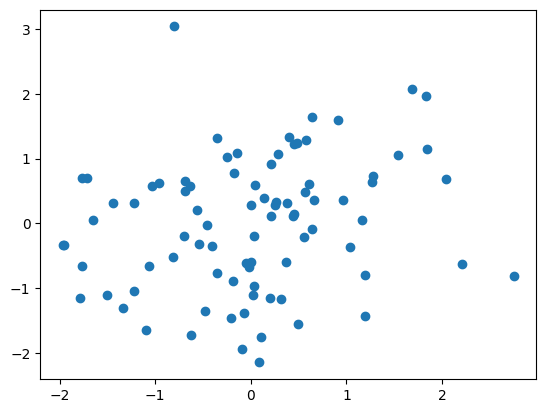

This is factor 163
genome_PC28
genome_PC28
MSE: 0.238
MAE: 0.124
SpearmanrResult(correlation=-0.05800273597811217, pvalue=0.5979955345516137) [[ 1.        -0.0947551]
 [-0.0947551  1.       ]]


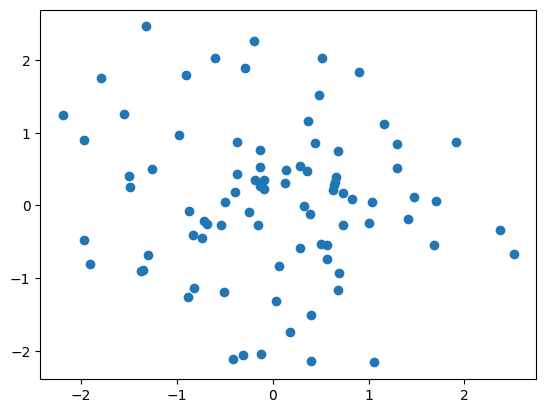

This is factor 164
genome_PC29
genome_PC29
MSE: 0.136
MAE: 0.096
SpearmanrResult(correlation=0.21850693765878448, pvalue=0.044531402947903684) [[1.         0.27442639]
 [0.27442639 1.        ]]


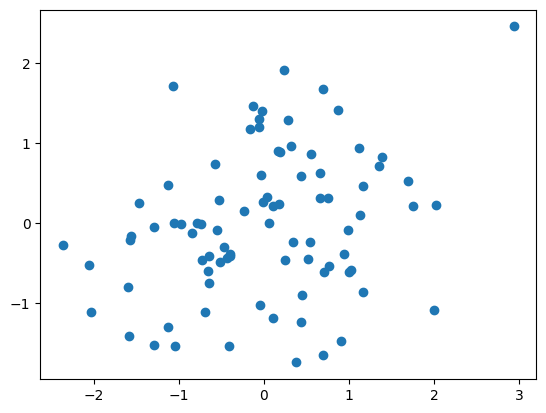

This is factor 165
genome_PC30
genome_PC30
MSE: 0.270
MAE: 0.125
SpearmanrResult(correlation=-0.015165135821770568, pvalue=0.8904353303692127) [[ 1.         -0.06377076]
 [-0.06377076  1.        ]]


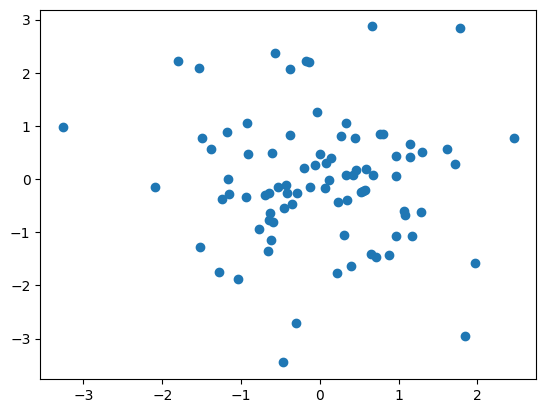

This is factor 166
genome_PC31
genome_PC31
MSE: 0.175
MAE: 0.109
SpearmanrResult(correlation=0.17412546413914404, pvalue=0.11098323831012505) [[1.         0.17390458]
 [0.17390458 1.        ]]


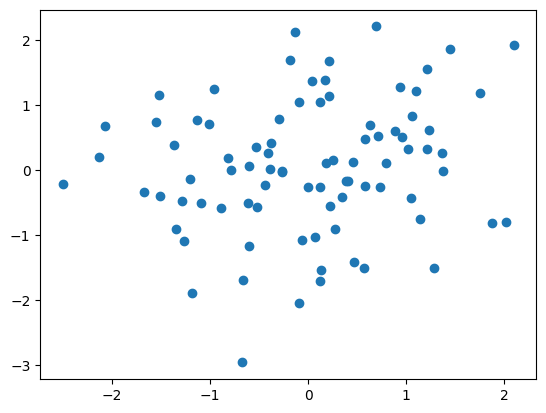

This is factor 167
genome_PC32
genome_PC32
MSE: 0.193
MAE: 0.114
SpearmanrResult(correlation=0.15808090678131717, pvalue=0.14846984958945172) [[1.         0.19577249]
 [0.19577249 1.        ]]


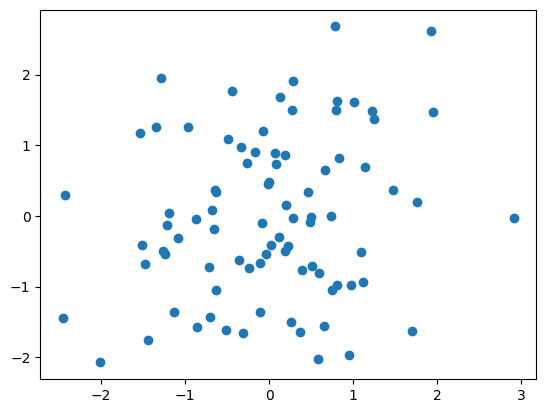

This is factor 168
genome_PC33
genome_PC33
MSE: 0.195
MAE: 0.108
SpearmanrResult(correlation=0.10203244088333006, pvalue=0.3527893972529781) [[1.       0.075247]
 [0.075247 1.      ]]


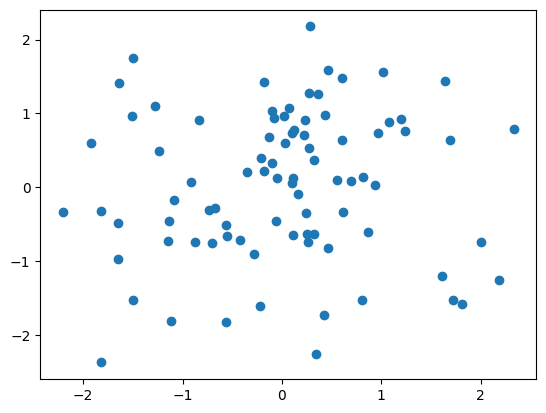

This is factor 169
genome_PC34
genome_PC34
MSE: 0.133
MAE: 0.091
SpearmanrResult(correlation=0.41151065077193666, pvalue=9.130815767844573e-05) [[1.         0.39405235]
 [0.39405235 1.        ]]


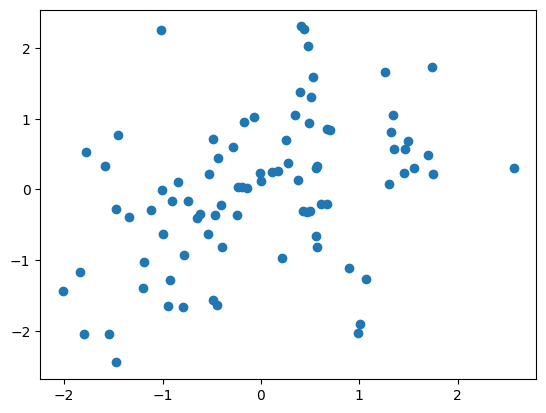

This is factor 170
genome_PC35
genome_PC35
MSE: 0.165
MAE: 0.104
SpearmanrResult(correlation=0.0677154582763338, pvalue=0.5380467353129216) [[1.         0.09745307]
 [0.09745307 1.        ]]


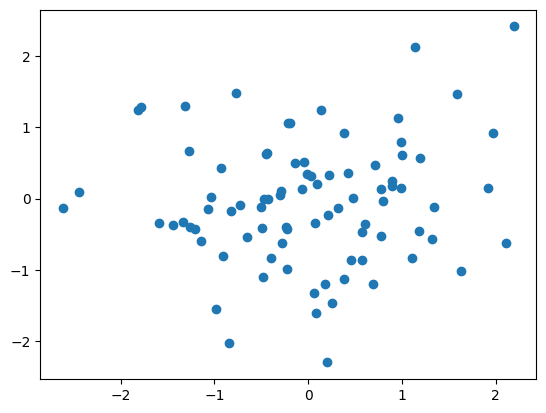

This is factor 171
genome_PC36
genome_PC36
MSE: 0.220
MAE: 0.111
SpearmanrResult(correlation=0.08880203244088335, pvalue=0.4189809136819561) [[1.         0.05413116]
 [0.05413116 1.        ]]


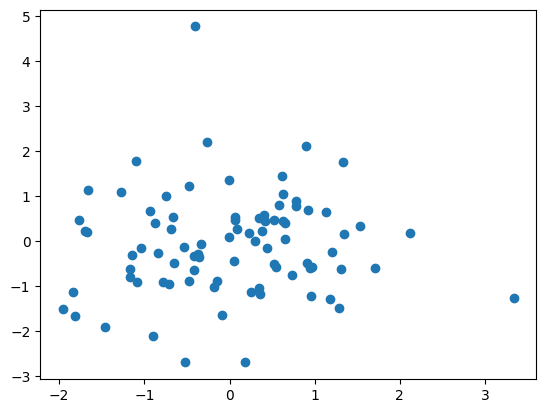

This is factor 172
genome_PC37
genome_PC37
MSE: 0.194
MAE: 0.117
SpearmanrResult(correlation=0.16025014657025602, pvalue=0.14290885265753947) [[1.         0.18624993]
 [0.18624993 1.        ]]


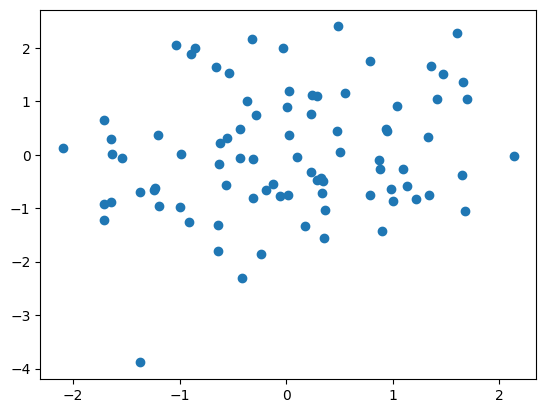

This is factor 173
genome_PC38
genome_PC38
MSE: 0.216
MAE: 0.124
SpearmanrResult(correlation=0.24645299980457303, pvalue=0.022981922487215176) [[1.         0.28406387]
 [0.28406387 1.        ]]


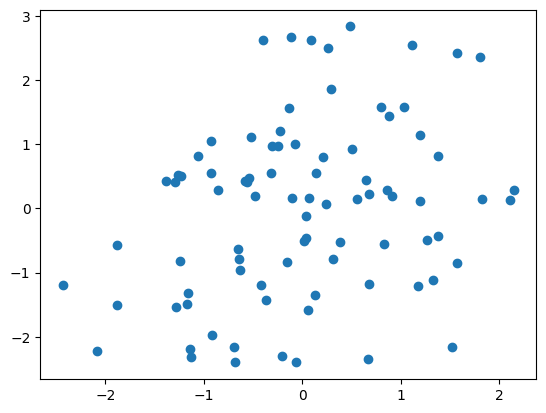

This is factor 174
genome_PC39
genome_PC39
MSE: 0.182
MAE: 0.107
SpearmanrResult(correlation=0.05143638850889193, pvalue=0.6401362818392545) [[1.         0.03170531]
 [0.03170531 1.        ]]


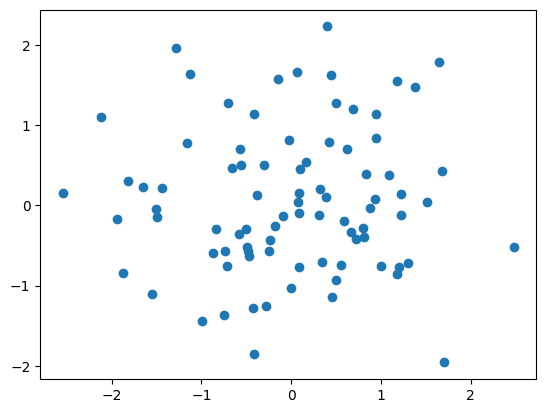

This is factor 175
genome_PC40
genome_PC40
MSE: 0.143
MAE: 0.101
SpearmanrResult(correlation=0.22266953292945085, pvalue=0.04052983767386362) [[1.        0.2364693]
 [0.2364693 1.       ]]


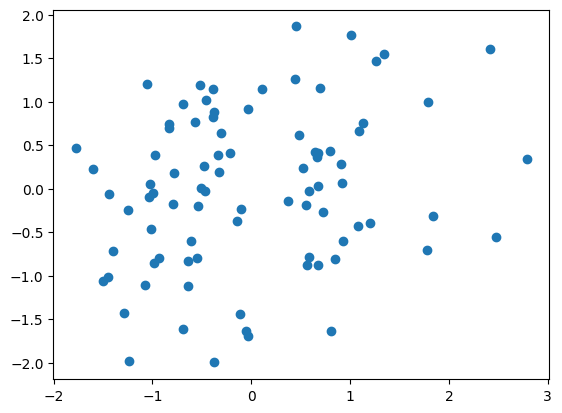

This is factor 176
genome_PC41
genome_PC41
MSE: 0.287
MAE: 0.141
SpearmanrResult(correlation=-0.14676568301739298, pvalue=0.18013197392430083) [[ 1.         -0.14430855]
 [-0.14430855  1.        ]]


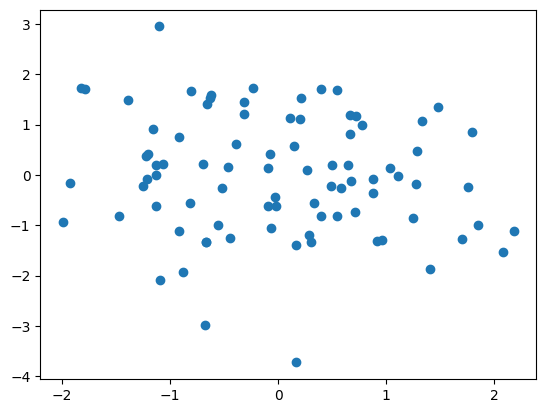

This is factor 177
genome_PC42
genome_PC42
MSE: 0.225
MAE: 0.116
SpearmanrResult(correlation=0.07549345319523158, pvalue=0.49227768054331655) [[1.         0.04498829]
 [0.04498829 1.        ]]


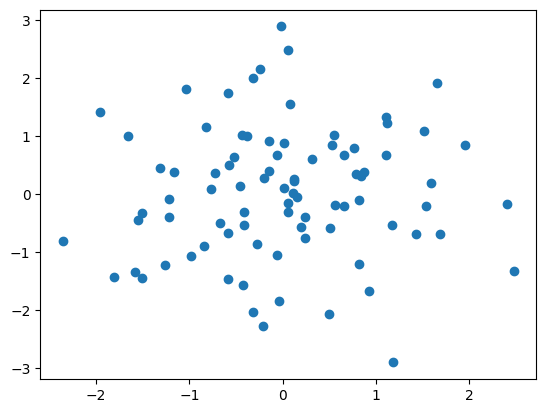

This is factor 178
genome_PC43
genome_PC43
MSE: 0.135
MAE: 0.093
SpearmanrResult(correlation=0.3720734805550127, pvalue=0.00045432025201147) [[1.         0.35426073]
 [0.35426073 1.        ]]


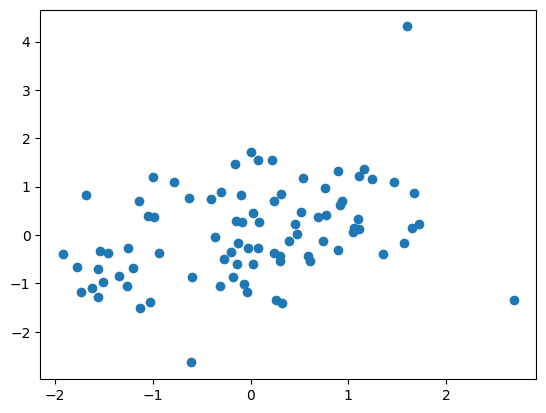

This is factor 179
genome_PC44
genome_PC44
MSE: 0.185
MAE: 0.108
SpearmanrResult(correlation=0.20545241352354893, pvalue=0.059253457453318926) [[1.         0.20156253]
 [0.20156253 1.        ]]


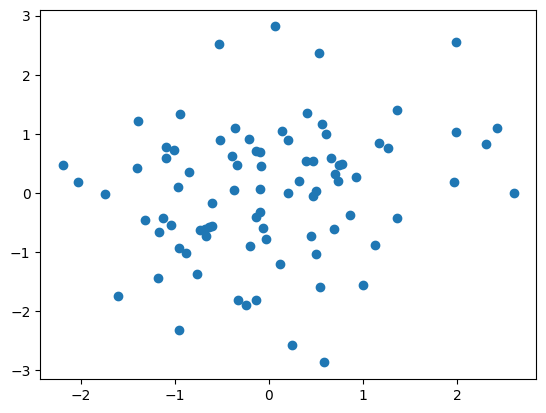

This is factor 180
genome_PC45
genome_PC45
MSE: 0.136
MAE: 0.093
SpearmanrResult(correlation=0.3769005276529216, pvalue=0.0003773022873626754) [[1.         0.34453677]
 [0.34453677 1.        ]]


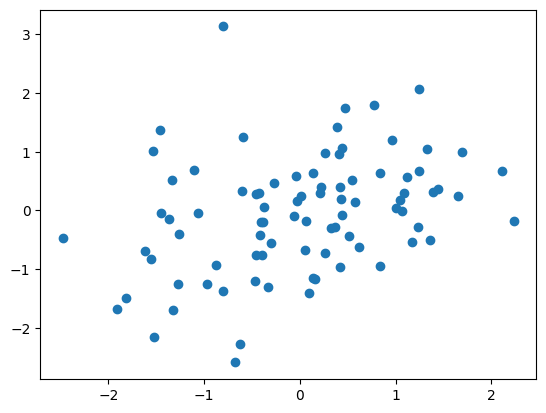

This is factor 181
genome_PC46
genome_PC46
MSE: 0.260
MAE: 0.129
SpearmanrResult(correlation=0.07549345319523158, pvalue=0.49227768054331655) [[1.         0.08358845]
 [0.08358845 1.        ]]


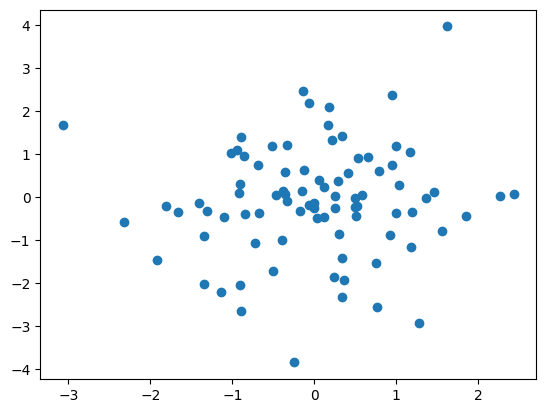

This is factor 182
genome_PC47
genome_PC47
MSE: 0.181
MAE: 0.109
SpearmanrResult(correlation=0.07307015829587649, pvalue=0.5063139514279376) [[1.         0.13561539]
 [0.13561539 1.        ]]


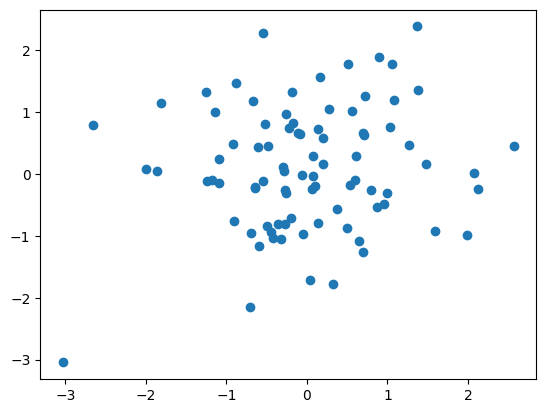

This is factor 183
genome_PC48
genome_PC48
MSE: 0.188
MAE: 0.110
SpearmanrResult(correlation=0.1629079538792261, pvalue=0.13631107716040242) [[1.         0.18395595]
 [0.18395595 1.        ]]


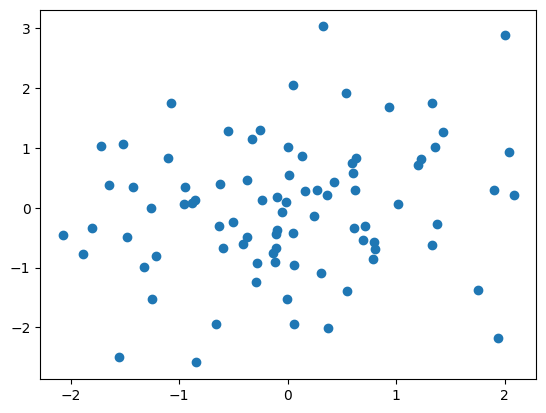

This is factor 184
genome_PC49
genome_PC49
MSE: 0.169
MAE: 0.105
SpearmanrResult(correlation=0.2488762947039281, pvalue=0.021629090979096204) [[1.         0.26824448]
 [0.26824448 1.        ]]


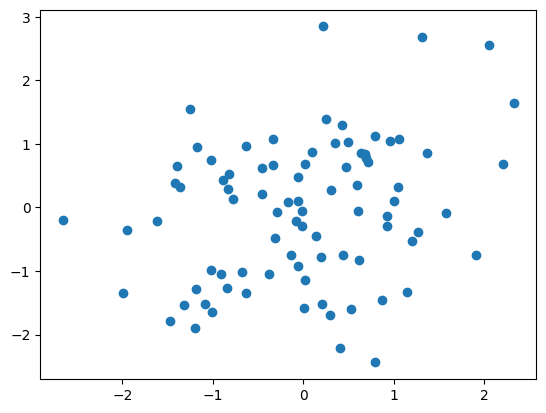

This is factor 185
genome_PC50
genome_PC50
MSE: 0.171
MAE: 0.103
SpearmanrResult(correlation=0.24524135235489544, pvalue=0.023684969003953785) [[1.         0.25597634]
 [0.25597634 1.        ]]


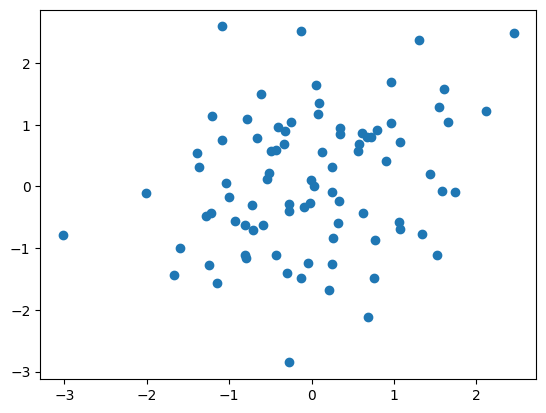

This is factor 186
genome_PC51
genome_PC51
MSE: 0.154
MAE: 0.101
SpearmanrResult(correlation=0.413797146765683, pvalue=8.267556205516901e-05) [[1.        0.3831148]
 [0.3831148 1.       ]]


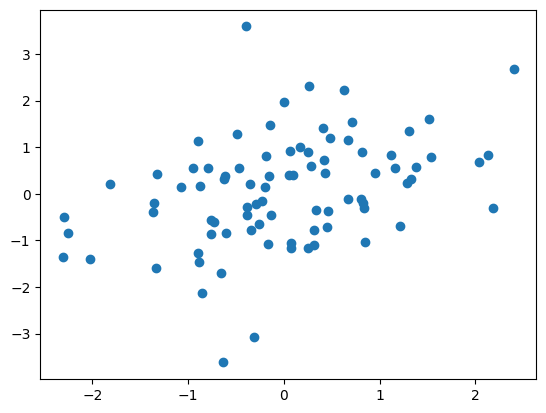

This is factor 187
genome_PC52
genome_PC52
MSE: 0.179
MAE: 0.110
SpearmanrResult(correlation=0.3148719953097518, pvalue=0.003335047159942329) [[1.         0.29970145]
 [0.29970145 1.        ]]


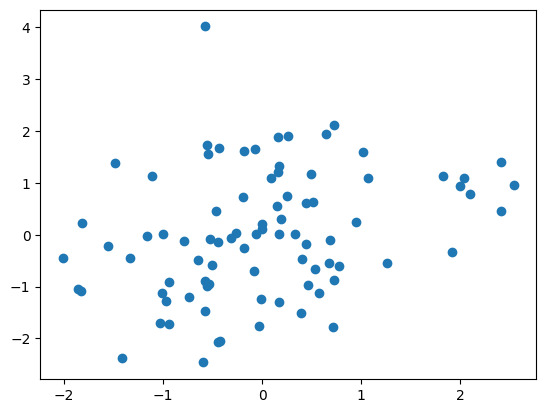

This is factor 188
genome_PC53
genome_PC53
MSE: 0.317
MAE: 0.139
SpearmanrResult(correlation=-0.09095172952902092, pvalue=0.4077636193042852) [[ 1.         -0.09288339]
 [-0.09288339  1.        ]]


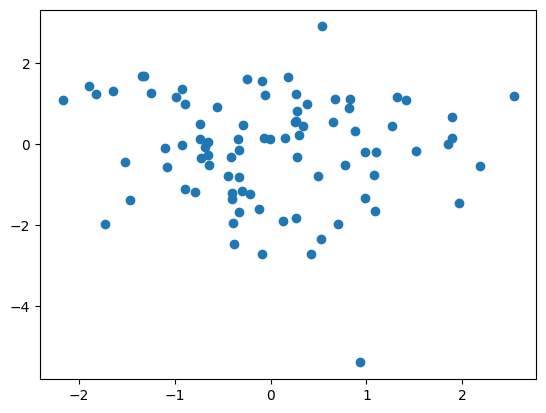

This is factor 189
genome_PC54
genome_PC54
MSE: 0.218
MAE: 0.124
SpearmanrResult(correlation=0.02024623803009576, pvalue=0.8540792379520049) [[1.         0.08550534]
 [0.08550534 1.        ]]


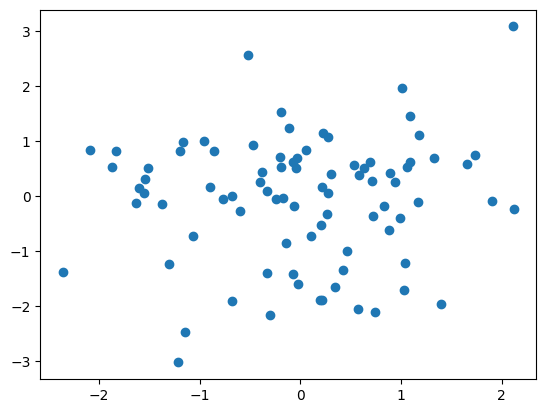

This is factor 190
genome_PC55
genome_PC55
MSE: 0.203
MAE: 0.114
SpearmanrResult(correlation=-0.03504006253664256, pvalue=0.7502058445280309) [[ 1.         -0.06199925]
 [-0.06199925  1.        ]]


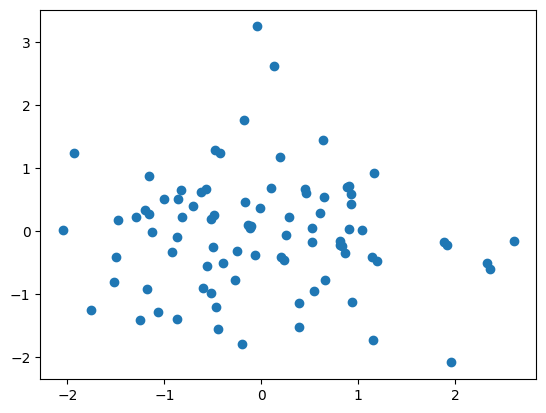

This is factor 191
genome_PC56
genome_PC56
MSE: 0.199
MAE: 0.113
SpearmanrResult(correlation=0.1160641000586281, pvalue=0.29014923983300817) [[1.         0.10001283]
 [0.10001283 1.        ]]


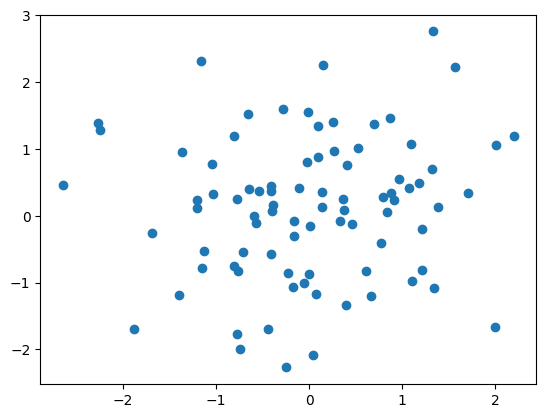

This is factor 192
genome_PC57
genome_PC57
MSE: 0.140
MAE: 0.097
SpearmanrResult(correlation=0.2263044752784835, pvalue=0.037284680842387) [[1.         0.27689175]
 [0.27689175 1.        ]]


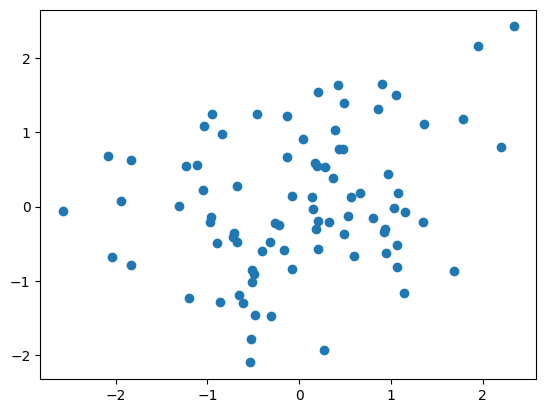

This is factor 193
genome_PC58
genome_PC58
MSE: 0.167
MAE: 0.113
SpearmanrResult(correlation=0.24664842681258553, pvalue=0.022870211228522844) [[1.         0.25509681]
 [0.25509681 1.        ]]


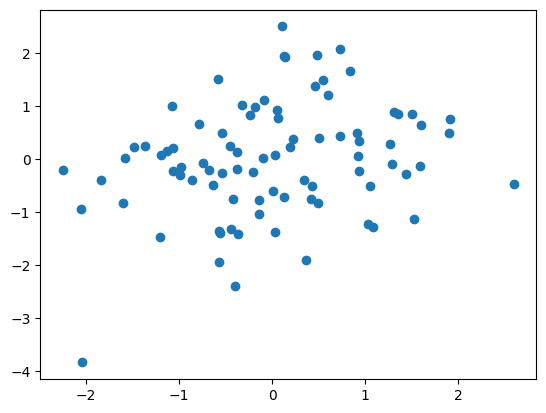

This is factor 194
genome_PC59
genome_PC59
MSE: 0.185
MAE: 0.105
SpearmanrResult(correlation=0.14488958374047292, pvalue=0.18582516010497868) [[1.         0.13942824]
 [0.13942824 1.        ]]


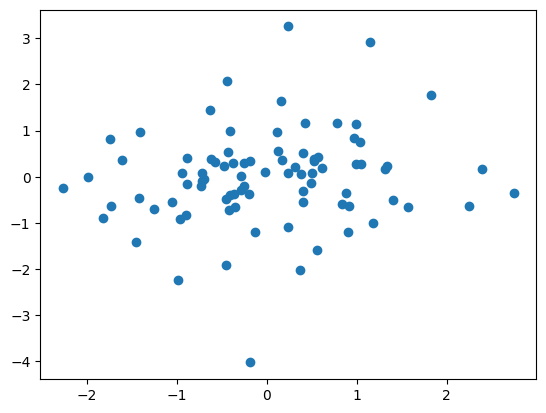

This is factor 195
genome_PC60
genome_PC60
MSE: 0.245
MAE: 0.128
SpearmanrResult(correlation=0.0, pvalue=1.0) [[1.        0.0158601]
 [0.0158601 1.       ]]


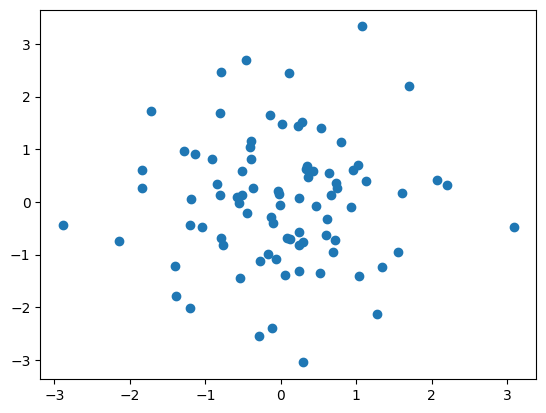

This is factor 196
genome_PC61
genome_PC61
MSE: 0.318
MAE: 0.139
SpearmanrResult(correlation=0.04420558921242916, pvalue=0.6878919785419566) [[1.         0.03200211]
 [0.03200211 1.        ]]


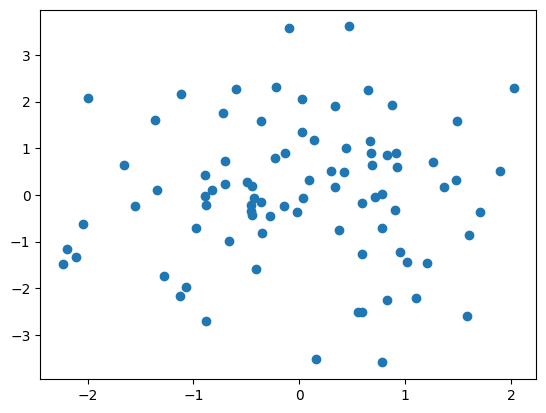

This is factor 197
genome_PC62
genome_PC62
MSE: 0.179
MAE: 0.108
SpearmanrResult(correlation=0.18393589994137188, pvalue=0.09196798820364527) [[1.         0.17953982]
 [0.17953982 1.        ]]


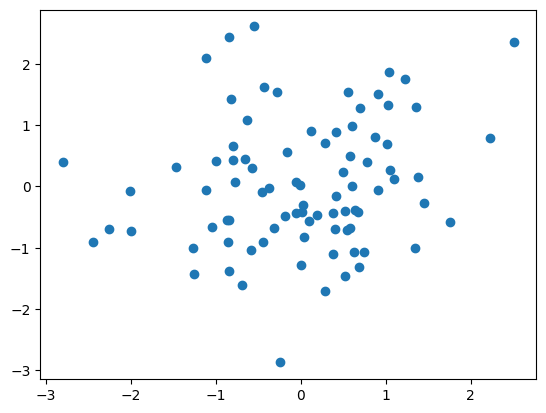

This is factor 198
genome_PC63
genome_PC63
MSE: 0.158
MAE: 0.104
SpearmanrResult(correlation=0.2968340824701974, pvalue=0.005804550021931489) [[1.         0.29831671]
 [0.29831671 1.        ]]


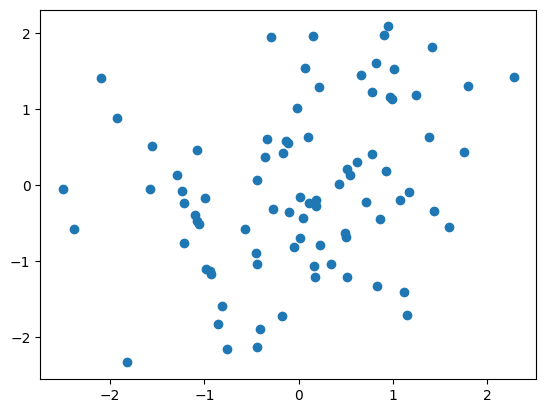

This is factor 199
genome_PC64
genome_PC64
MSE: 0.241
MAE: 0.127
SpearmanrResult(correlation=0.03728747312878639, pvalue=0.7347593964409729) [[1.         0.01518446]
 [0.01518446 1.        ]]


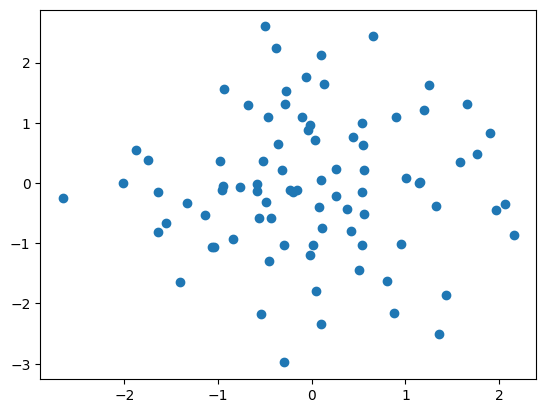

This is factor 200
genome_PC65
genome_PC65
MSE: 0.135
MAE: 0.093
SpearmanrResult(correlation=0.27408637873754155, pvalue=0.011137776277590094) [[1.        0.3243702]
 [0.3243702 1.       ]]


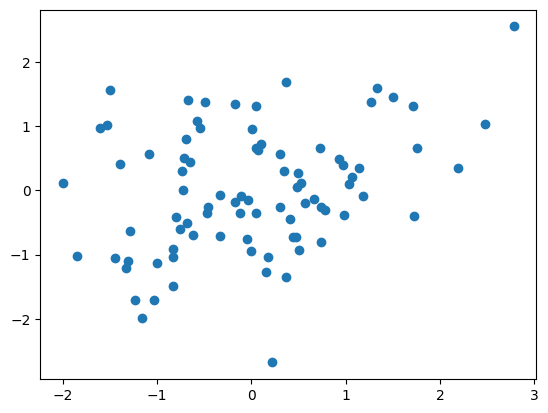

This is factor 201
genome_PC66
genome_PC66
MSE: 0.250
MAE: 0.130
SpearmanrResult(correlation=-0.1447527848348642, pvalue=0.18624533936657706) [[ 1.        -0.1629391]
 [-0.1629391  1.       ]]


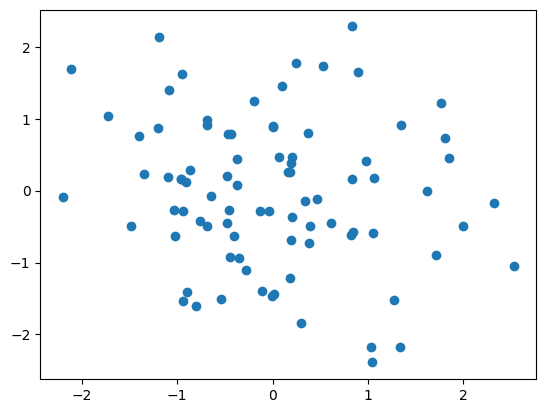

This is factor 202
genome_PC67
genome_PC67
MSE: 0.256
MAE: 0.123
SpearmanrResult(correlation=0.12309947234707837, pvalue=0.2616957857725125) [[1.         0.05814919]
 [0.05814919 1.        ]]


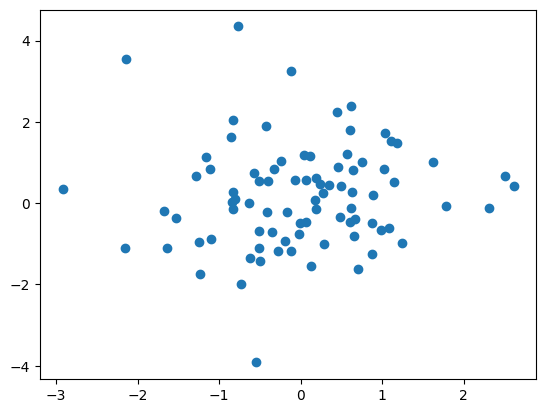

This is factor 203
genome_PC68
genome_PC68
MSE: 0.168
MAE: 0.106
SpearmanrResult(correlation=0.2736955247215165, pvalue=0.01125817393146652) [[1.         0.28866915]
 [0.28866915 1.        ]]


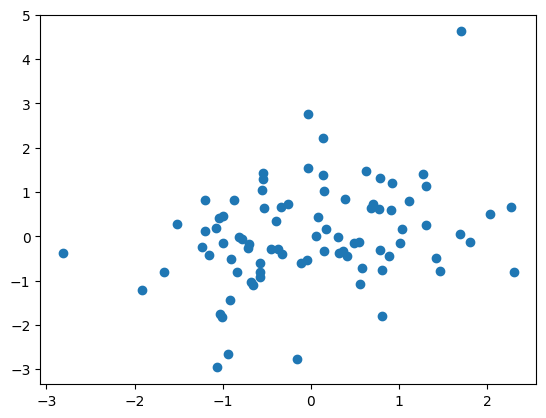

This is factor 204
genome_PC69
genome_PC69
MSE: 0.270
MAE: 0.133
SpearmanrResult(correlation=-0.001895641977721321, pvalue=0.9862625453189087) [[1.         0.05334606]
 [0.05334606 1.        ]]


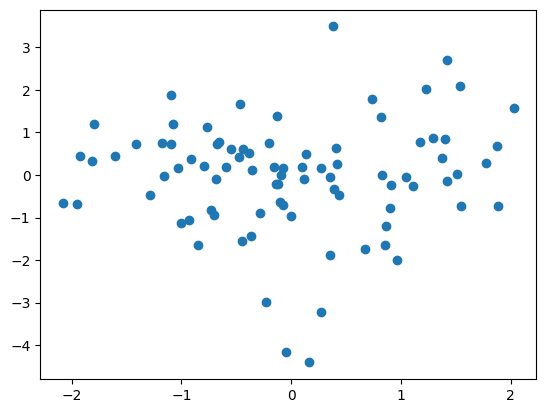

This is factor 205
genome_PC70
genome_PC70
MSE: 0.256
MAE: 0.131
SpearmanrResult(correlation=-0.05063513777604065, pvalue=0.6453610372594347) [[ 1.         -0.03535532]
 [-0.03535532  1.        ]]


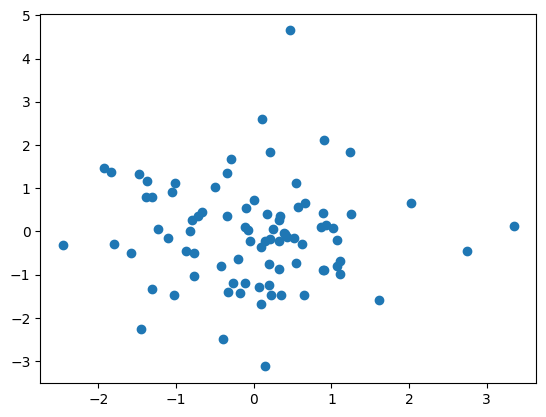

This is factor 206
genome_PC71
genome_PC71
MSE: 0.168
MAE: 0.104
SpearmanrResult(correlation=0.20590189564197772, pvalue=0.058687711225227236) [[1.         0.25170504]
 [0.25170504 1.        ]]


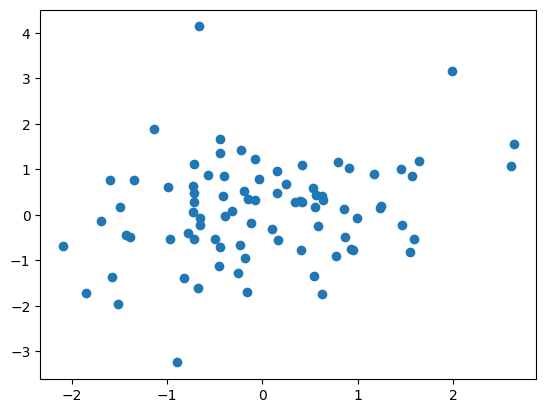

This is factor 207
genome_PC72
genome_PC72
MSE: 0.205
MAE: 0.114
SpearmanrResult(correlation=0.005628297830760211, pvalue=0.9592279640564092) [[1.         0.03367831]
 [0.03367831 1.        ]]


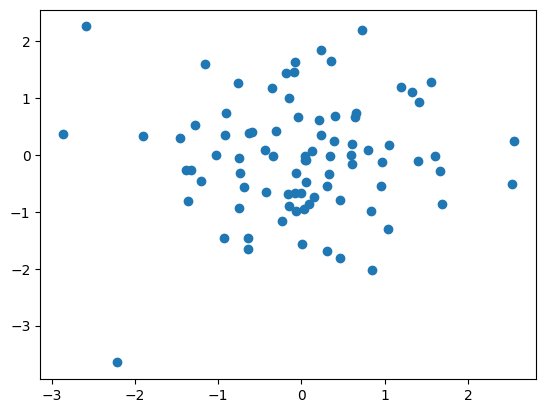

This is factor 208
genome_PC73
genome_PC73
MSE: 0.211
MAE: 0.112
SpearmanrResult(correlation=0.1367207348055501, pvalue=0.21213805180065215) [[1.         0.08680174]
 [0.08680174 1.        ]]


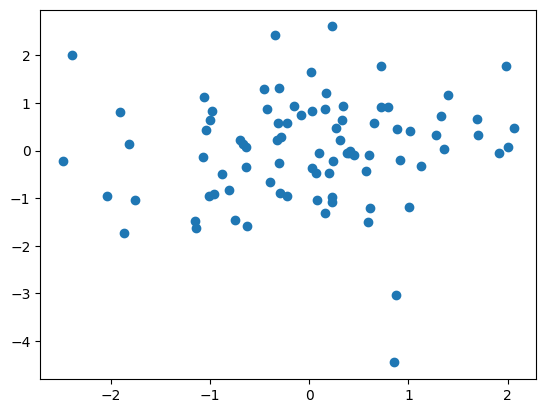

This is factor 209
genome_PC74
genome_PC74
MSE: 0.172
MAE: 0.108
SpearmanrResult(correlation=0.35798319327731093, pvalue=0.0007688126498790641) [[1.         0.38056867]
 [0.38056867 1.        ]]


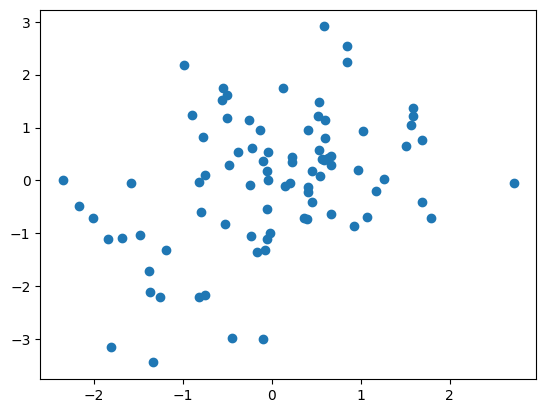

This is factor 210
genome_PC75
genome_PC75
MSE: 0.272
MAE: 0.137
SpearmanrResult(correlation=0.022005081102208324, pvalue=0.8415610299374102) [[1.         0.01417376]
 [0.01417376 1.        ]]


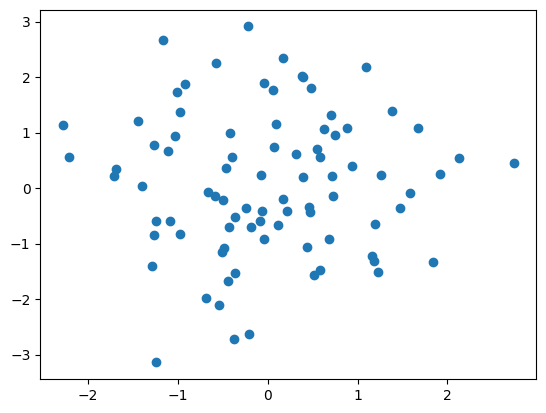

This is factor 211
genome_PC76
genome_PC76
MSE: 0.271
MAE: 0.137
SpearmanrResult(correlation=0.16320109439124486, pvalue=0.13559775571691407) [[1.         0.19185981]
 [0.19185981 1.        ]]


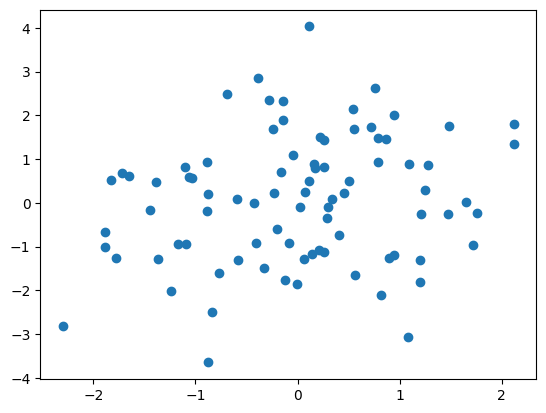

This is factor 212
genome_PC77
genome_PC77
MSE: 0.208
MAE: 0.113
SpearmanrResult(correlation=0.139749853429744, pvalue=0.20208876775705403) [[1.        0.0867214]
 [0.0867214 1.       ]]


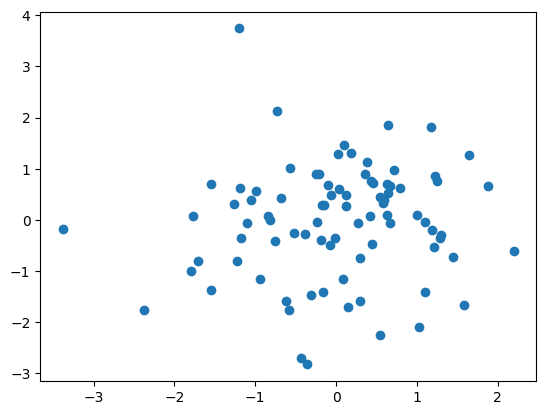

This is factor 213
genome_PC78
genome_PC78
MSE: 0.178
MAE: 0.108
SpearmanrResult(correlation=0.12137971467656831, pvalue=0.26846959398218473) [[1.        0.1378953]
 [0.1378953 1.       ]]


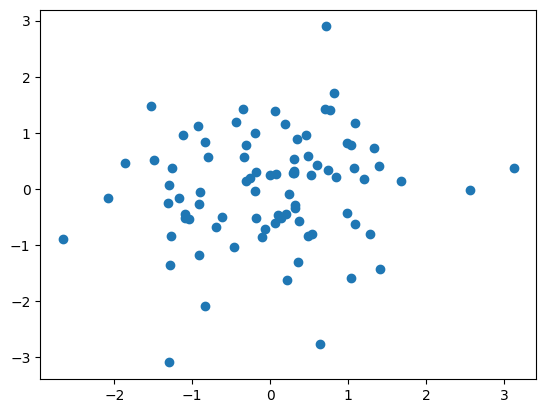

This is factor 214
genome_PC79
genome_PC79
MSE: 0.244
MAE: 0.122
SpearmanrResult(correlation=0.22061754934531952, pvalue=0.04246335422866611) [[1.         0.14954275]
 [0.14954275 1.        ]]


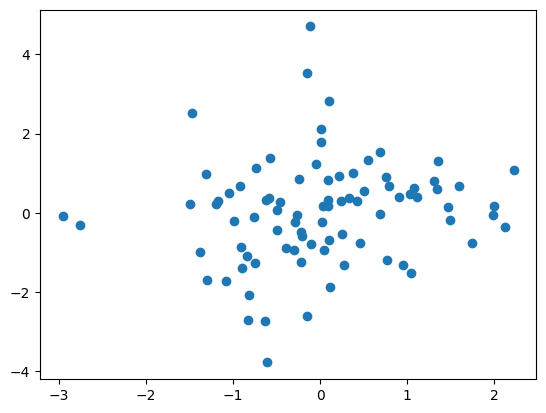

This is factor 215
genome_PC80
genome_PC80
MSE: 0.181
MAE: 0.105
SpearmanrResult(correlation=0.21723666210670312, pvalue=0.04581579256962505) [[1.         0.18699231]
 [0.18699231 1.        ]]


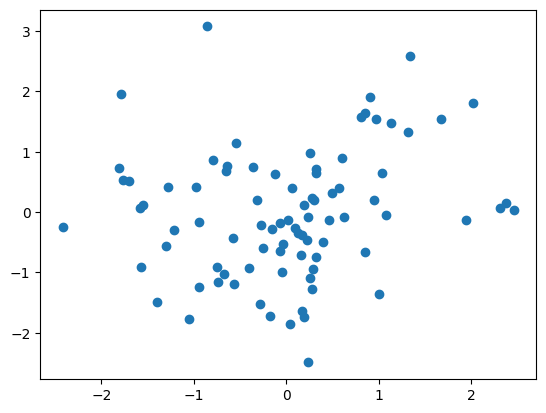

This is factor 216
genome_PC81
genome_PC81
MSE: 0.253
MAE: 0.130
SpearmanrResult(correlation=0.10975180769982411, pvalue=0.317356859158311) [[1.         0.10058092]
 [0.10058092 1.        ]]


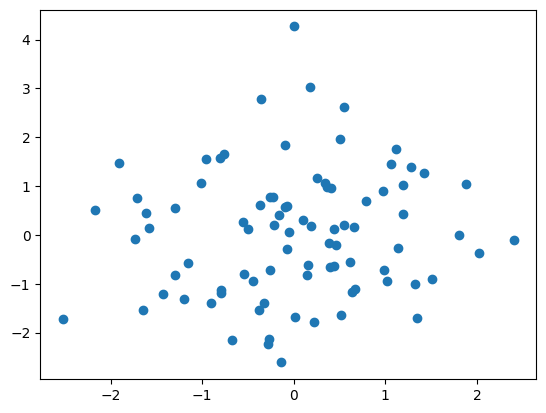

This is factor 217
genome_PC82
genome_PC82
MSE: 0.218
MAE: 0.124
SpearmanrResult(correlation=0.14488958374047292, pvalue=0.18582516010497868) [[1.         0.13862877]
 [0.13862877 1.        ]]


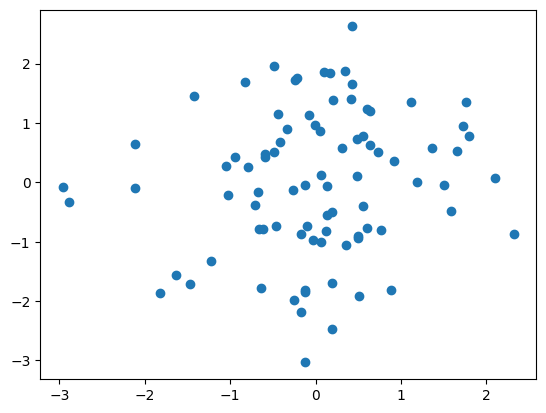

This is factor 218
genome_PC83
genome_PC83
MSE: 0.280
MAE: 0.134
SpearmanrResult(correlation=0.06994332616767637, pvalue=0.5247259260224799) [[1.         0.07543022]
 [0.07543022 1.        ]]


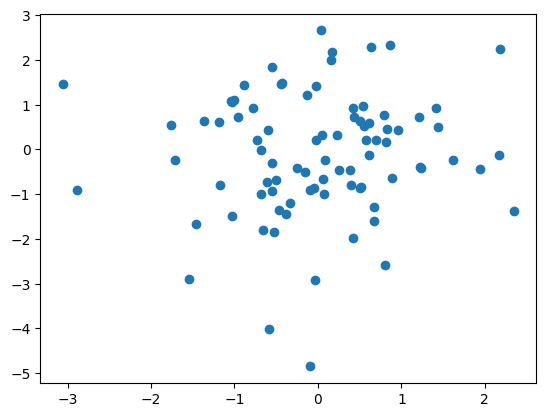

This is factor 219
genome_PC84
genome_PC84
MSE: 0.199
MAE: 0.119
SpearmanrResult(correlation=0.15143638850889193, pvalue=0.16651294659664) [[1.        0.1683793]
 [0.1683793 1.       ]]


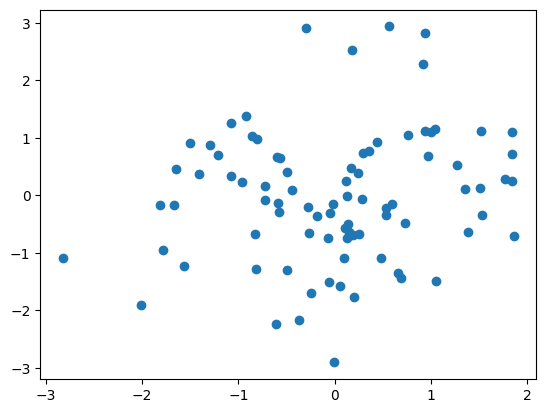

This is factor 220
genome_PC85
genome_PC85
MSE: 0.139
MAE: 0.096
SpearmanrResult(correlation=0.2500097713504006, pvalue=0.021020049331679985) [[1.         0.25052412]
 [0.25052412 1.        ]]


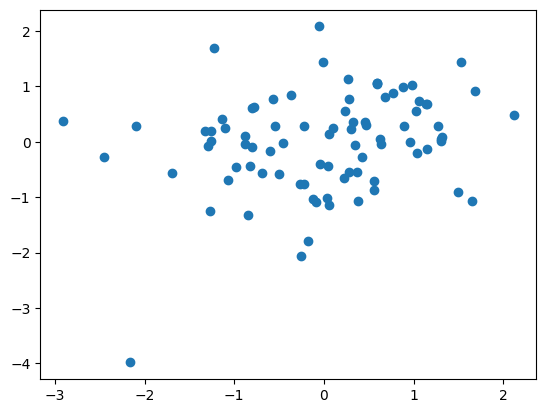

This is factor 221
genome_PC86
genome_PC86
MSE: 0.217
MAE: 0.120
SpearmanrResult(correlation=-0.025913621262458473, pvalue=0.8138875112523358) [[1.         0.06571606]
 [0.06571606 1.        ]]


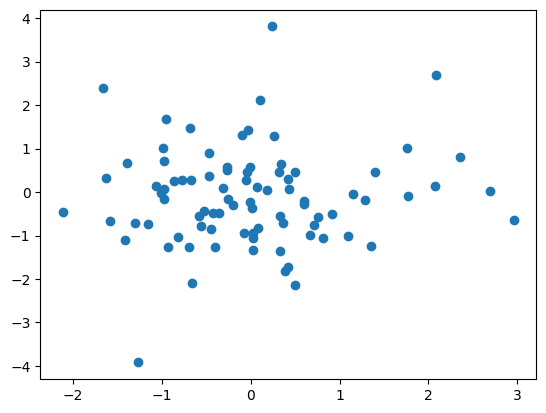

This is factor 222
genome_PC87
genome_PC87
MSE: 0.306
MAE: 0.144
SpearmanrResult(correlation=0.027965604846589796, pvalue=0.7994474374310578) [[1.        0.0289895]
 [0.0289895 1.       ]]


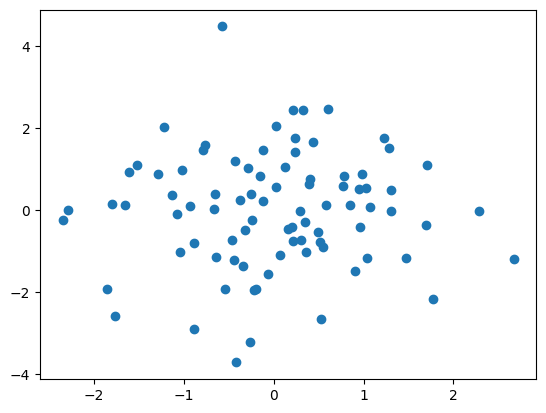

This is factor 223
genome_PC88
genome_PC88
MSE: 0.226
MAE: 0.117
SpearmanrResult(correlation=0.11399257377369554, pvalue=0.2989027099859253) [[1.         0.05689291]
 [0.05689291 1.        ]]


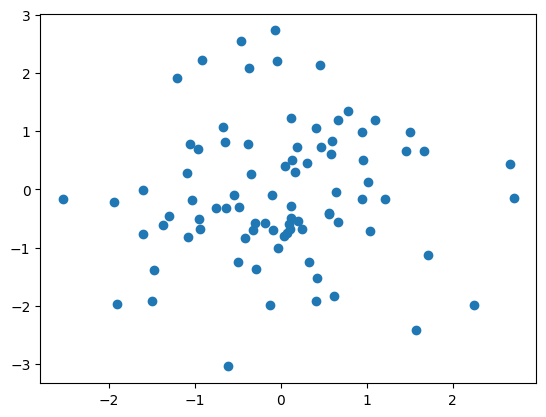

This is factor 224
genome_PC89
genome_PC89
MSE: 0.286
MAE: 0.138
SpearmanrResult(correlation=-0.04016025014657025, pvalue=0.7151679178226662) [[1.         0.00892247]
 [0.00892247 1.        ]]


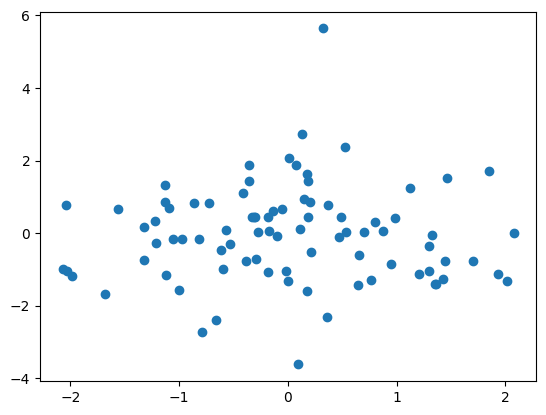

This is factor 225
genome_PC90
genome_PC90
MSE: 0.191
MAE: 0.115
SpearmanrResult(correlation=0.28915380105530586, pvalue=0.007274998070857832) [[1.         0.28707631]
 [0.28707631 1.        ]]


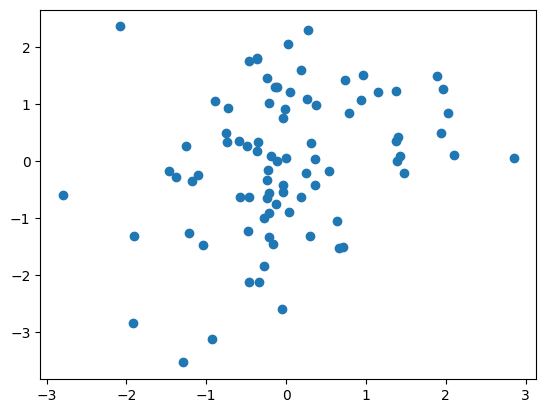

This is factor 226
genome_PC91
genome_PC91
MSE: 0.167
MAE: 0.103
SpearmanrResult(correlation=0.3316396325972249, pvalue=0.0019316508348502647) [[1.         0.36203977]
 [0.36203977 1.        ]]


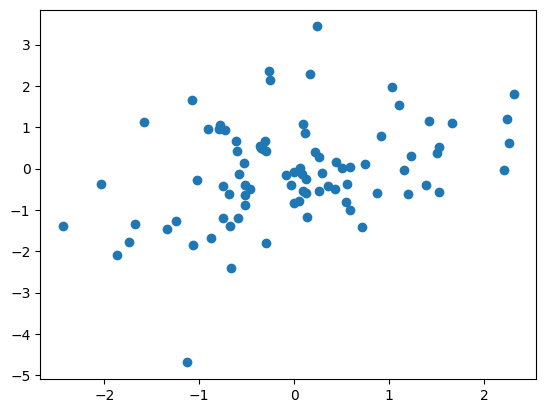

This is factor 227
genome_PC92
genome_PC92
MSE: 0.149
MAE: 0.088
SpearmanrResult(correlation=-0.02833691616181356, pvalue=0.796841497610848) [[1.         0.13839239]
 [0.13839239 1.        ]]


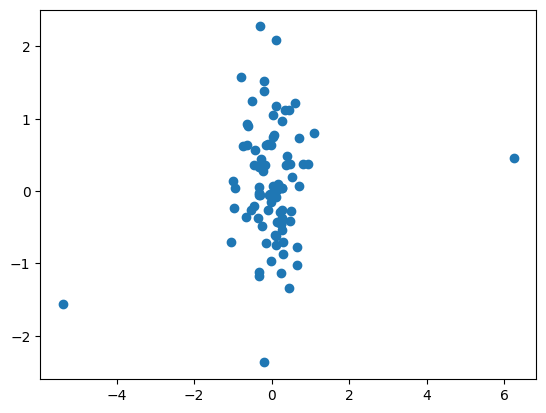

This is factor 228
Epithelial
Epithelial
MSE: 0.073
MAE: 0.072
SpearmanrResult(correlation=0.5830564784053156, pvalue=4.7672467776887145e-09) [[1.        0.6421454]
 [0.6421454 1.       ]]


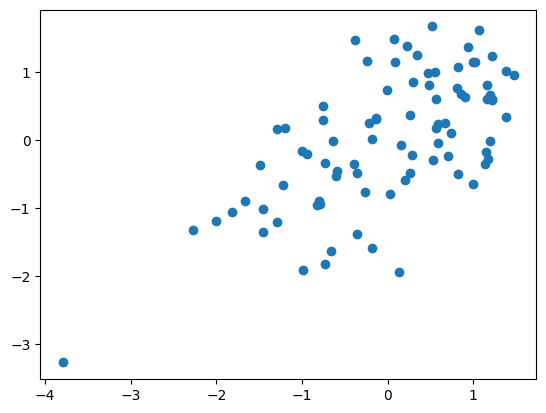

This is factor 229
Granulocyte
Granulocyte
MSE: 0.067
MAE: 0.069
SpearmanrResult(correlation=0.5998632010943912, pvalue=1.3045603762240534e-09) [[1.         0.67978144]
 [0.67978144 1.        ]]


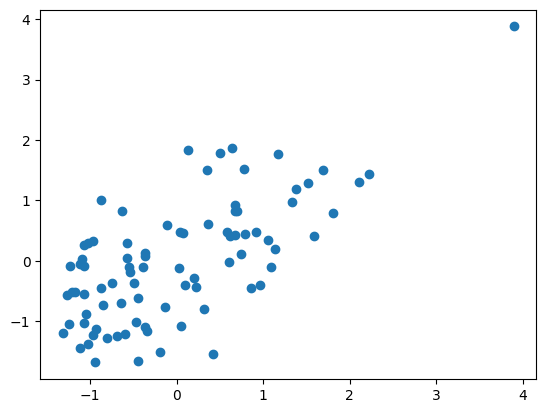

This is factor 230
NKcell
NKcell
MSE: 0.191
MAE: 0.113
SpearmanrResult(correlation=0.2654605187775852, pvalue=0.014072256033196534) [[1.         0.28306351]
 [0.28306351 1.        ]]


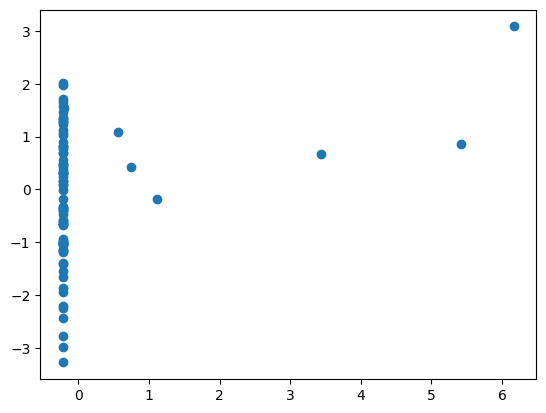

[(-0.32454659542772296, 'sthlth'), (-0.2440423749878777, 'night'), (-0.14676568301739298, 'genome_PC41'), (-0.1447527848348642, 'genome_PC66'), (-0.12609723724831565, 'A1C'), (-0.09095172952902092, 'genome_PC53'), (-0.08032835524527066, 'walk_dayPerWeek'), (-0.06615154071400131, 'confid'), (-0.05800273597811217, 'genome_PC28'), (-0.05205238912480422, 'RDW'), (-0.05134333729327081, 'stress'), (-0.05063513777604065, 'genome_PC70'), (-0.0478014461598593, 'genome_PC18'), (-0.04016025014657025, 'genome_PC89'), (-0.036627008608582985, 'sodium'), (-0.03504006253664256, 'genome_PC55'), (-0.02833691616181356, 'genome_PC92'), (-0.025913621262458473, 'genome_PC86'), (-0.017869052277297195, 'walk_minPerDay'), (-0.015165135821770568, 'genome_PC30'), (-0.013054524135235489, 'genome_PC12'), (-0.001895641977721321, 'genome_PC69'), (0.0, 'genome_PC60'), (0.00013835423015168445, 'bilirubin'), (0.005628297830760211, 'genome_PC72'), (0.005836055417976879, 'vig_minPerDay'), (0.010402974676182408, 'AST'), (

[(-0.3579207373686179, 'sthlth'),
 (-0.16293909513788168, 'genome_PC66'),
 (-0.14430855411482124, 'genome_PC41'),
 (-0.11694563649630359, 'A1C'),
 (-0.0947550974691096, 'genome_PC28'),
 (-0.09288338876641666, 'genome_PC53'),
 (-0.07682067340465998, 'AST'),
 (-0.06377075649991075, 'genome_PC30'),
 (-0.0619992458723404, 'genome_PC55'),
 (-0.0447941745957353, 'sodium'),
 (-0.036936408389454806, 'stress'),
 (-0.03535531676341291, 'genome_PC70'),
 (-0.03066363278232535, 'control'),
 (-0.019119098207295886, 'walk_dayPerWeek'),
 (-0.015338310301908964, 'vig_minPerDay'),
 (-0.013287026788519372, 'night'),
 (-0.002051722009973147, 'confid'),
 (0.0030393315188386996, 'alc'),
 (0.008801440695000091, 'RDW'),
 (0.008922467835221078, 'genome_PC89'),
 (0.014173755012730828, 'genome_PC75'),
 (0.015157342221916902, 'genome_PC12'),
 (0.015184456887365054, 'genome_PC64'),
 (0.015860104448702648, 'genome_PC60'),
 (0.02760441167527804, 'fiber'),
 (0.028322696150571893, 'walk_none'),
 (0.02898949549273035, 

In [29]:
#FILTERED AGAINST AGE,SEX
count_factor = 0
count_cv = 0
corrsP = []
corrsS = []

for each_factor in third_factor:
    count_cv, sum_mse, sum_mae, sum_p = 0,0,0,0
    print("This is factor", count_factor)
    print(each_factor)
    df_traits_s = df_traits[~df_traits.index.duplicated(keep='first')]
    traits = ['age','sex', each_factor] # manully input base factors, change to AGE and SEX
    phenos_ctype = []
    for num,(ind, row) in enumerate(df_meth.iterrows()):
        phenos_ctype.append(list(df_traits_s.loc[row.name][traits]))
    phenos_ctype = np.array(phenos_ctype)

    # K-fold Cross validation - KFold(n_splits=5, *, shuffle=False, random_state=None)
    X = phenos_ctype
    y = meth_multi_as
    kf = KFold(n_splits=10, shuffle=True)
    # kf.get_n_splits(X)
    
    all_phenos_true, all_phenos_pred = [], []
    
    for train_ix, test_ix in kf.split(X):
        y_true, y_pred = list(), list()

        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y.T[train_ix,:], y.T[test_ix,:]
        y_train = y_train.T
        y_test = y_test.T
        
        #choose third factor sites
        third_site = filter_sites_partial_order2(y.T, X[:,2], X[:,0], X[:,1], 70)
        third_site = third_site.T
        y_train = np.append(y_train,third_site[train_ix].T,axis = 0)
        y_test = np.append(y_test,third_site[test_ix].T,axis = 0)
        
        # fit model
        msepm_md = MultistateEpigeneticPacemaker(verbose = False, iter_limit = 80)   
        #print(X_train)
        #print('Y', y_train)
        #print(X_train)
        #print(y_train)
        msepm_md.fit(X_train, y_train)
        
        #print("X:", X_train.shape)
        #print("Y:", y_train.shape)
        
        matrix_of_coeff = msepm_md._coefs
        #print(matrix_of_coeff.shape)
        
        # evaluate model
        pred_md, site_residual = msepm_md.predict(y_test, True)
        #yhat = np.add(site_residual, y_test)
        
        # store
        all_phenos_true.append(X_test[:,2])
        all_phenos_pred.append(pred_md[:,2])
        mse = mean_squared_error(X_test[:,2], pred_md[:,2])
        mae = mean_absolute_error(X_test[:,2], pred_md[:,2])
        sum_mse = sum_mse + mse
        sum_mae = sum_mae + mae
    
    # calculate accuracy
    avg_mse = sum_mse/96
    avg_mae = sum_mae/96
    #avg_p = sum_p/96
    print(each_factor)
    print('MSE: %.3f' % avg_mse)
    print('MAE: %.3f' % avg_mae)
    all_phenos_true = [val for sublist in all_phenos_true for val in sublist]
    all_phenos_pred = [val for sublist in all_phenos_pred for val in sublist]
    p_corr2 = np.corrcoef(all_phenos_true, all_phenos_pred)
    s_corr2 = stats.spearmanr(all_phenos_true, all_phenos_pred)
    print(s_corr2,p_corr2)
    corrsP.append(p_corr2)
    corrsS.append(s_corr2)
    
    scatterplot = plt.scatter(all_phenos_true, all_phenos_pred)
#     ax = plt.gca()
#     ax.axline([0, 0], [1, 1])
    plt.show(scatterplot)
    
    count_factor=count_factor+1
    
corrs3 = []

for i in range(len(corrsS)):
    corrs3.append(corrsS[i][0])

factorCorrsS = list(zip(corrs3,third_factor))
factorCorrsS.sort()
print(factorCorrsS)

corrs2 = []

for i in corrsP:
    corrs2.append(i[0][1])

factorCorrs = list(zip(corrs2,third_factor))
factorCorrs.sort()
factorCorrs

In [47]:
#FILTERED AGAINST SEX
count_factor = 0
count_cv = 0
corrsP = []
corrsS = []

for each_factor in third_factor:
    count_cv, sum_mse, sum_mae, sum_p = 0,0,0,0
    print("This is factor", count_factor)
    print(each_factor)
    df_traits_s = df_traits[~df_traits.index.duplicated(keep='first')]
    traits = ['age','sex', each_factor] # manully input base factors, change to AGE and SEX
    phenos_ctype = []
    for num,(ind, row) in enumerate(df_meth.iterrows()):
        phenos_ctype.append(list(df_traits_s.loc[row.name][traits]))
    phenos_ctype = np.array(phenos_ctype)

    # K-fold Cross validation - KFold(n_splits=5, *, shuffle=False, random_state=None)
    X = phenos_ctype
    y = meth_multi_as
    kf = KFold(n_splits=10, shuffle=True)
    # kf.get_n_splits(X)
    
    all_phenos_true, all_phenos_pred = [], []
    
    for train_ix, test_ix in kf.split(X):
        y_true, y_pred = list(), list()

        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y.T[train_ix,:], y.T[test_ix,:]
        y_train = y_train.T
        y_test = y_test.T
        
        #choose third factor sites
        third_site = filter_sites_partial(y.T, X[:,2], X[:,1], 70)
        third_site = third_site.T
        y_train = np.append(y_train,third_site[train_ix].T,axis = 0)
        y_test = np.append(y_test,third_site[test_ix].T,axis = 0)
        
        # fit model
        msepm_md = MultistateEpigeneticPacemaker(verbose = False, iter_limit = 80)       
        msepm_md.fit(X_train, y_train)
        print(msepm_md)
        
        # evaluate model
        pred_md, site_residual = msepm_md.predict(y_test, True)
        #yhat = np.add(site_residual, y_test)
        
        # store
        all_phenos_true.append(X_test[:,2])
        all_phenos_pred.append(pred_md[:,2])
        mse = mean_squared_error(X_test[:,2], pred_md[:,2])
        mae = mean_absolute_error(X_test[:,2], pred_md[:,2])
        sum_mse = sum_mse + mse
        sum_mae = sum_mae + mae
    
    # calculate accuracy
    avg_mse = sum_mse/96
    avg_mae = sum_mae/96
    #avg_p = sum_p/96
    print(each_factor)
    print('MSE: %.3f' % avg_mse)
    print('MAE: %.3f' % avg_mae)
    all_phenos_true = [val for sublist in all_phenos_true for val in sublist]
    all_phenos_pred = [val for sublist in all_phenos_pred for val in sublist]
    p_corr2 = np.corrcoef(all_phenos_true, all_phenos_pred)
    s_corr2 = stats.spearmanr(all_phenos_true, all_phenos_pred)
    print(s_corr2,p_corr2)
    corrsP.append(p_corr2)
    corrsS.append(s_corr2)
    
    scatterplot = plt.scatter(all_phenos_true, all_phenos_pred)
#     ax = plt.gca()
#     ax.axline([0, 0], [1, 1])
    plt.show(scatterplot)
    
    count_factor=count_factor+1
    
corrs3 = []

for i in range(len(corrsS)):
    corrs3.append(corrsS[i][0])

factorCorrsS = list(zip(corrs3,third_factor))
factorCorrsS.sort()
print(factorCorrsS)

corrs2 = []

for i in corrsP:
    corrs2.append(i[0][1])

factorCorrs = list(zip(corrs2,third_factor))
factorCorrs.sort()
factorCorrs

This is factor 0
sex


ValueError: setting an array element with a sequence.

This is factor 0
weight
weight
MSE: 84.506
MAE: 2.516
SpearmanrResult(correlation=0.15935103832484912, pvalue=0.12095209494379161) [[1.         0.16467454]
 [0.16467454 1.        ]]


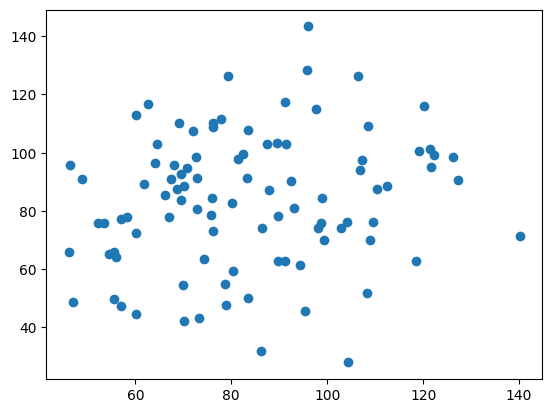

This is factor 1
height
height
MSE: 8.538
MAE: 0.753
SpearmanrResult(correlation=0.5412078329124204, pvalue=1.2472858259015445e-08) [[1.         0.49528947]
 [0.49528947 1.        ]]


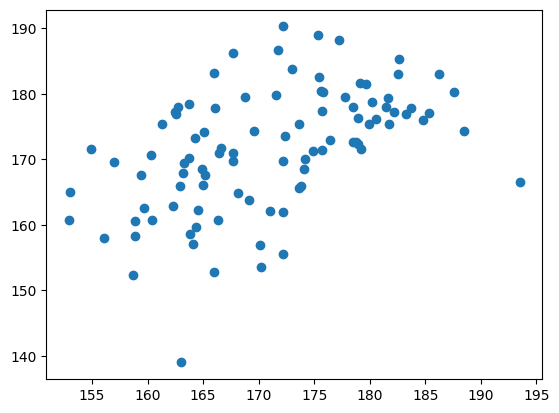

This is factor 2
bmi
bmi
MSE: 8.086
MAE: 0.740
SpearmanrResult(correlation=0.14888601847644334, pvalue=0.1476863206989525) [[1.         0.10457505]
 [0.10457505 1.        ]]


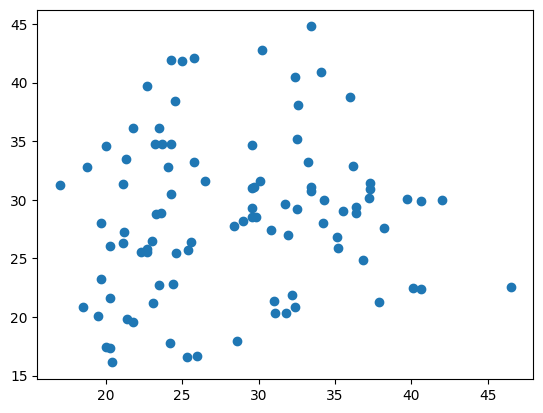

This is factor 3
bpm
bpm
MSE: 27.367
MAE: 1.355
SpearmanrResult(correlation=0.02892550495398721, pvalue=0.7796640171791742) [[1.        0.0463739]
 [0.0463739 1.       ]]


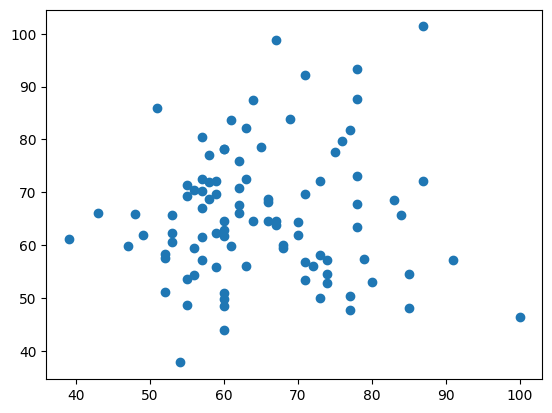

This is factor 4
sysBP
sysBP
MSE: 36.422
MAE: 1.437
SpearmanrResult(correlation=0.23736706989460343, pvalue=0.019878519998632698) [[1.         0.20057735]
 [0.20057735 1.        ]]


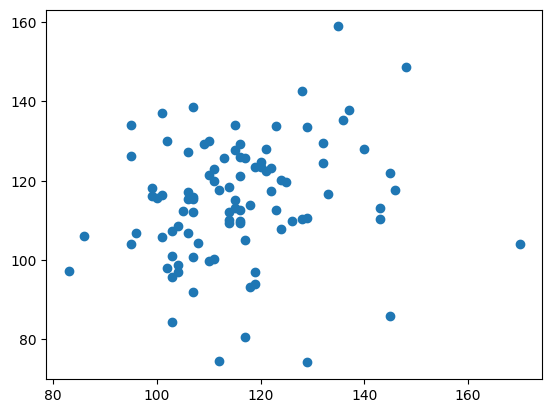

This is factor 5
diaBP
diaBP
MSE: 23.003
MAE: 1.178
SpearmanrResult(correlation=0.2933609902951788, pvalue=0.003722146643166499) [[1.        0.2545324]
 [0.2545324 1.       ]]


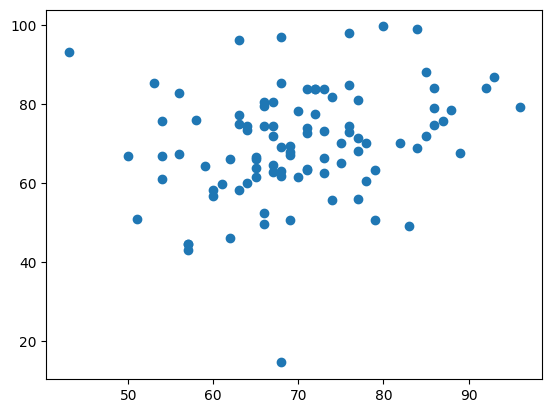

This is factor 6
SECA_fat
SECA_fat
MSE: 36.664
MAE: 1.605
SpearmanrResult(correlation=0.2968328738971111, pvalue=0.0033166960890295256) [[1.         0.25599958]
 [0.25599958 1.        ]]


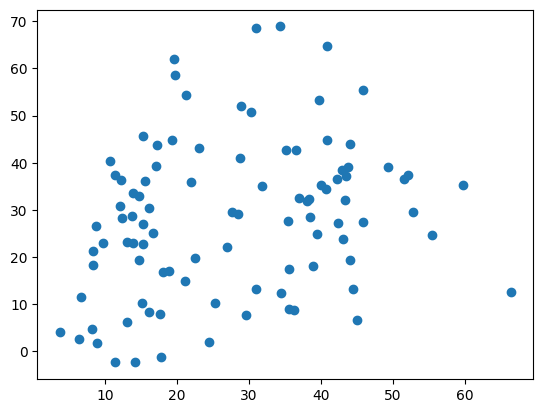

This is factor 7
SECA_fatfree
SECA_fatfree
MSE: 10.857
MAE: 0.878
SpearmanrResult(correlation=0.6721177496699624, pvalue=6.512221827453547e-14) [[1.         0.62901395]
 [0.62901395 1.        ]]


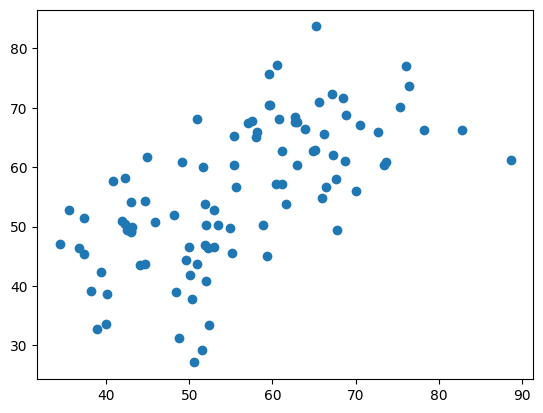

This is factor 8
SECA_fatPercent
SECA_fatPercent
MSE: 21.642
MAE: 1.221
SpearmanrResult(correlation=0.30238615269827773, pvalue=0.002749953274507147) [[1.         0.31468042]
 [0.31468042 1.        ]]


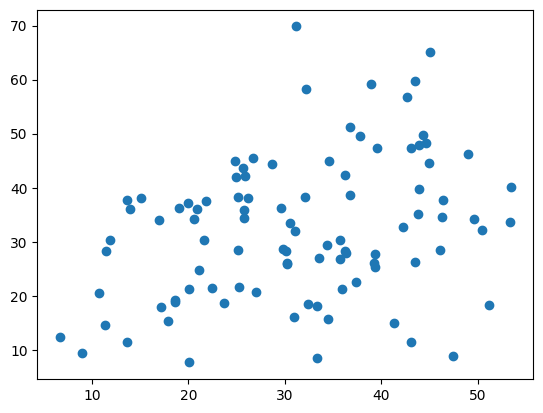

This is factor 9
waist
waist
MSE: 50.263
MAE: 1.834
SpearmanrResult(correlation=0.30497367778798484, pvalue=0.002516924914363923) [[1.         0.28258906]
 [0.28258906 1.        ]]


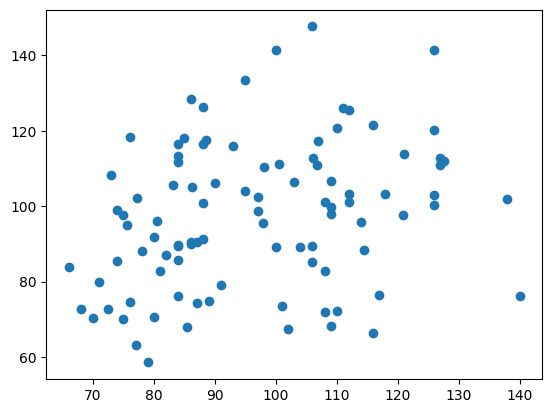

This is factor 10
abdomDiam
abdomDiam
MSE: 5.593
MAE: 0.607
SpearmanrResult(correlation=0.22373566806903136, pvalue=0.028430421365952314) [[1.         0.17486412]
 [0.17486412 1.        ]]


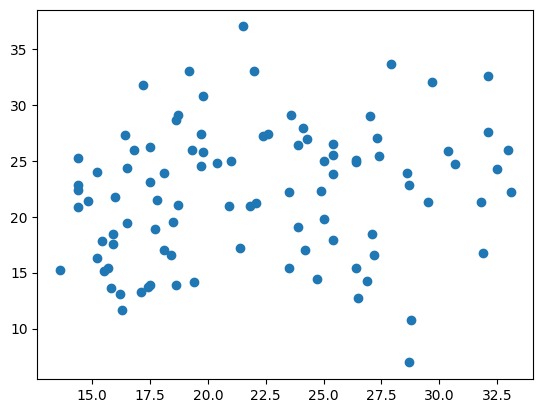

This is factor 11
wbc
wbc
MSE: 0.442
MAE: 0.167
SpearmanrResult(correlation=0.20456313013166527, pvalue=0.04558233252154034) [[1.         0.28381999]
 [0.28381999 1.        ]]


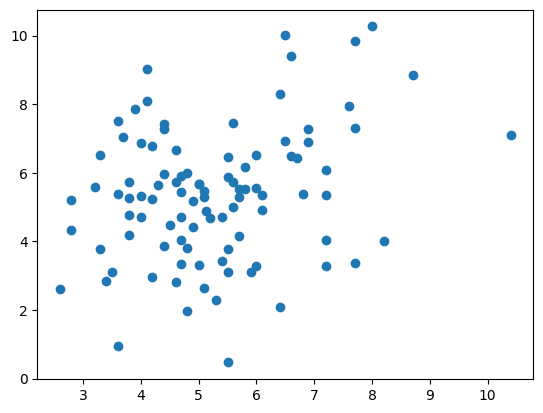

This is factor 12
hemoglobin
hemoglobin
MSE: 0.212
MAE: 0.113
SpearmanrResult(correlation=0.44713758936801573, pvalue=4.945322447022316e-06) [[1.         0.37796604]
 [0.37796604 1.        ]]


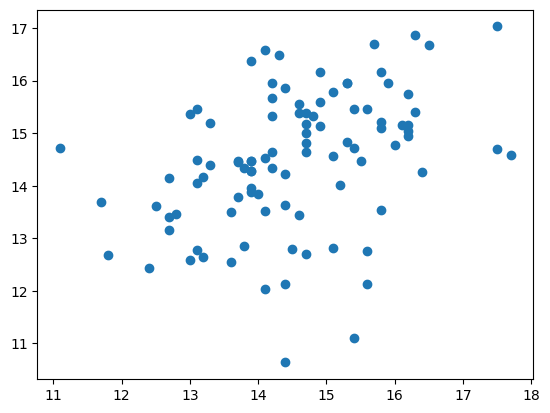

This is factor 13
hematocrit
hematocrit
MSE: 96.647
MAE: 2.026
SpearmanrResult(correlation=-0.05578637886789298, pvalue=0.5892982435056107) [[ 1.         -0.03538718]
 [-0.03538718  1.        ]]


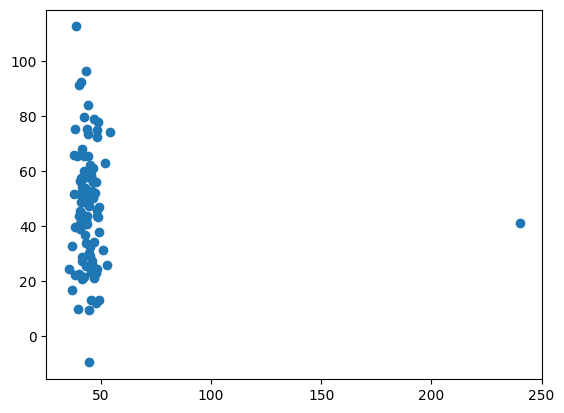

This is factor 14
neutrophils
neutrophils
MSE: 0.256
MAE: 0.126
SpearmanrResult(correlation=0.13145055830941976, pvalue=0.20173528783890235) [[1.        0.1654166]
 [0.1654166 1.       ]]


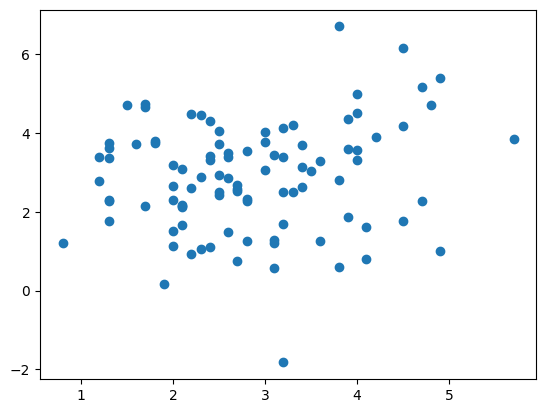

This is factor 15
lymphocytes
lymphocytes
MSE: 0.037
MAE: 0.050
SpearmanrResult(correlation=0.22508718111617418, pvalue=0.02746239985125001) [[1.        0.2898334]
 [0.2898334 1.       ]]


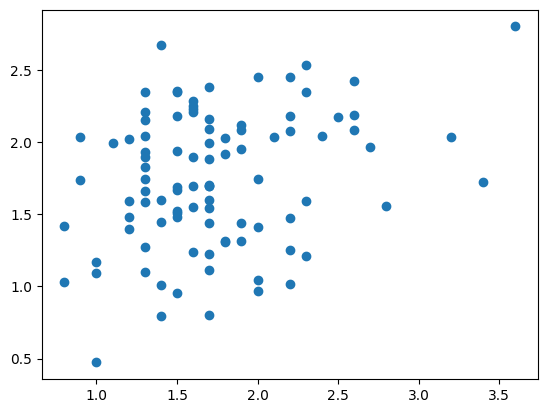

This is factor 16
monocytes
monocytes
MSE: 0.004
MAE: 0.015
SpearmanrResult(correlation=0.1020172528738612, pvalue=0.3226384419311329) [[1.         0.09170814]
 [0.09170814 1.        ]]


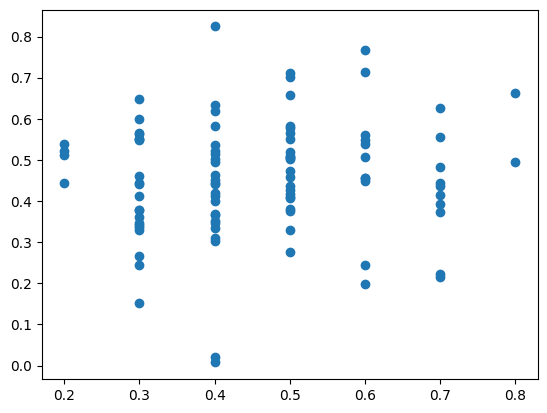

This is factor 17
eosinophils
eosinophils
MSE: 0.003
MAE: 0.015
SpearmanrResult(correlation=-0.0011379236068606996, pvalue=0.9912208300556509) [[ 1.         -0.01387254]
 [-0.01387254  1.        ]]


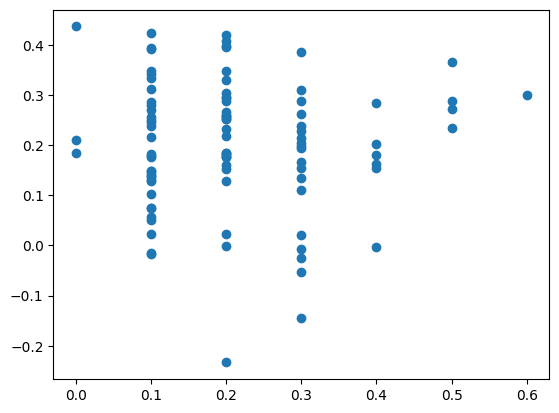

This is factor 18
basophils
basophils
MSE: 0.000
MAE: 0.005
SpearmanrResult(correlation=0.22478828975227577, pvalue=0.02767403648192265) [[1.         0.19242922]
 [0.19242922 1.        ]]


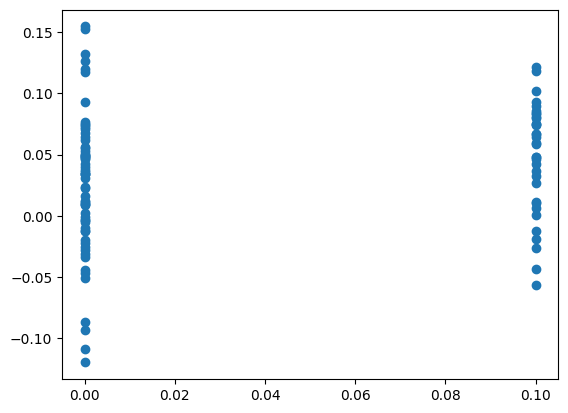

This is factor 19
glucose
glucose
MSE: 47.851
MAE: 1.720
SpearmanrResult(correlation=0.24696480172803872, pvalue=0.01527659686604531) [[1.        0.1873889]
 [0.1873889 1.       ]]


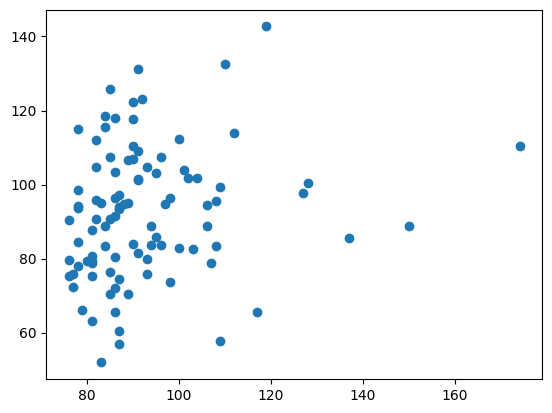

This is factor 20
BUN
BUN
MSE: 3.261
MAE: 0.456
SpearmanrResult(correlation=0.36624783409993517, pvalue=0.00024269524761180727) [[1.         0.32927028]
 [0.32927028 1.        ]]


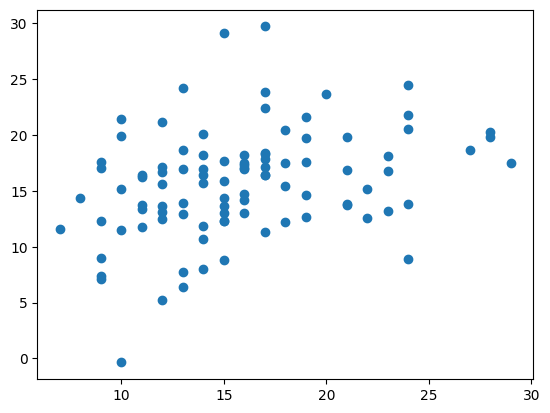

This is factor 21
creatinine
creatinine
MSE: 0.003
MAE: 0.015
SpearmanrResult(correlation=0.3805520835056268, pvalue=0.00013090812657308705) [[1.         0.32388934]
 [0.32388934 1.        ]]


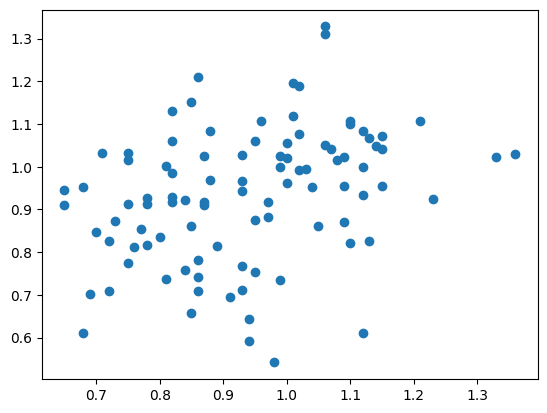

This is factor 22
sodium
sodium
MSE: 1.125
MAE: 0.258
SpearmanrResult(correlation=0.006415466590179822, pvalue=0.9505344086918233) [[ 1.         -0.02601425]
 [-0.02601425  1.        ]]


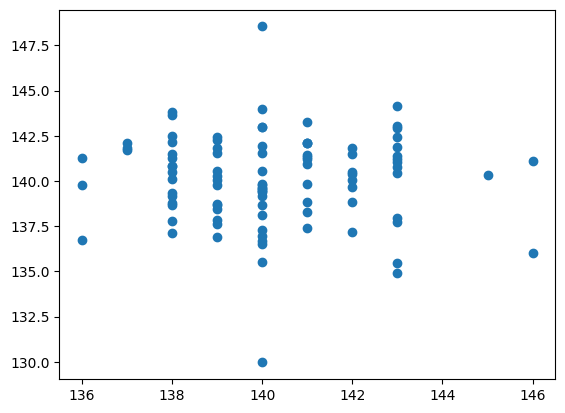

This is factor 23
potassium
potassium
MSE: 0.052
MAE: 0.058
SpearmanrResult(correlation=0.17620157662887945, pvalue=0.08593094089267866) [[1.         0.17262069]
 [0.17262069 1.        ]]


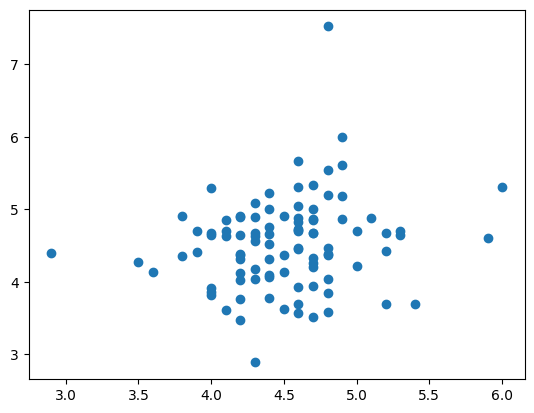

This is factor 24
chloride
chloride
MSE: 1.564
MAE: 0.338
SpearmanrResult(correlation=0.12744879190868338, pvalue=0.21592620448605887) [[1.         0.12227897]
 [0.12227897 1.        ]]


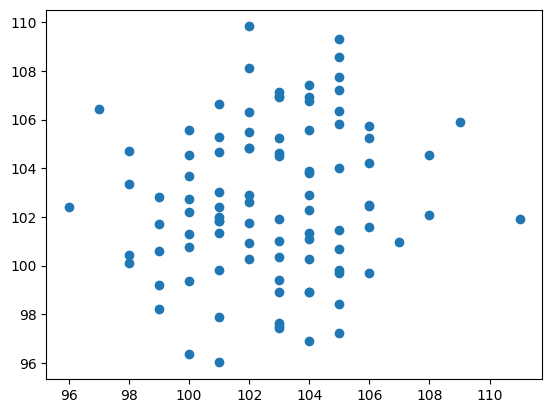

This is factor 25
C02
C02
MSE: 1.012
MAE: 0.254
SpearmanrResult(correlation=0.20087000053791867, pvalue=0.04971764850945588) [[1.         0.13609069]
 [0.13609069 1.        ]]


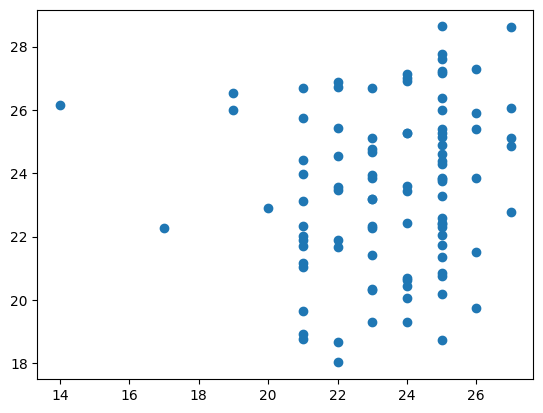

This is factor 26
calcium
calcium
MSE: 0.024
MAE: 0.040
SpearmanrResult(correlation=0.11599280878607715, pvalue=0.2604158213230683) [[1.         0.11985711]
 [0.11985711 1.        ]]


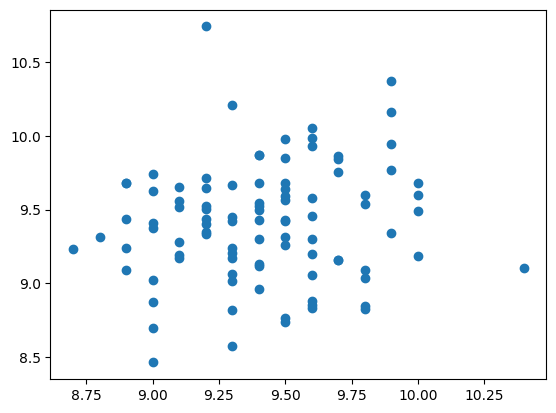

This is factor 27
protein
protein
MSE: 0.030
MAE: 0.045
SpearmanrResult(correlation=0.21908382293199993, pvalue=0.0319863079679691) [[1.         0.23435338]
 [0.23435338 1.        ]]


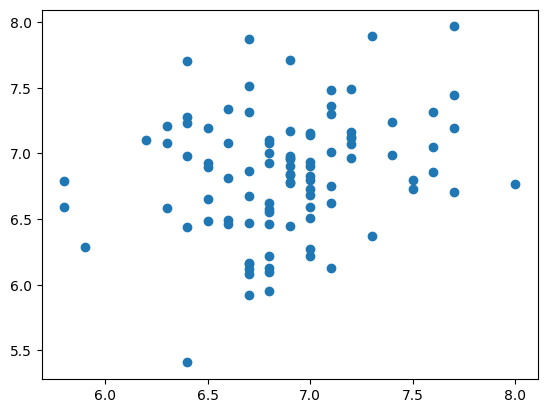

This is factor 28
albumin
albumin
MSE: 0.012
MAE: 0.029
SpearmanrResult(correlation=0.14109111758645607, pvalue=0.17032323350996212) [[1.         0.17874748]
 [0.17874748 1.        ]]


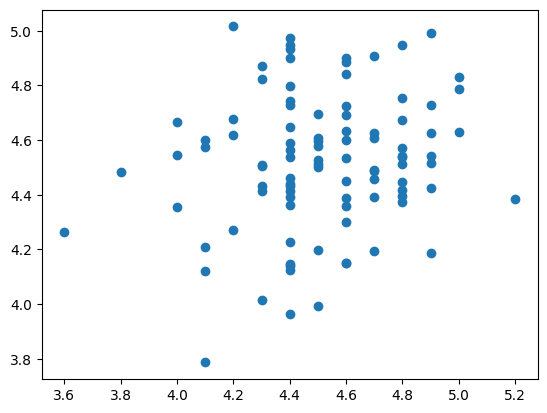

This is factor 29
globulin
globulin
MSE: 0.024
MAE: 0.037
SpearmanrResult(correlation=0.18730589270774398, pvalue=0.06764204403403996) [[1.        0.1398733]
 [0.1398733 1.       ]]


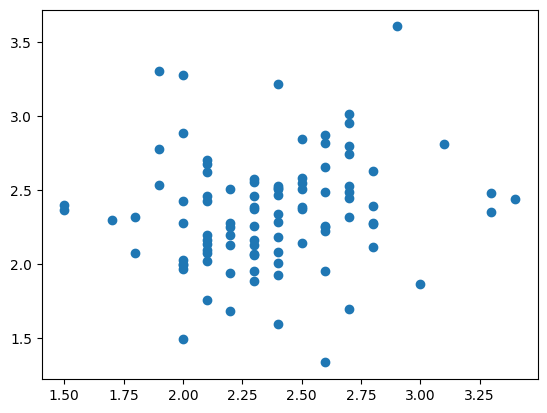

This is factor 30
bilirubin
bilirubin
MSE: 0.020
MAE: 0.036
SpearmanrResult(correlation=0.04752128558453845, pvalue=0.6456797231651922) [[1.         0.09551016]
 [0.09551016 1.        ]]


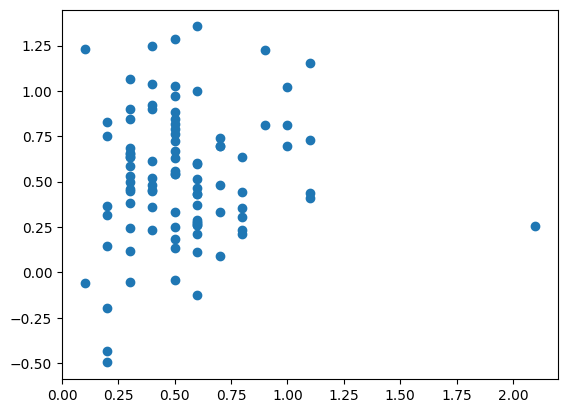

This is factor 31
alkaPhos
alkaPhos
MSE: 65.420
MAE: 1.993
SpearmanrResult(correlation=0.3847811260897437, pvalue=0.00010846890390107555) [[1.         0.39383254]
 [0.39383254 1.        ]]


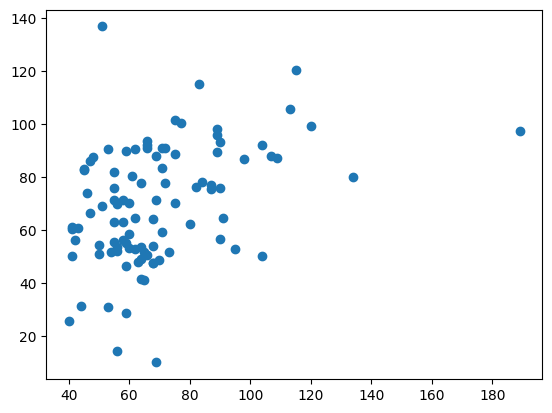

This is factor 32
AST
AST
MSE: 30.868
MAE: 1.115
SpearmanrResult(correlation=0.02674615247713306, pvalue=0.7958889840161588) [[ 1.        -0.0840685]
 [-0.0840685  1.       ]]


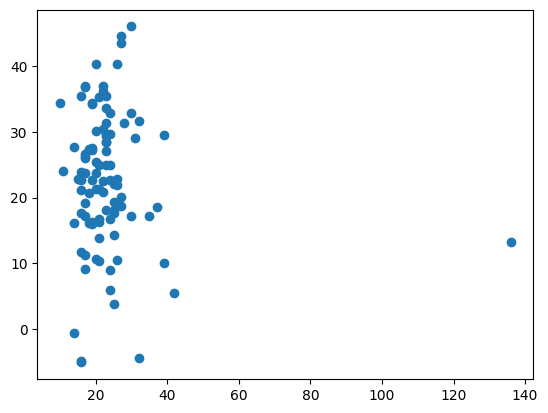

This is factor 33
ALT
ALT
MSE: 50.091
MAE: 1.449
SpearmanrResult(correlation=0.12840894599277455, pvalue=0.21245853811041762) [[1.         0.02564739]
 [0.02564739 1.        ]]


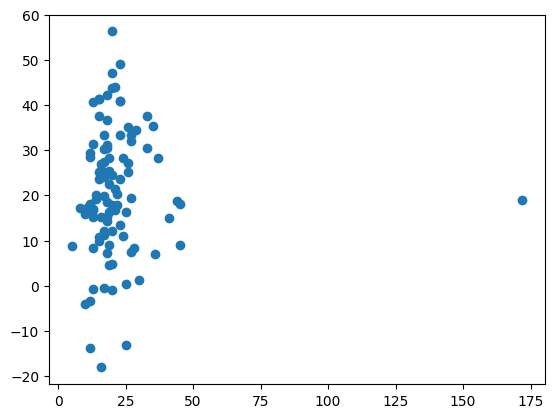

This is factor 34
chol
chol
MSE: 228.816
MAE: 3.954
SpearmanrResult(correlation=-0.012311720662174917, pvalue=0.9052325426474175) [[1.        0.0217069]
 [0.0217069 1.       ]]


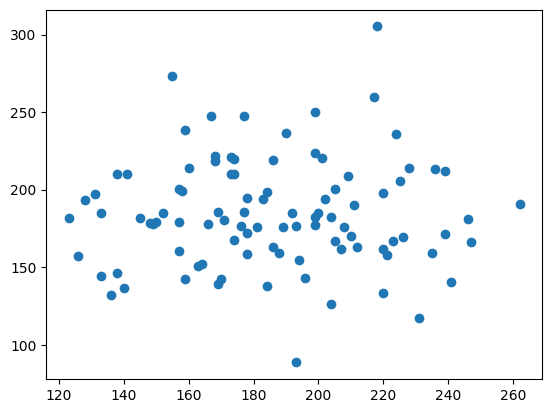

This is factor 35
trigly
trigly
MSE: 1553.360
MAE: 9.423
SpearmanrResult(correlation=0.08290707518751272, pvalue=0.42193833171727224) [[1.         0.05502181]
 [0.05502181 1.        ]]


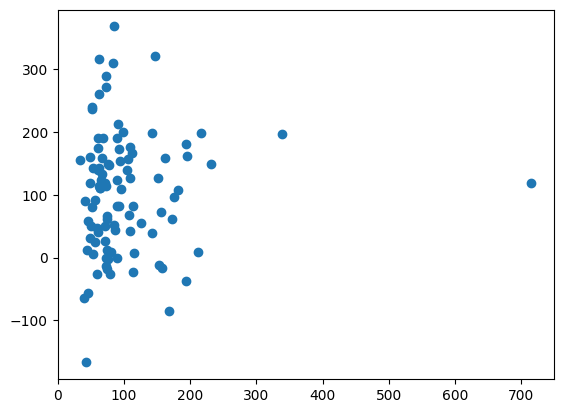

This is factor 36
HDL
HDL
MSE: 90.284
MAE: 2.431
SpearmanrResult(correlation=-0.21969657917841356, pvalue=0.031497467419942304) [[ 1.         -0.16334971]
 [-0.16334971  1.        ]]


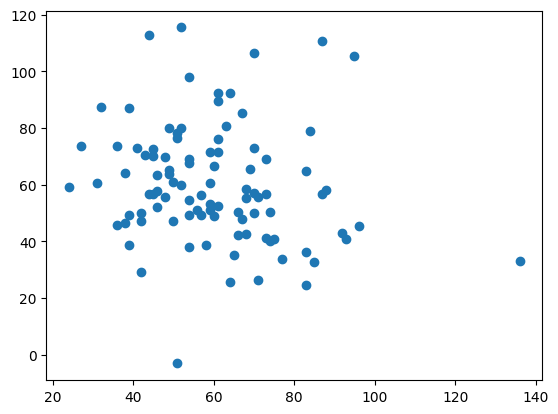

This is factor 37
LDL
LDL
MSE: 149.473
MAE: 3.191
SpearmanrResult(correlation=0.2183274933108332, pvalue=0.032598496101564976) [[1.         0.25043437]
 [0.25043437 1.        ]]


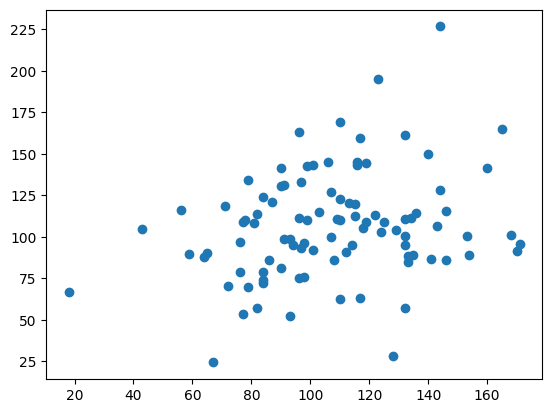

This is factor 38
cortisol
cortisol
MSE: 3.304
MAE: 0.469
SpearmanrResult(correlation=0.28235757159167285, pvalue=0.005315882307900928) [[1.         0.21107998]
 [0.21107998 1.        ]]


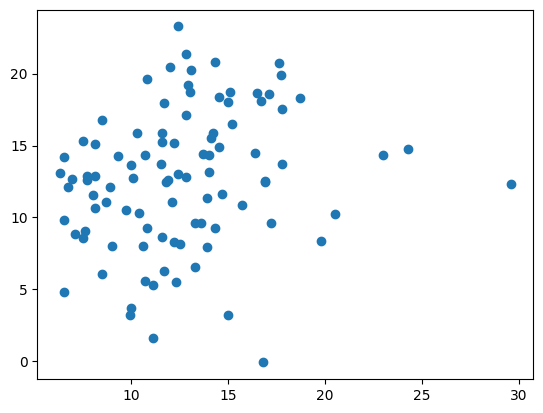

This is factor 39
TSH
TSH
MSE: 3.703
MAE: 0.436
SpearmanrResult(correlation=0.07279158227400523, pvalue=0.48093344354397394) [[1.         0.04939228]
 [0.04939228 1.        ]]


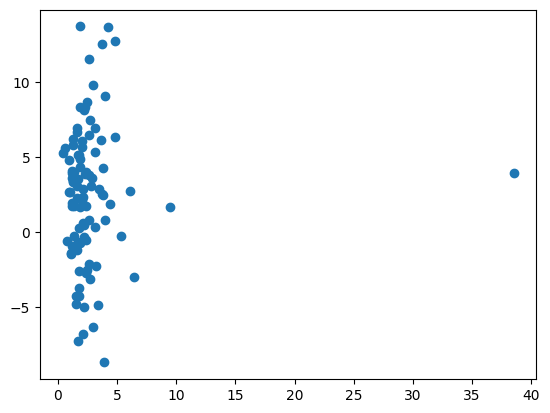

This is factor 40
calcitriol_vitD
calcitriol_vitD
MSE: 40.636
MAE: 1.644
SpearmanrResult(correlation=0.017411653027911943, pvalue=0.8662869767786427) [[1.         0.06980549]
 [0.06980549 1.        ]]


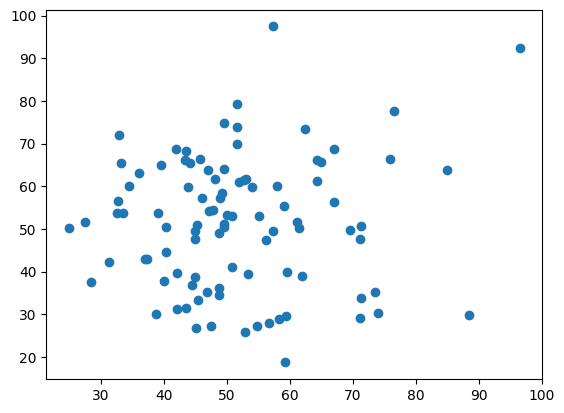

This is factor 41
CRP
CRP
MSE: 1.184
MAE: 0.257
SpearmanrResult(correlation=-0.004713413475617104, pvalue=0.9636473070961202) [[ 1.         -0.04942756]
 [-0.04942756  1.        ]]


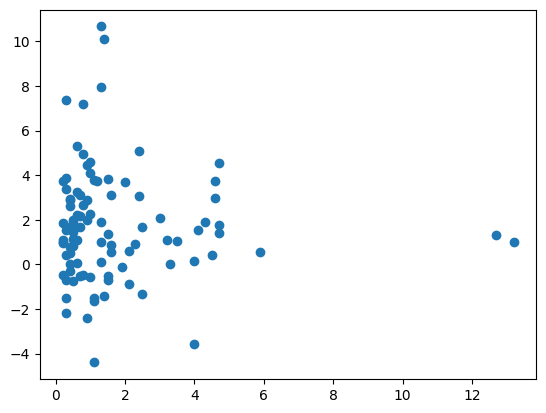

This is factor 42
B12
B12
MSE: 20692.092
MAE: 36.149
SpearmanrResult(correlation=-0.14153211725644405, pvalue=0.1689779324880938) [[ 1.         -0.14921988]
 [-0.14921988  1.        ]]


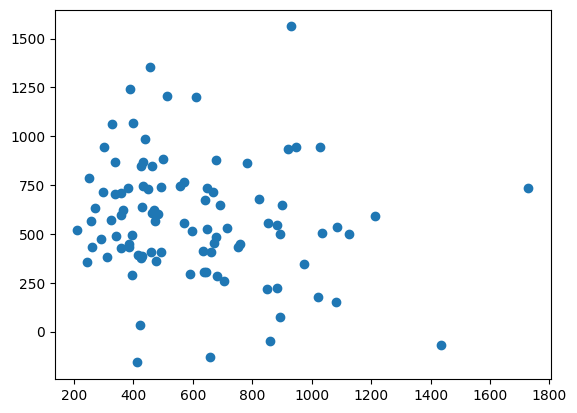

This is factor 43
insulin
insulin
MSE: 27.349
MAE: 1.159
SpearmanrResult(correlation=-0.062259185716835135, pvalue=0.5467700840743355) [[ 1.         -0.14459008]
 [-0.14459008  1.        ]]


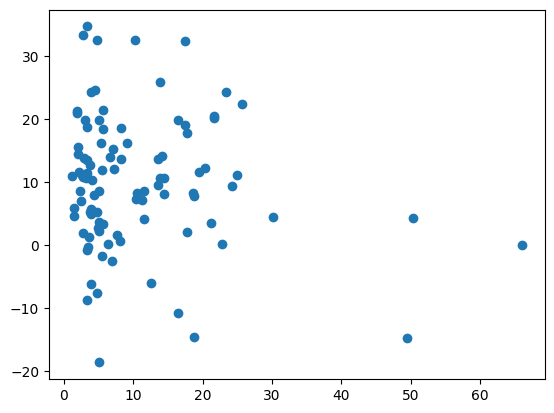

This is factor 44
freeT3
freeT3
MSE: 0.065
MAE: 0.061
SpearmanrResult(correlation=0.24374174113472244, pvalue=0.01670671877253141) [[1.         0.23172612]
 [0.23172612 1.        ]]


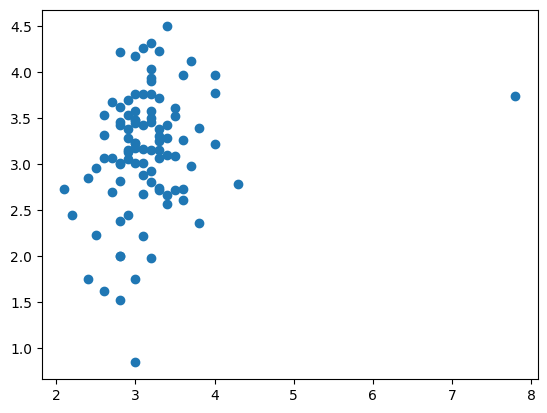

[(-0.21969657917841356, 'HDL'), (-0.14153211725644405, 'B12'), (-0.062259185716835135, 'insulin'), (-0.05578637886789298, 'hematocrit'), (-0.012311720662174917, 'chol'), (-0.004713413475617104, 'CRP'), (-0.0011379236068606996, 'eosinophils'), (0.006415466590179822, 'sodium'), (0.017411653027911943, 'calcitriol_vitD'), (0.02674615247713306, 'AST'), (0.02892550495398721, 'bpm'), (0.04752128558453845, 'bilirubin'), (0.07279158227400523, 'TSH'), (0.08290707518751272, 'trigly'), (0.1020172528738612, 'monocytes'), (0.11599280878607715, 'calcium'), (0.12744879190868338, 'chloride'), (0.12840894599277455, 'ALT'), (0.13145055830941976, 'neutrophils'), (0.14109111758645607, 'albumin'), (0.14888601847644334, 'bmi'), (0.15935103832484912, 'weight'), (0.17620157662887945, 'potassium'), (0.18730589270774398, 'globulin'), (0.20087000053791867, 'C02'), (0.20456313013166527, 'wbc'), (0.2183274933108332, 'LDL'), (0.21908382293199993, 'protein'), (0.22373566806903136, 'abdomDiam'), (0.22478828975227577, 

[(-0.16334971296803655, 'HDL'),
 (-0.14921988457794433, 'B12'),
 (-0.14459007734697793, 'insulin'),
 (-0.08406849533873446, 'AST'),
 (-0.04942756190263767, 'CRP'),
 (-0.035387181351904336, 'hematocrit'),
 (-0.02601425319795021, 'sodium'),
 (-0.013872535217993124, 'eosinophils'),
 (0.021706898339807053, 'chol'),
 (0.02564739372056796, 'ALT'),
 (0.04637390276502229, 'bpm'),
 (0.0493922780931585, 'TSH'),
 (0.05502180576385708, 'trigly'),
 (0.06980548867324958, 'calcitriol_vitD'),
 (0.09170814180326933, 'monocytes'),
 (0.09551015721010918, 'bilirubin'),
 (0.10457505469526665, 'bmi'),
 (0.11985711007749282, 'calcium'),
 (0.1222789670477617, 'chloride'),
 (0.1360906945490206, 'C02'),
 (0.13987330238471923, 'globulin'),
 (0.16467453918892566, 'weight'),
 (0.16541660131933358, 'neutrophils'),
 (0.17262068870212632, 'potassium'),
 (0.17486412215154587, 'abdomDiam'),
 (0.17874747663182017, 'albumin'),
 (0.18738889831141922, 'glucose'),
 (0.19242922373401725, 'basophils'),
 (0.20057735405844904, 

In [54]:
#FILTERED AGAINST AGE
count_factor = 0
count_cv = 0
corrsP = []
corrsS = []

for each_factor in third_factor:
    count_cv, sum_mse, sum_mae, sum_p = 0,0,0,0
    print("This is factor", count_factor)
    print(each_factor)
    df_traits_s = df_traits[~df_traits.index.duplicated(keep='first')]
    traits = ['age','sex', each_factor] # manully input base factors, change to AGE and SEX
    phenos_ctype = []
    for num,(ind, row) in enumerate(df_meth.iterrows()):
        phenos_ctype.append(list(df_traits_s.loc[row.name][traits]))
    phenos_ctype = np.array(phenos_ctype)

    # K-fold Cross validation - KFold(n_splits=5, *, shuffle=False, random_state=None)
    X = phenos_ctype
    y = meth_multi_as
    kf = KFold(n_splits=10, shuffle=True)
    # kf.get_n_splits(X)
    
    all_phenos_true, all_phenos_pred = [], []
    
    for train_ix, test_ix in kf.split(X):
        y_true, y_pred = list(), list()

        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y.T[train_ix,:], y.T[test_ix,:]
        y_train = y_train.T
        y_test = y_test.T
        
        #choose third factor sites
        third_site = filter_sites_partial(y.T, X[:,2], X[:,0], 70)
        third_site = third_site.T
        y_train = np.append(y_train,third_site[train_ix].T,axis = 0)
        y_test = np.append(y_test,third_site[test_ix].T,axis = 0)
        
        # fit model
        msepm_md = MultistateEpigeneticPacemaker(verbose = False, iter_limit = 80)       
        msepm_md.fit(X_train, y_train)
        
        # evaluate model
        pred_md, site_residual = msepm_md.predict(y_test, True)
        #yhat = np.add(site_residual, y_test)
        
        # store
        all_phenos_true.append(X_test[:,2])
        all_phenos_pred.append(pred_md[:,2])
        mse = mean_squared_error(X_test[:,2], pred_md[:,2])
        mae = mean_absolute_error(X_test[:,2], pred_md[:,2])
        sum_mse = sum_mse + mse
        sum_mae = sum_mae + mae
    
    # calculate accuracy
    avg_mse = sum_mse/96
    avg_mae = sum_mae/96
    #avg_p = sum_p/96
    print(each_factor)
    print('MSE: %.3f' % avg_mse)
    print('MAE: %.3f' % avg_mae)
    all_phenos_true = [val for sublist in all_phenos_true for val in sublist]
    all_phenos_pred = [val for sublist in all_phenos_pred for val in sublist]
    p_corr2 = np.corrcoef(all_phenos_true, all_phenos_pred)
    s_corr2 = stats.spearmanr(all_phenos_true, all_phenos_pred)
    print(s_corr2,p_corr2)
    corrsP.append(p_corr2)
    corrsS.append(s_corr2)
    
    scatterplot = plt.scatter(all_phenos_true, all_phenos_pred)
#     ax = plt.gca()
#     ax.axline([0, 0], [1, 1])
    plt.show(scatterplot)
    
    count_factor=count_factor+1
    
corrs3 = []

for i in range(len(corrsS)):
    corrs3.append(corrsS[i][0])

factorCorrsS = list(zip(corrs3,third_factor))
factorCorrsS.sort()
print(factorCorrsS)

corrs2 = []

for i in corrsP:
    corrs2.append(i[0][1])

factorCorrs = list(zip(corrs2,third_factor))
factorCorrs.sort()
factorCorrs

This is factor 0
weight
weight
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.14285568950361674, pvalue=0.16498739289659226) [[1.         0.13094202]
 [0.13094202 1.        ]]


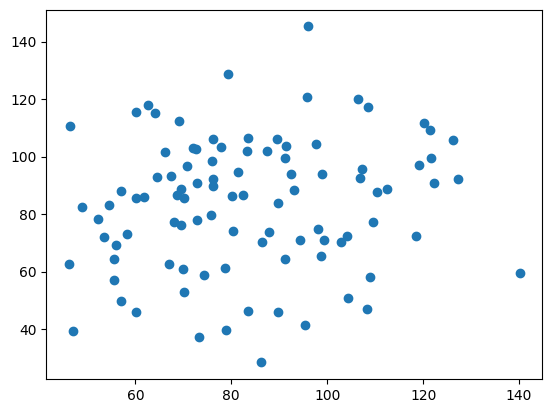

This is factor 1
height
height
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.5335160208742867, pvalue=2.1828842789570036e-08) [[1.         0.50544306]
 [0.50544306 1.        ]]


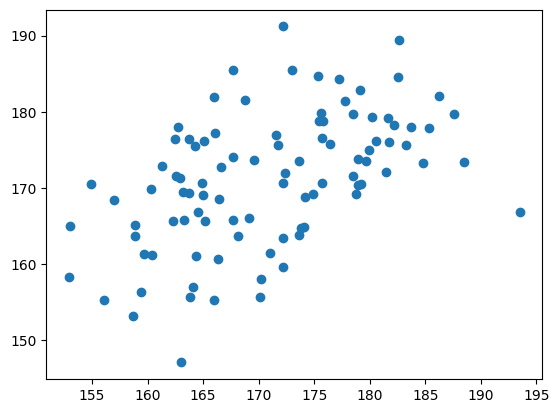

This is factor 2
bmi
bmi
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=-0.03433013529132442, pvalue=0.7398462634340744) [[ 1.        -0.0788262]
 [-0.0788262  1.       ]]


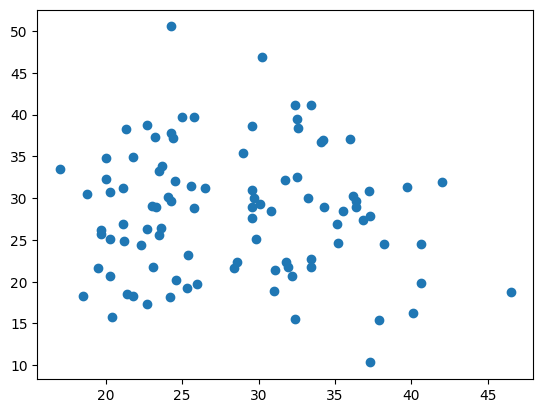

This is factor 3
bpm
bpm
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.04748507560505528, pvalue=0.6459315174879072) [[1.         0.02856006]
 [0.02856006 1.        ]]


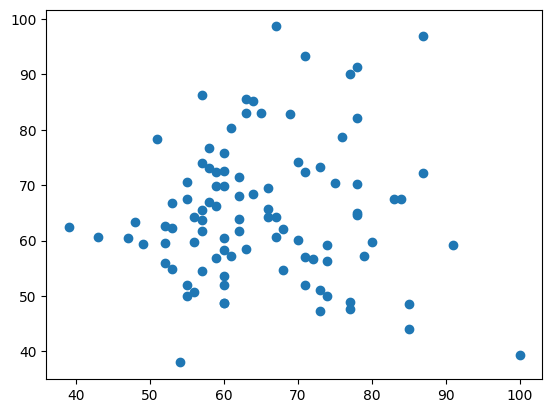

This is factor 4
sysBP
sysBP
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.07133430454650136, pvalue=0.48978203919146546) [[ 1.         -0.03708902]
 [-0.03708902  1.        ]]


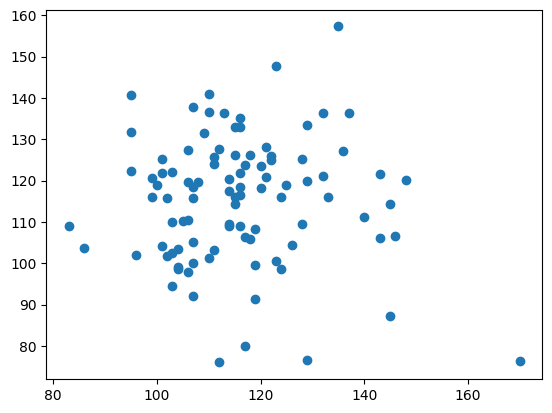

This is factor 5
diaBP
diaBP
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.18925333307202508, pvalue=0.06478588202064392) [[1.         0.16763181]
 [0.16763181 1.        ]]


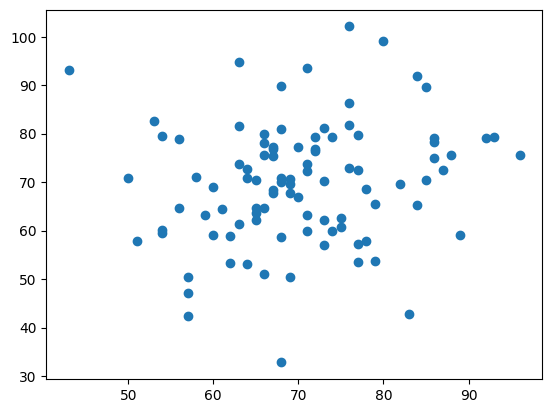

This is factor 6
SECA_fat
SECA_fat
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.05141196380906914, pvalue=0.6188626918626658) [[1.         0.01154823]
 [0.01154823 1.        ]]


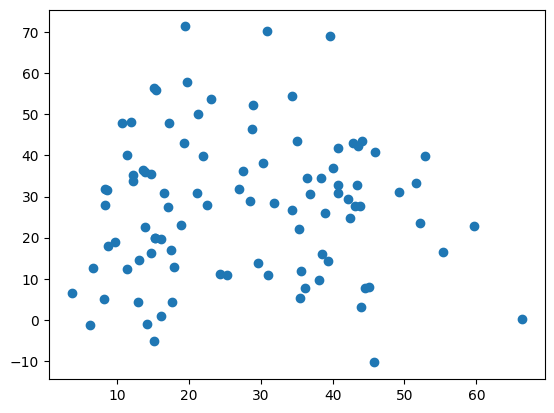

This is factor 7
SECA_fatfree
SECA_fatfree
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.6918013337084542, pvalue=5.982823758722662e-15) [[1.         0.62970822]
 [0.62970822 1.        ]]


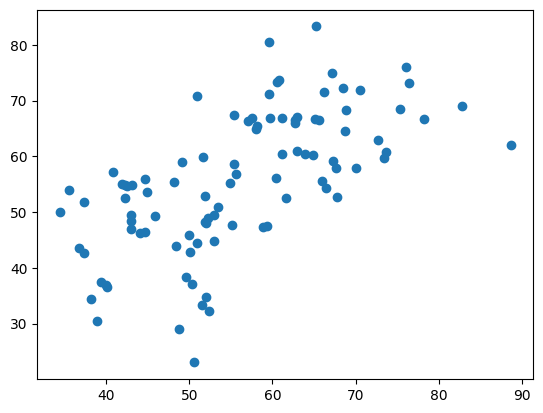

This is factor 8
SECA_fatPercent
SECA_fatPercent
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.3197837679167758, pvalue=0.0014931138217034428) [[1.         0.32423435]
 [0.32423435 1.        ]]


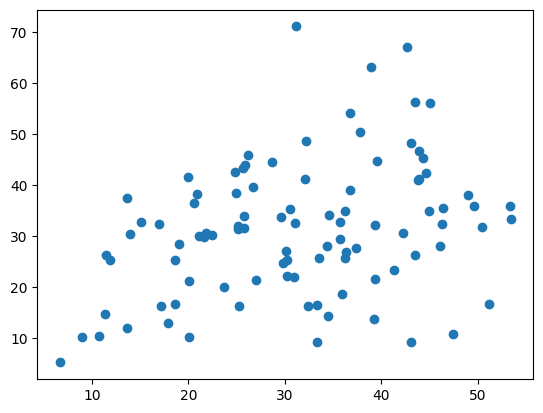

This is factor 9
waist
waist
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.2180254101768472, pvalue=0.032845752520315005) [[1.         0.17387726]
 [0.17387726 1.        ]]


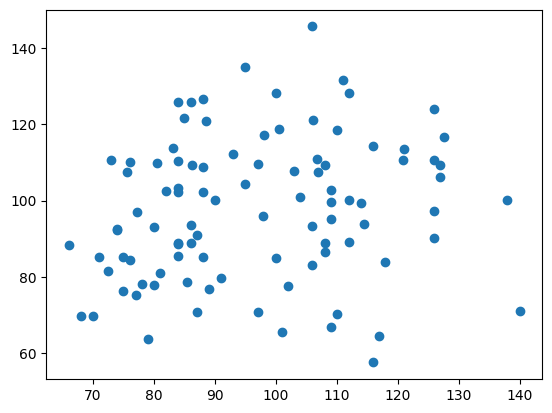

This is factor 10
abdomDiam
abdomDiam
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.22332188291449082, pvalue=0.028732517004644503) [[1.         0.20940587]
 [0.20940587 1.        ]]


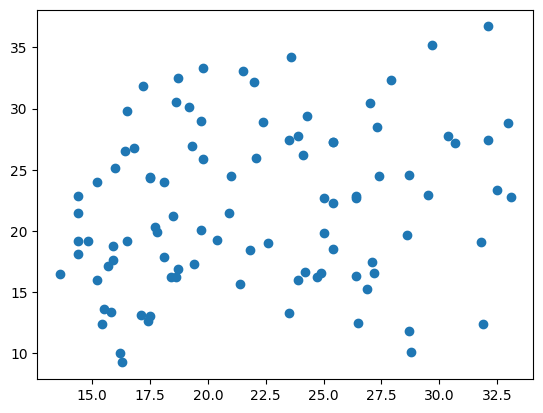

This is factor 11
wbc
wbc
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=-0.029997797476187214, pvalue=0.7717150141085029) [[1.         0.01725945]
 [0.01725945 1.        ]]


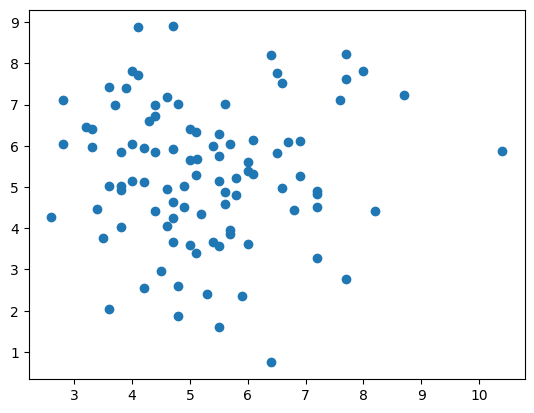

This is factor 12
hemoglobin
hemoglobin
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.3518309509869583, pvalue=0.00043948912320938675) [[1.         0.31708257]
 [0.31708257 1.        ]]


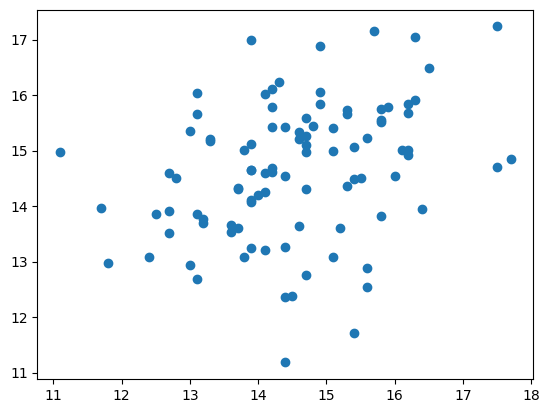

This is factor 13
hematocrit
hematocrit
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=-0.037959700406703434, pvalue=0.7134788603433388) [[ 1.         -0.03303565]
 [-0.03303565  1.        ]]


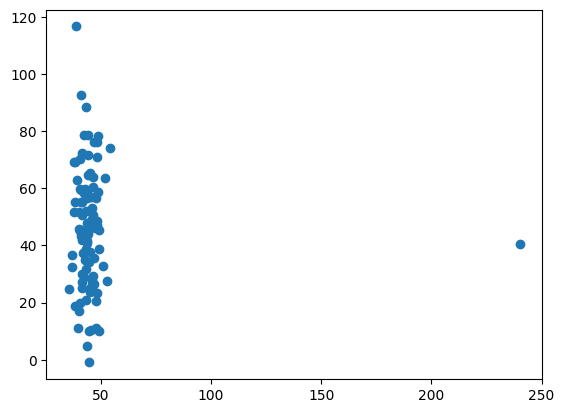

This is factor 14
neutrophils
neutrophils
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.09009525021940609, pvalue=0.382683177619063) [[1.         0.11568825]
 [0.11568825 1.        ]]


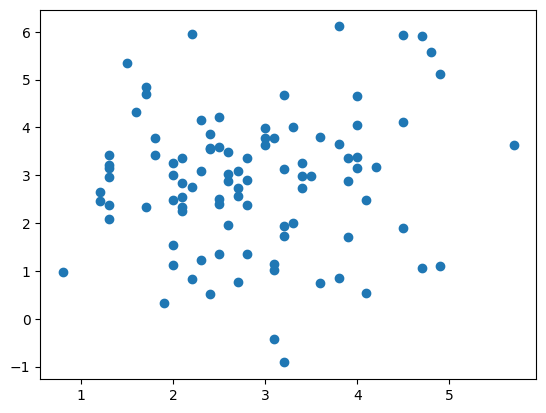

This is factor 15
lymphocytes
lymphocytes
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.12512559632646852, pvalue=0.2244819904384199) [[1.         0.20488601]
 [0.20488601 1.        ]]


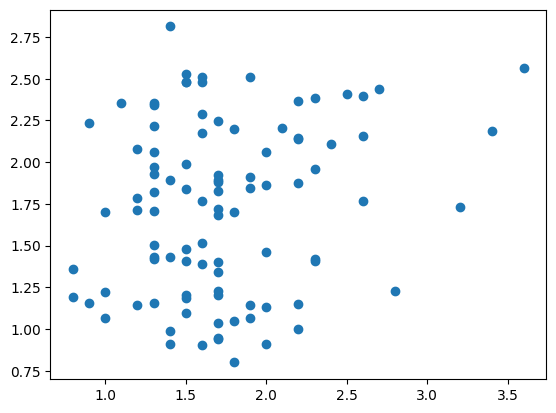

This is factor 16
monocytes
monocytes
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=-0.03648974582490893, pvalue=0.7241190177251878) [[ 1.         -0.06303329]
 [-0.06303329  1.        ]]


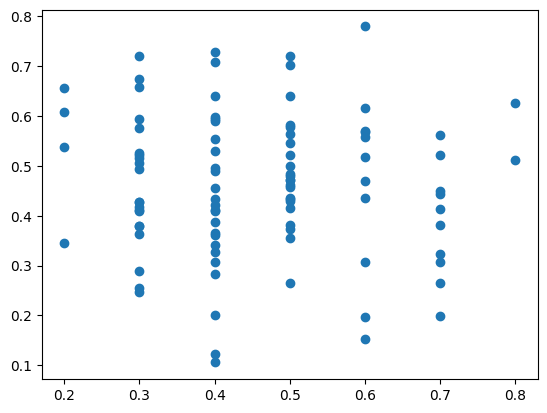

This is factor 17
eosinophils
eosinophils
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=-0.025797646987835734, pvalue=0.8029781296360586) [[ 1.         -0.00380432]
 [-0.00380432  1.        ]]


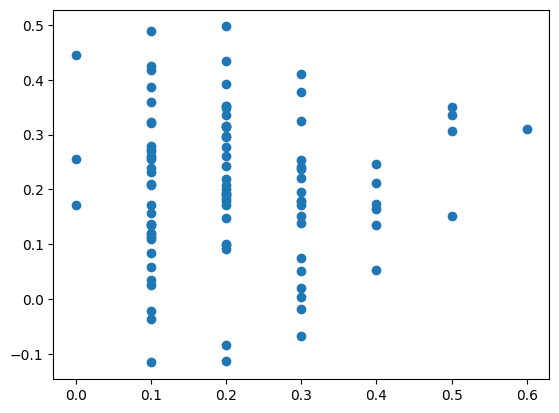

This is factor 18
basophils
basophils
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.2444376157795726, pvalue=0.016388523087143992) [[1.         0.21094698]
 [0.21094698 1.        ]]


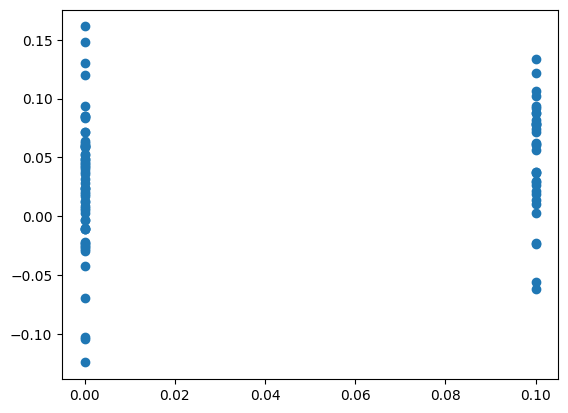

This is factor 19
glucose
glucose
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.10420991400019579, pvalue=0.31229241847302736) [[1.         0.03701885]
 [0.03701885 1.        ]]


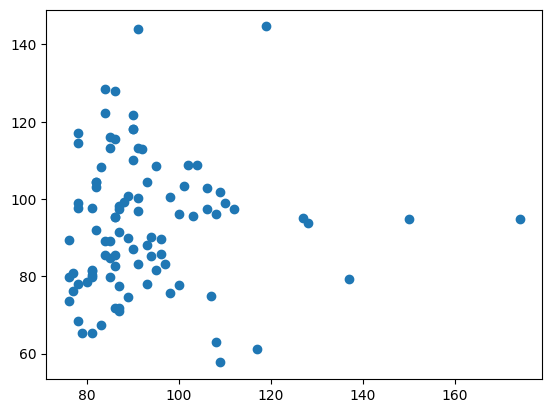

This is factor 20
BUN
BUN
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.3509084650526975, pvalue=0.00045607782127004117) [[1.         0.32424915]
 [0.32424915 1.        ]]


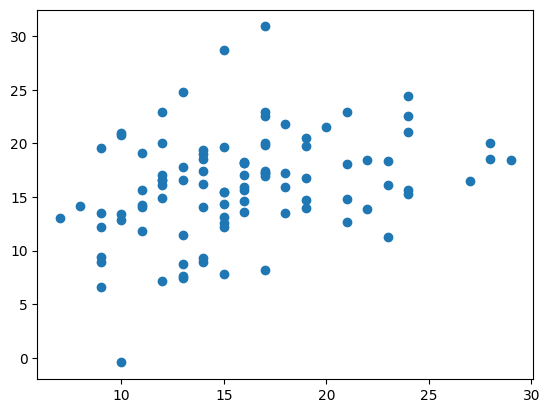

This is factor 21
creatinine
creatinine
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.4023599536382306, pvalue=4.827733380608878e-05) [[1.         0.34424867]
 [0.34424867 1.        ]]


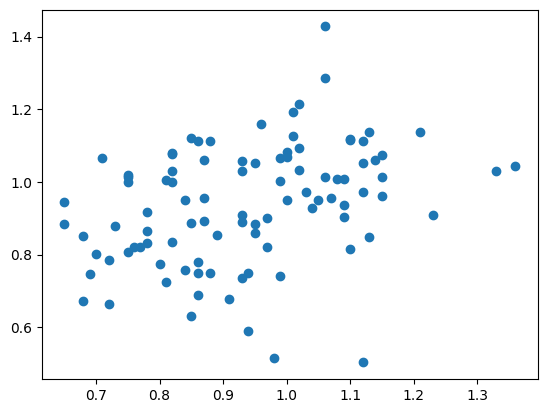

This is factor 22
sodium
sodium
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.06786779769032673, pvalue=0.5111723560111946) [[1.         0.02626598]
 [0.02626598 1.        ]]


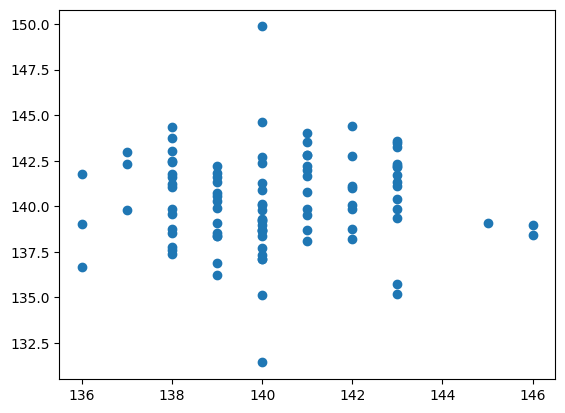

This is factor 23
potassium
potassium
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.11210908722445709, pvalue=0.27682310191515497) [[1.         0.12920948]
 [0.12920948 1.        ]]


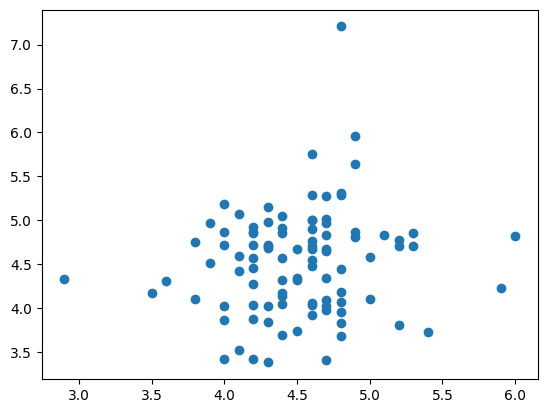

This is factor 24
chloride
chloride
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.22619019412683394, pvalue=0.026693236188693417) [[1.         0.21153016]
 [0.21153016 1.        ]]


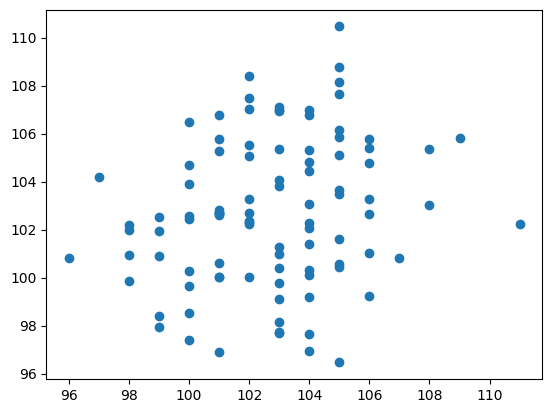

This is factor 25
C02
C02
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.22795180937373694, pvalue=0.025502792748813854) [[1.         0.19048674]
 [0.19048674 1.        ]]


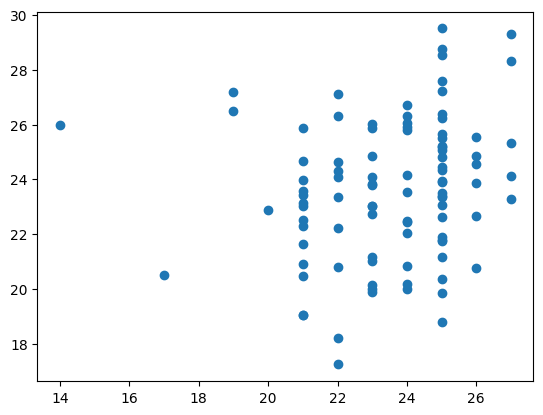

This is factor 26
calcium
calcium
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.08721770898503235, pvalue=0.39812587808758915) [[1.         0.08110373]
 [0.08110373 1.        ]]


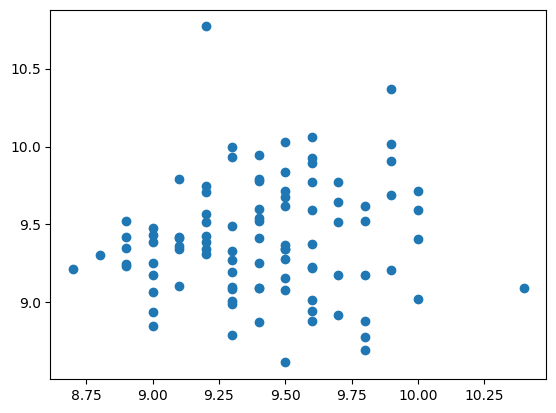

This is factor 27
protein
protein
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.08776292278907936, pvalue=0.3951718939392753) [[1.         0.11569478]
 [0.11569478 1.        ]]


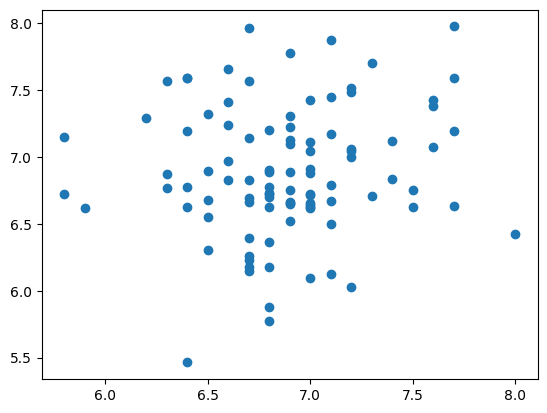

This is factor 28
albumin
albumin
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.15206806679491505, pvalue=0.13912548864325153) [[1.         0.19425912]
 [0.19425912 1.        ]]


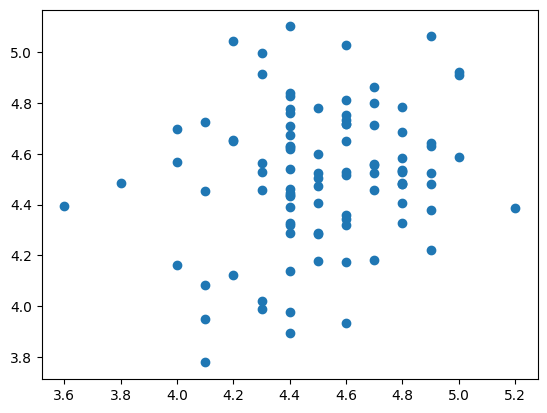

This is factor 29
globulin
globulin
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.038920704978232516, pvalue=0.706552079387484) [[1.         0.00676986]
 [0.00676986 1.        ]]


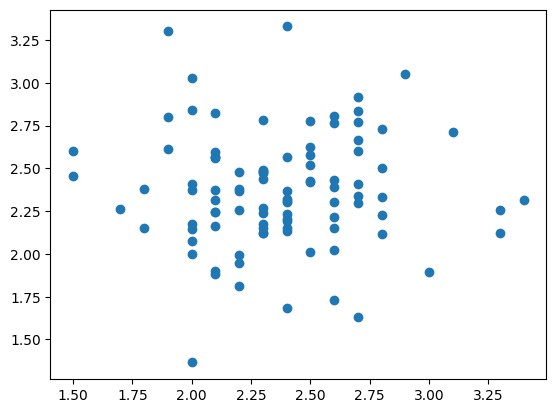

This is factor 30
bilirubin
bilirubin
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.0867806826783297, pvalue=0.40050312374270547) [[1.         0.11572608]
 [0.11572608 1.        ]]


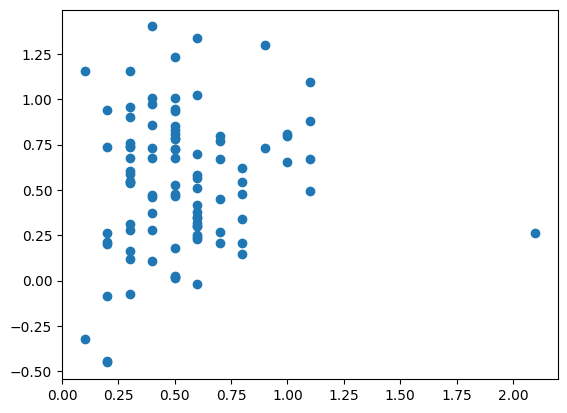

This is factor 31
alkaPhos
alkaPhos
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.2571065281417503, pvalue=0.011445858910669822) [[1.         0.21887349]
 [0.21887349 1.        ]]


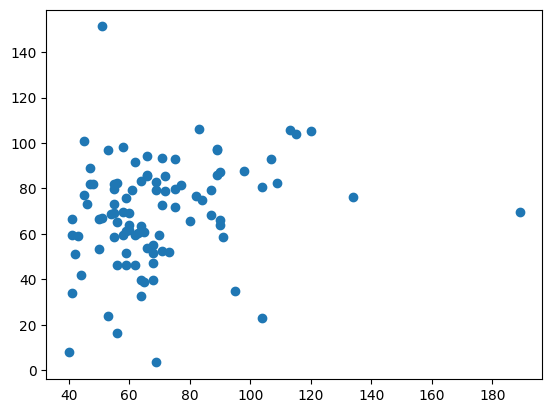

This is factor 32
AST
AST
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=-0.07690028740946925, pvalue=0.4564533608341501) [[ 1.         -0.14842274]
 [-0.14842274  1.        ]]


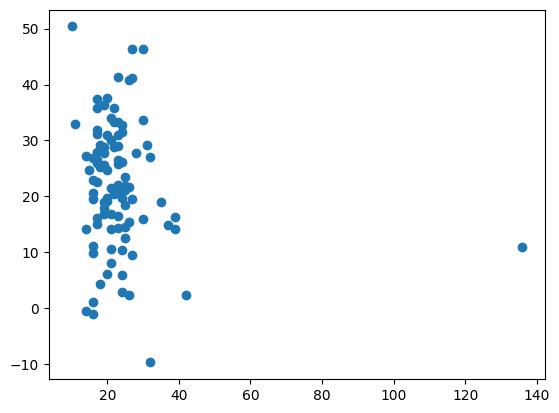

This is factor 33
ALT
ALT
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.09213024266483341, pvalue=0.37198342851765964) [[ 1.        -0.0318244]
 [-0.0318244  1.       ]]


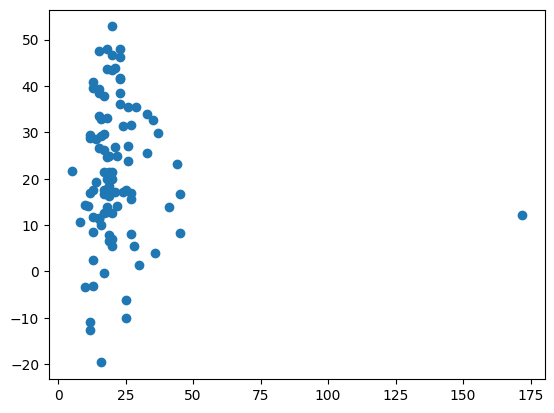

This is factor 34
chol
chol
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=-0.04407799496573697, pvalue=0.6697986266684046) [[ 1.         -0.01342246]
 [-0.01342246  1.        ]]


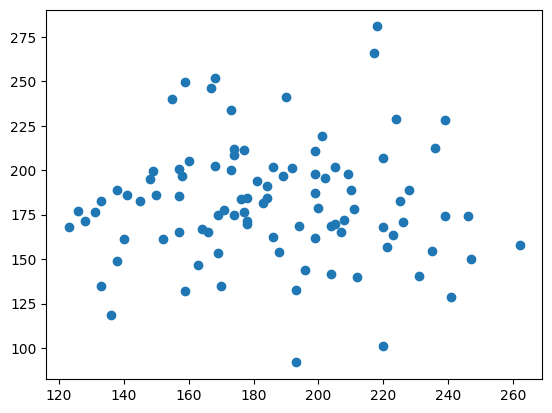

This is factor 35
trigly
trigly
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=-0.048539409456399105, pvalue=0.6386164094625641) [[ 1.         -0.03981371]
 [-0.03981371  1.        ]]


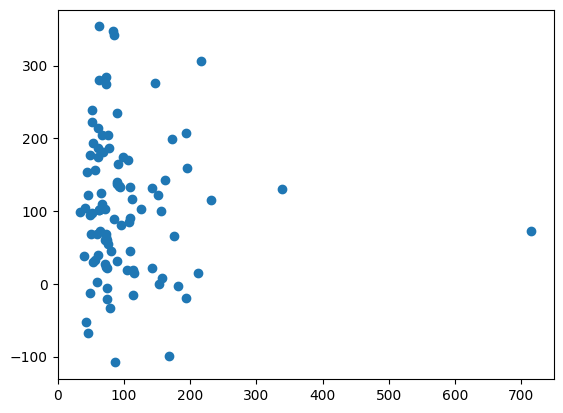

This is factor 36
HDL
HDL
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=-0.1275852362187816, pvalue=0.2154309964674524) [[ 1.         -0.11797488]
 [-0.11797488  1.        ]]


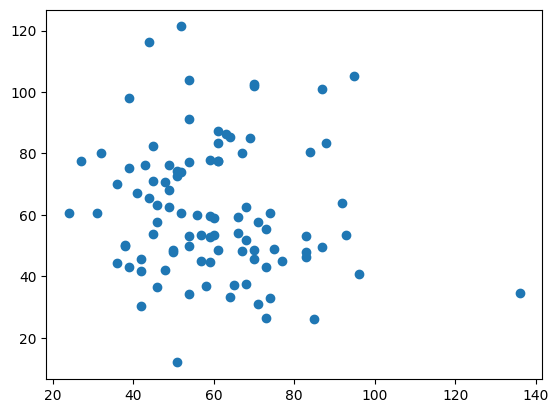

This is factor 37
LDL
LDL
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.23256698025920466, pvalue=0.022596241564416) [[1.         0.27840473]
 [0.27840473 1.        ]]


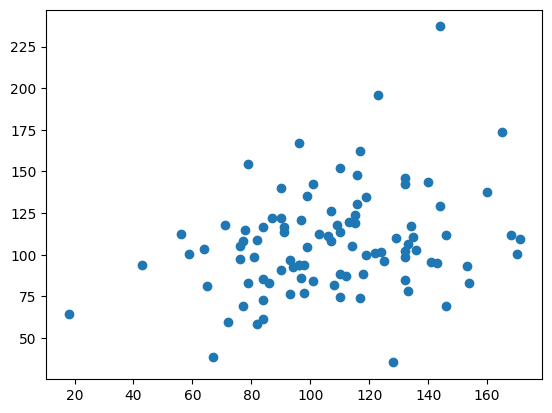

This is factor 38
cortisol
cortisol
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.268553755270406, pvalue=0.008154664433169801) [[1.         0.19708083]
 [0.19708083 1.        ]]


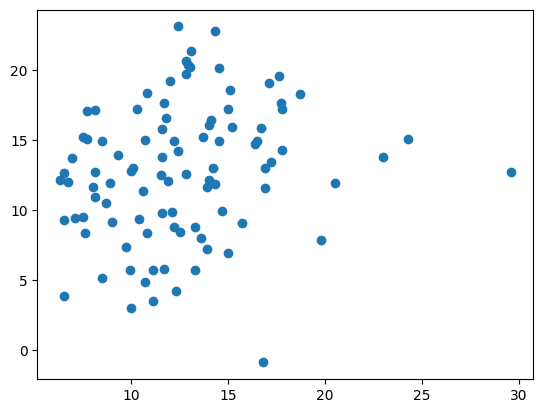

This is factor 39
TSH
TSH
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.15927273298126626, pvalue=0.12113726015417223) [[1.         0.07346711]
 [0.07346711 1.        ]]


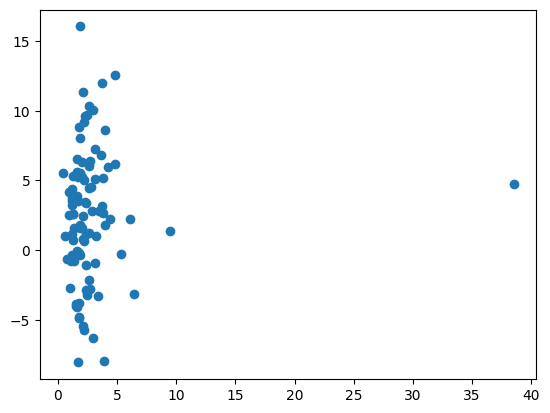

This is factor 40
calcitriol_vitD
calcitriol_vitD
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.050213660835852006, pvalue=0.6270712372229115) [[1.         0.07790623]
 [0.07790623 1.        ]]


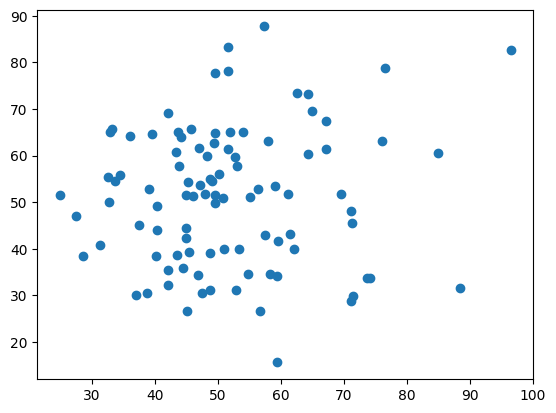

This is factor 41
CRP
CRP
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.06255120765192151, pvalue=0.5448872513485956) [[1.         0.00550662]
 [0.00550662 1.        ]]


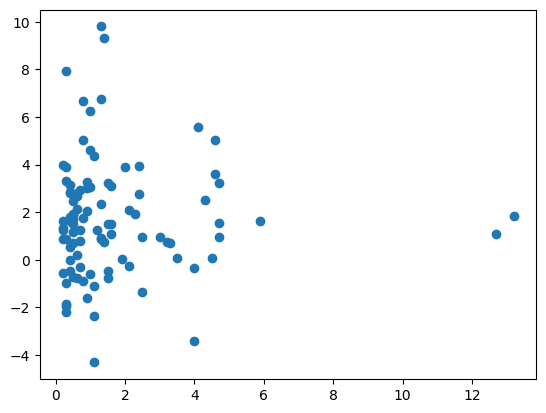

This is factor 42
B12
B12
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=-0.16269376990608728, pvalue=0.11324906711794272) [[ 1.         -0.09839537]
 [-0.09839537  1.        ]]


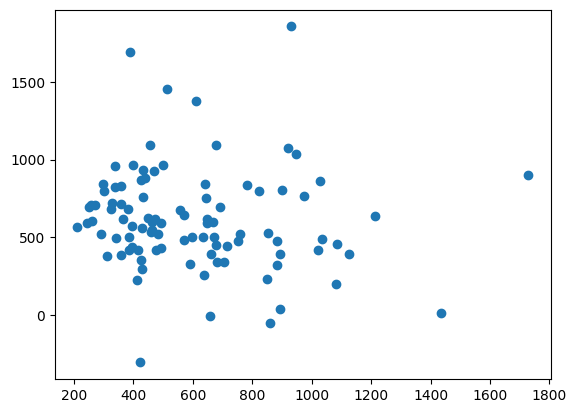

This is factor 43
insulin
insulin
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=-0.057368264720775185, pvalue=0.5787672199915384) [[ 1.         -0.15016767]
 [-0.15016767  1.        ]]


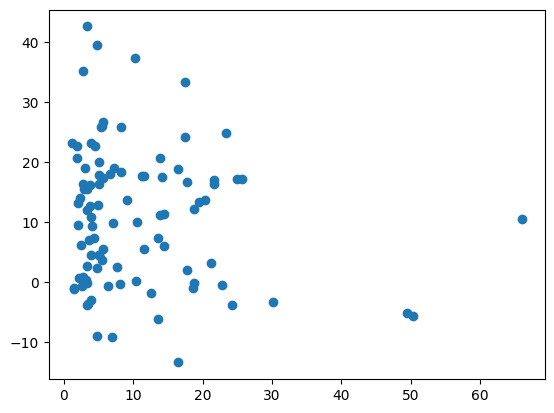

This is factor 44
freeT3
freeT3
MSE: 93.364
MAE: 2.613
SpearmanrResult(correlation=0.2239678553302964, pvalue=0.028262088696330522) [[1.         0.21173727]
 [0.21173727 1.        ]]


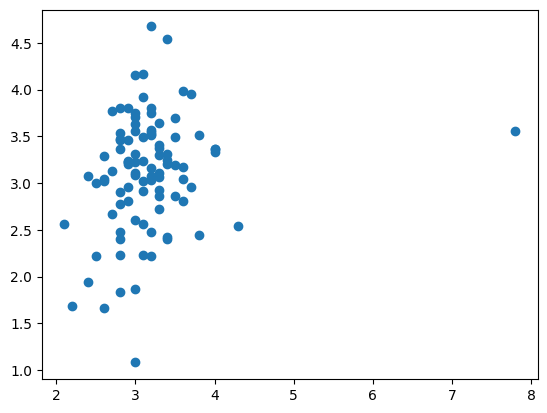

In [44]:
count_factor = 0
count_cv = 0
corrsP = []
corrsS = []

for each_factor in third_factor:
    count_cv, sum_mse, sum_mae, sum_p = 0,0,0,0
    print("This is factor", count_factor)
    print(each_factor)
    df_traits_s = df_traits[~df_traits.index.duplicated(keep='first')]
    traits = ['age','sex', each_factor] # manully input base factors, change to AGE and SEX
    phenos_ctype = []
    for num,(ind, row) in enumerate(df_meth.iterrows()):
        phenos_ctype.append(list(df_traits_s.loc[row.name][traits]))
    phenos_ctype = np.array(phenos_ctype)

    # K-fold Cross validation - KFold(n_splits=5, *, shuffle=False, random_state=None)
    X = phenos_ctype
    y = meth_multi_as
    kf = KFold(n_splits=10, shuffle=True)
    # kf.get_n_splits(X)
    
    all_phenos_true, all_phenos_pred = [], []
    
    for train_ix, test_ix in kf.split(X):
        y_true, y_pred = list(), list()

        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y.T[train_ix,:], y.T[test_ix,:]
        y_train = y_train.T
        y_test = y_test.T
        
        #choose third factor sites
        third_site = filter_sites_partial(y.T, X[:,2], X[:,0], 70)
        third_site = third_site.T
        y_train = np.append(y_train,third_site[train_ix].T,axis = 0)
        y_test = np.append(y_test,third_site[test_ix].T,axis = 0)
        
        # fit model
        msepm_md = MultistateEpigeneticPacemaker(verbose = False, iter_limit = 80)       
        msepm_md.fit(X_train, y_train)
        
        # evaluate model
        pred_md, site_residual = msepm_md.predict(y_test, True)
        #yhat = np.add(site_residual, y_test)
        
        # store
        all_phenos_true.append(X_test[:,2])
        all_phenos_pred.append(pred_md[:,2])
        mse = mean_squared_error(phenos_true, phenos_pred)
        mae = mean_absolute_error(phenos_true, phenos_pred)
        sum_mse = sum_mse + mse
        sum_mae = sum_mae + mae
    
    # calculate accuracy
    avg_mse = sum_mse/96
    avg_mae = sum_mae/96
    #avg_p = sum_p/96
    print(each_factor)
    print('MSE: %.3f' % avg_mse)
    print('MAE: %.3f' % avg_mae)
    all_phenos_true = [val for sublist in all_phenos_true for val in sublist]
    all_phenos_pred = [val for sublist in all_phenos_pred for val in sublist]
    p_corr2 = np.corrcoef(all_phenos_true, all_phenos_pred)
    s_corr2 = stats.spearmanr(all_phenos_true, all_phenos_pred)
    print(s_corr2,p_corr2)
    corrsP.append(p_corr2)
    corrsS.append(s_corr2)
    
    scatterplot = plt.scatter(all_phenos_true, all_phenos_pred)
#     ax = plt.gca()
#     ax.axline([0, 0], [1, 1])
    plt.show(scatterplot)
    
    count_factor=count_factor+1

In [45]:
corrs3 = []

for i in range(len(corrsS)):
    corrs3.append(corrsS[i][0])

factorCorrsS = list(zip(corrs3,third_factor))
factorCorrsS.sort()
factorCorrsS

[(-0.16269376990608728, 'B12'),
 (-0.1275852362187816, 'HDL'),
 (-0.07690028740946925, 'AST'),
 (-0.057368264720775185, 'insulin'),
 (-0.048539409456399105, 'trigly'),
 (-0.04407799496573697, 'chol'),
 (-0.037959700406703434, 'hematocrit'),
 (-0.03648974582490893, 'monocytes'),
 (-0.03433013529132442, 'bmi'),
 (-0.029997797476187214, 'wbc'),
 (-0.025797646987835734, 'eosinophils'),
 (0.038920704978232516, 'globulin'),
 (0.04748507560505528, 'bpm'),
 (0.050213660835852006, 'calcitriol_vitD'),
 (0.05141196380906914, 'SECA_fat'),
 (0.06255120765192151, 'CRP'),
 (0.06786779769032673, 'sodium'),
 (0.07133430454650136, 'sysBP'),
 (0.0867806826783297, 'bilirubin'),
 (0.08721770898503235, 'calcium'),
 (0.08776292278907936, 'protein'),
 (0.09009525021940609, 'neutrophils'),
 (0.09213024266483341, 'ALT'),
 (0.10420991400019579, 'glucose'),
 (0.11210908722445709, 'potassium'),
 (0.12512559632646852, 'lymphocytes'),
 (0.14285568950361674, 'weight'),
 (0.15206806679491505, 'albumin'),
 (0.159272732

In [46]:
corrs2 = []

for i in corrsP:
    corrs2.append(i[0][1])

factorCorrs = list(zip(corrs2,third_factor))
factorCorrs.sort()
factorCorrs

[(-0.15016766689983063, 'insulin'),
 (-0.14842274232958358, 'AST'),
 (-0.11797488355736184, 'HDL'),
 (-0.09839537084776005, 'B12'),
 (-0.07882620443955074, 'bmi'),
 (-0.06303328854413587, 'monocytes'),
 (-0.039813708643078656, 'trigly'),
 (-0.037089019811863085, 'sysBP'),
 (-0.03303565450020065, 'hematocrit'),
 (-0.03182440114743539, 'ALT'),
 (-0.013422461173237872, 'chol'),
 (-0.003804318590090098, 'eosinophils'),
 (0.005506618117259111, 'CRP'),
 (0.006769861506688911, 'globulin'),
 (0.011548226751947978, 'SECA_fat'),
 (0.017259451347179783, 'wbc'),
 (0.026265976334070427, 'sodium'),
 (0.028560063705122114, 'bpm'),
 (0.037018850629896474, 'glucose'),
 (0.0734671095139198, 'TSH'),
 (0.07790622719911747, 'calcitriol_vitD'),
 (0.08110373374794, 'calcium'),
 (0.11568825183894317, 'neutrophils'),
 (0.11569478024111311, 'protein'),
 (0.1157260844949858, 'bilirubin'),
 (0.1292094799267228, 'potassium'),
 (0.1309420200416782, 'weight'),
 (0.16763180851213694, 'diaBP'),
 (0.17387726187293923, 